### QF627 AY 2023-24 G2 Group 1 Final Project

The take-home group assignment is yet another intriguing task in computational finance—building your trading strategy to beat the market. Yes, this is not an easy task given the stage of your learning for now. Thus, rather than trying to predict the future, the take-home group project asks you to employ backtesting to test your strategies.

Note that this is for assignment purposes, and you are running backtesting here. Recall that even if you could beat the market in the past, that does not mean that you will be able to do so in the future.

You will build your trading strategy using the past 20 years (`November 2004 through October 2023`) of S&P 500 data, extracting the data from Yahoo Finance. Your starting capital is set at `$100,000`.

### <a id = "top">Table of Contents</a>
#### [Part 1: Momentum Strategies](#s1)
#### [Part 2: Mean Reversion Strategies](#s2)
#### [Part 3: Machine Learning Strategies](#s3)
#### [Part 4: Conclusion](#s4)
#### [Part 5: Self Critiques](#s5)

In [ ]:
import math
import numpy      as np
import pandas     as pd

import datetime   as dt

import yfinance   as yf
(
    yf
    .pdr_override()
)

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn    as sns
from pandas_datareader import data as pdr


mpl.rcParams["axes.grid"]       = True
mpl.rcParams["axes.facecolor"]  = "white"
mpl.rcParams["figure.figsize"]  = (16, 6)
mpl.rcParams["legend.loc"]      = "upper left"
mpl.rcParams["legend.facecolor"]  = "white"

plt.style.use("ggplot")
sns.set_theme(palette = "deep")

import warnings
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.arima.model as stats
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler

# split, cross-validation, tuning, grid_search

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

# models (algos.)

# Predictive Model --> ML --> Supervised Learning --> Classification

# binary classification (up vs. down)
# multiclass
# multiclass with order (ordinal outcome)
# multiclass without order (nominal outcome)

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # multi-class

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import KNeighborsClassifier

from sklearn.neural_network import MLPClassifier

# Useful toolkit from sklearn

from sklearn.pipeline import Pipeline

# assessment of your models

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from mpl_toolkits.mplot3d import Axes3D

import re
from collections import OrderedDict
from time import time
import sqlite3

from scipy.linalg import svd
from scipy import stats
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import ipywidgets as widgets
from ipywidgets import interact, interact_manual, fixed

In [ ]:
def getPortfolioReturnPctAnnual(
    arr_ret : np.array, *,
    window : int = 252):
    return np.prod(1 + arr_ret) **(window / len(arr_ret)) - 1

def getPortfolioVolAnnual(
    arr_ret : np.array, *,
    window : int = 252
):
    return arr_ret.std() * window **0.5

def getSharpeRatio(
    arr_ret : np.array, *,
    window : int = 252
):
    ret_portfolio = getPortfolioReturnPctAnnual(arr_ret)
    vol_portfolio = getPortfolioVolAnnual(arr_ret, window = window)
    return ret_portfolio / vol_portfolio, ret_portfolio, vol_portfolio

def getCagr(arr_ret):
    ret_period  = (arr_ret.index[-1] - arr_ret.index[0]).days
    return ((1 + arr_ret.iloc[-1]) / (1 + arr_ret.iloc[0])) **(365 / ret_period) - 1

def getDrawdownDf(
    arr_ret_daily : np.array, *,
    type_ret : str = "pct",
    window : int = None, plot : bool = True
):
    if type_ret == "pct":
        arr_ret = (1 + arr_ret_daily).cumprod() - 1

        if window is not None:
            arr_ret_cummax    = (1 + arr_ret).cummax().rolling(window = window, min_periods = 1).max() - 1
            arr_drawdown      = arr_ret - arr_ret_cummax
            arr_drawdown_max  = arr_drawdown.rolling(window = window, min_periods = 1).min()
        else:
            arr_ret_cummax  = (1 + arr_ret).cummax() - 1
            arr_drawdown    = arr_ret - arr_ret_cummax
            arr_drawdown_max    = arr_drawdown.cummin().fillna(0.0)
    elif type_ret == "log":
        arr_ret = np.exp(arr_ret_daily.cumsum()) - 1

        if window is not None:
            arr_ret_cummax  = arr_ret.rolling(window = window, min_periods = 1).max().fillna(0.0)
            arr_drawdown    = arr_ret - arr_ret_cummax
            arr_drawdown_max    = arr_drawdown.rolling(window = window, min_periods = 1).min().fillna(0.0)
        else:
            arr_ret_cummax  = arr_ret.fillna(0.0).cummax().fillna(0.0)
            arr_drawdown    = arr_ret - arr_ret_cummax
            arr_drawdown_max    = arr_drawdown.cummin().fillna(0.0)

    if plot:
        fig, axes   = plt.subplots(
            nrows   = 2,
            sharex  = True,
            figsize = (16, 12)
        )

        axes[0].plot(
            arr_ret,
            label   = "return"
        )
        axes[0].plot(
            arr_ret_cummax,
            label   = "cum max"
        )
        axes[0].set_title(f"{type_ret} return against time")
        axes[0].set_ylabel(f"{type_ret} return")
        axes[0].legend()

        axes[1].plot(
            arr_drawdown,
            label   = "drawdown"
        )
        axes[1].plot(
            arr_drawdown_max,
            label   = "max drawdown"
        )

        if window is not None:
            axes[1].set_title(f"drawdown against time in {window}-d window")
        else:
            axes[1].set_title("drawdown against time over entire horizon")
        axes[1].set_ylabel("drawdown")
        axes[1].legend()

    arr_drawdown_period = pd.Series(
        index = arr_ret.index,
        data  = np.array(np.nan) * len(arr_ret)
    )

    arr_drawdown_max    = pd.Series(arr_drawdown_max)
    arr_drawdown_max_diff   = arr_drawdown_max.diff().fillna(0.0)

    b = arr_drawdown_max.index[0]
    for i, d in enumerate(arr_drawdown_max_diff.items()):
        if d[1] != 0:
            b = arr_drawdown_max.index[i]

        arr_drawdown_period.iloc[i] = arr_drawdown_max.index[i] - b

    return pd.DataFrame(
            index   = arr_ret.index,
            data    =
                {
                    "return"            : arr_ret,
                    "drawdown"          : arr_drawdown,
                    "drawdown_max"      : arr_drawdown_max,
                    "drawdown_period"   : arr_drawdown_period
                }
        )


In [ ]:
LIST_TICKER = "SPY"
DATE_BEGIN  = dt.date(2004, 11, 1)
DATE_END    = dt.date(2023, 10, 31)

### DOWNLOAD RAW DATA OF S&P500 THROUGH YAHOO FINANCE
df_sp500  = yf.download(LIST_TICKER, DATE_BEGIN, DATE_END)
df_sp500.info()
df_sp500


[*********************100%%**********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4782 entries, 2004-11-01 to 2023-10-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4782 non-null   float64
 1   High       4782 non-null   float64
 2   Low        4782 non-null   float64
 3   Close      4782 non-null   float64
 4   Adj Close  4782 non-null   float64
 5   Volume     4782 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 261.5 KB


Open        High         Low       Close   Adj Close  \
Date                                                                     
2004-11-01  113.559998  113.839996  113.199997  113.510002   78.617935   
2004-11-02  113.669998  114.570000  113.220001  113.550003   78.645630   
2004-11-03  115.029999  115.360001  114.239998  114.980003   79.636063   
2004-11-04  114.779999  116.669998  114.680000  116.550003   80.723488   
2004-11-05  117.050003  117.639999  116.489998  117.279999   81.229073   
...                ...         ...         ...         ...         ...   
2023-10-24  422.649994  424.820007  420.739990  423.630005  423.630005   
2023-10-25  421.890015  421.920013  417.019989  417.549988  417.549988   
2023-10-26  416.450012  417.329987  411.600006  412.549988  412.549988   
2023-10-27  414.190002  414.600006  409.209991  410.679993  410.679993   
2023-10-30  413.559998  416.679993  412.220001  415.589996  415.589996   

               Volume  
Date                   
2004-11-01   36720900  
2004-11-02   56210000  
2004-11-03   76960200  
2004-11-04   55350300  
2004-11-05   63287200  
...               ...  
2023-10-24   78564200  
2023-10-25   94223200  
2023-10-26  115156800  
2023-10-27  107367700  
2023-10-30   86562700  

[4782 rows x 6 columns]

In [ ]:
### Use adjusted close price as the starting point
df_sp500_price  = df_sp500[["Adj Close"]]
df_sp500_price.columns    = ["price"]
df_sp500_price.index = pd.to_datetime(df_sp500_price.index)
df_sp500_price.index.name  = "date"

### Use log return for single asset;
df_sp500_price["ret_asset"]  = (df_sp500_price.price / df_sp500_price.price.shift(periods = 1)).apply(np.log).fillna(0.0)

df_sp500_price_bkup  = df_sp500_price.copy()
df_sp500_price


<ipython-input-4-28a5bb65f3e0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sp500_price["ret_asset"]  = (df_sp500_price.price / df_sp500_price.price.shift(periods = 1)).apply(np.log).fillna(0.0)


price  ret_asset
date                             
2004-11-01   78.617935   0.000000
2004-11-02   78.645630   0.000352
2004-11-03   79.636063   0.012515
2004-11-04   80.723488   0.013563
2004-11-05   81.229073   0.006244
...                ...        ...
2023-10-24  423.630005   0.007511
2023-10-25  417.549988  -0.014456
2023-10-26  412.549988  -0.012047
2023-10-27  410.679993  -0.004543
2023-10-30  415.589996   0.011885

[4782 rows x 2 columns]

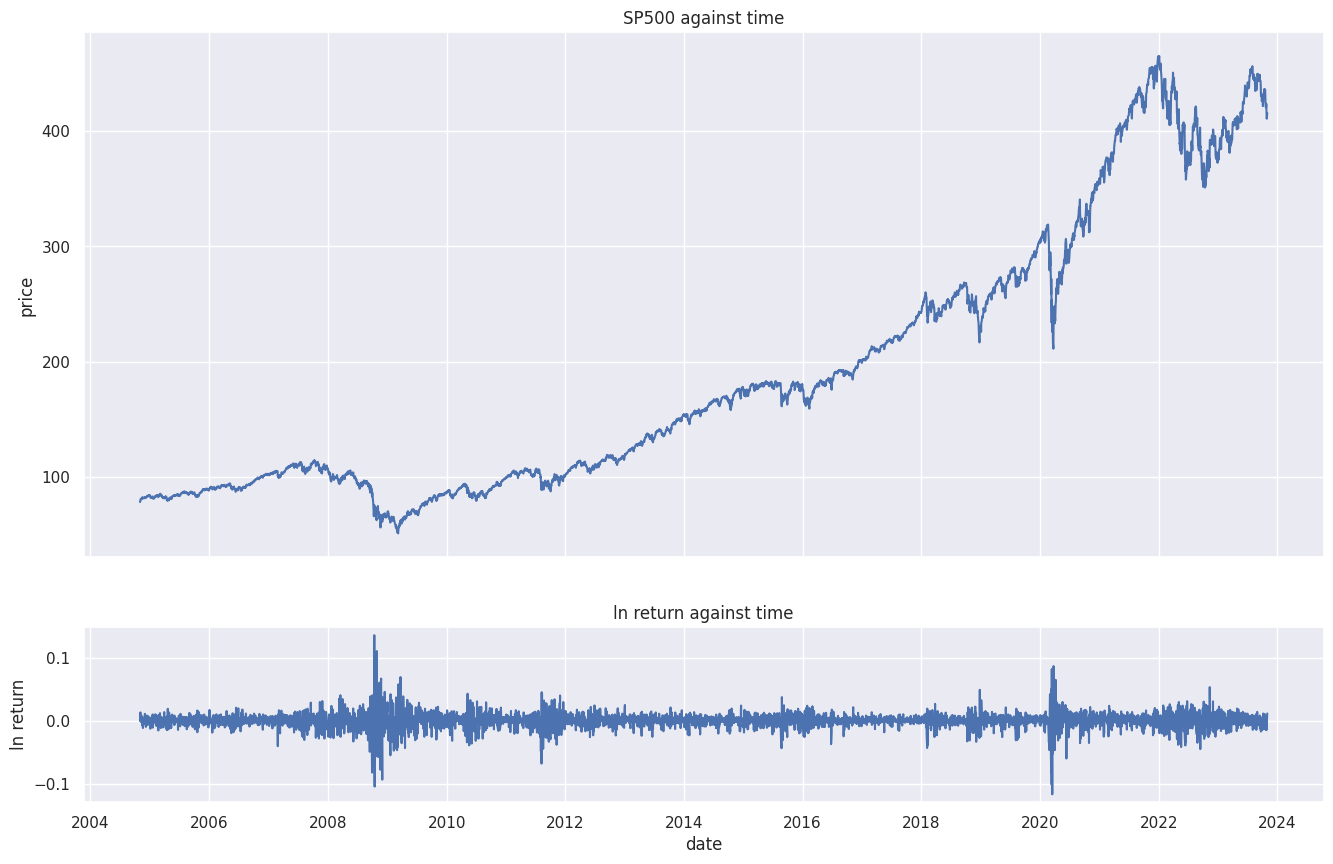

In [ ]:
### Visualise price trend
fig, ax = plt.subplots(
    nrows   = 2,
    sharex  = True,
    figsize = (16, 10),
    height_ratios = [3, 1]
)

ax[0].plot(
    df_sp500_price.price
)
ax[0].set_ylabel("price")
ax[0].set_title("SP500 against time")

ax[1].plot(
    df_sp500_price.ret_asset
)
ax[1].set_ylabel("ln return")
ax[1].set_xlabel("date")
ax[1].set_title("ln return against time")
plt.show()


There are some general functions that will be used in the following parts.

In [ ]:
### GENERAL FUNCTIONS
def getReturnPerPositionStrategy(df : pd.DataFrame):
    df["strategy"]      = df.position
    df["ret_strategy"]  = df.strategy.shift(1) * df.ret_asset

    df["ret_cum_asset"]     = df.ret_asset.cumsum().apply(np.exp)
    df["ret_cum_strategy"]  = df.ret_strategy.cumsum().apply(np.exp)

    fig, ax = plt.subplots(
        # nrows   = 2,
        # sharex  = True,
        figsize = (16, 6),
        # height_ratios = [3, 1]
    )

    # ax  = ax[0]
    ax.plot(
        df[["ret_cum_strategy", "ret_cum_asset"]],
        label = ["strategy ln return", "asset ln return"]
    )
    ax.scatter(
        df[df.trade != 0].index,
        df[df.trade != 0].ret_cum_strategy,
        marker  = "^",
        color   = "green"
    )
    ax.scatter(
        df[df.trade < 0].index,
        df[df.trade < 0].ret_cum_strategy,
        marker  = "v",
        color   = "red"
    )
    ax.legend()
    ax.set_ylabel("ln return")
    ax.set_xlabel("date")

    fig.suptitle("strategy and asset return against time")

    return df

def getTradingReturn(
    df : pd.DataFrame,
    key_value       : str   = "price",
    size_trade      : int   = None,
    trade_absolute  : bool  = False,
    capital_initial : float = 10 **5,
    plot            : bool  = True
):
    if trade_absolute:
        df["position_net"]      = df.position * size_trade
        df["value_position"]    = df.position_net * df[key_value]

        df["vol_transaction"]   = df.position_net.diff().fillna(0)
        df["value_transaction"] = df.vol_transaction * df[key_value]
        df["value_cash"]        = capital_initial - df.value_transaction.cumsum()
    else:
        df["value_cash"]      = np.nan
        df["position_net"]    = np.nan
        df["vol_transaction"] = np.nan

        warnings.filterwarnings("ignore")
        df.value_cash.iloc[0]   = capital_initial
        df.position_net.iloc[0] = 0

        for i in range(len(df)):
            if i != 0:
                if df.trade.iloc[i] != 0:
                    if isinstance(size_trade, int):
                        if df.position.iloc[i] == 0:
                            df.vol_transaction.iloc[i]  = -min(df.position_net.iloc[i-1], size_trade)
                        if df.position.iloc[i] > 0:
                            df.vol_transaction.iloc[i]  = min(int(df.value_cash[i-1] / df.price[i]), size_trade)
                        if df.position.iloc[i] < 0:
                            df.vol_transaction.iloc[i]  = -min(int(df.value_cash[i-1] / df.price[i]), size_trade)
                    else:
                        if df.position.iloc[i] == 0:
                            df.vol_transaction.iloc[i]  = -df.position_net.iloc[i-1]
                        if df.position.iloc[i] > 0:
                            df.vol_transaction.iloc[i]  = int(df.value_cash[i-1] / df.price[i])
                        if df.position.iloc[i] < 0:
                            df.vol_transaction.iloc[i]  = -int(df.value_cash[i-1] / df.price[i])

                    df.position_net.iloc[i]     = df.position_net.iloc[i-1] + df.vol_transaction.iloc[i]
                    df.value_cash.iloc[i]       = df.value_cash[i-1] - df.vol_transaction.iloc[i] * df.price[i]
                else:
                    df.value_cash.iloc[i]   = df.value_cash.iloc[i-1]
                    df.position_net.iloc[i] = df.position_net.iloc[i-1]
        warnings.resetwarnings()

        df["vol_transaction"] = df.vol_transaction.fillna(0)
        df["value_position"]  = df.position_net * df.price

    df["value_total"]     = df.value_position + df.value_cash

    df["ret_portfolio"]     = df.value_total / capital_initial - 1
    df["ret_portfolio_pct"] = df.value_total.pct_change().fillna(0.0)

    if plot:
        fig, axes = plt.subplots(
            nrows   = 3,
            sharex  = True,
            figsize = (16, 15),
            height_ratios = [3, 1, 1]
        )

        ax  = axes[0]
        ax.plot(
            df[["value_total"]],
            label     = "portfolio net value"
        )
        ax.axhline(
            capital_initial,
            label     = "initial capital",
            linestyle = "dotted"
        )
        ax.set_ylabel("portfolio value")
        ax.set_title("portfolio value against time")
        ax.legend()

        ax  = axes[1]
        ax.plot(
            df[["ret_portfolio"]] * 100
        )
        ax.set_ylabel("pct return")
        ax.set_title("portfolio return against time")

        ax  = axes[2]
        ax_sec  = ax.twinx()
        ax.plot(
            df["position_net"],
            color = "green"
        )
        ax.axhline(
            0,
            linestyle = "dotted"
        )
        ax.set_ylabel("position")

        ax_sec.plot(
            df[key_value]
        )
        ax_sec.set_ylabel("asset price")
        ax.set_title("position and asset price against time")

        plt.xlabel("date")

        plt.show()

    return df


BackTseting Function

In [ ]:
def backtesting(df,name):
    #Drawdown and drawdown period
    df["max_gross_performance"] = df["ret_cum_strategy"].cummax()
    df[["ret_cum_strategy", "max_gross_performance"]].dropna().plot(figsize = [16, 9])
    drawdown = (df["max_gross_performance"] - df["ret_cum_strategy"])/df["max_gross_performance"]
    max_drawdown = drawdown.max()
    periods =\
(
    drawdown[drawdown == 0].index[ 1 :   ].to_pydatetime()
    -
    drawdown[drawdown == 0].index[   : -1].to_pydatetime()
)
    periods = np.append(periods,drawdown.index[-1].to_pydatetime()-(drawdown[drawdown == 0].index[-1].to_pydatetime()))
    max_drawdown_period = periods.max()
    #Sharpe ratio
    Sharpe_Ratio = np.sqrt(253) * (df['ret_strategy'].mean() / df['ret_strategy'].std())
    #CARG
    SPY_day = (df.index[-1] - df.index[0]).days
    CAGR = ((np.exp(df.ret_strategy.sum()))** (1 / (SPY_day /365))) - 1
    #anuual vol
    vol = df.ret_strategy.std() * 253 **0.5
    #Dollar Amount
    capital = 100000
    dollor = capital * df['ret_cum_strategy'][-1]
    backtestin_result = pd.DataFrame({"Strategy name": [name],
                                      "Max Drawdown": [max_drawdown],
                                      "Max Drawdown Period": [max_drawdown_period],
                                      "Sharpe Ratio": [Sharpe_Ratio],
                                      "CAGR": [CAGR],
                                      "annual vol": vol,
                                      "Dollar Amount": [dollor]})
    return backtestin_result


#### LONG AND HOLD


Using SPY buy and hold strategy as the benchmark, initially all initial capital was used to buy assets and hold them for 20 years. From the results below, it can be seen that the maximum drawdown of buy and hold strategy is xxx, Sharpe ratio is xxx, and CAGR is xxx

In [ ]:
df_sp500_long_hold        = df_sp500_price.copy()
df_sp500_long_hold["position"]  = 1
df_sp500_long_hold.iloc[0, -1] = 0
df_sp500_long_hold["trade"]     = df_sp500_long_hold.position.diff().fillna(0)
df_sp500_long_hold        = getReturnPerPositionStrategy(df_sp500_long_hold)
df_sp500_long_hold        = getTradingReturn(df_sp500_long_hold, capital_initial = 10 **5)

measure_sp500_long_hold = getSharpeRatio(df_sp500_long_hold.ret_portfolio_pct)
dict_measure_sp500_long_hold  = {
    "value_final"   : df_sp500_long_hold.iloc[-1]["value_total"],
    "ret_portfolio" : df_sp500_long_hold.iloc[-1]["ret_portfolio"],
    "return"        : measure_sp500_long_hold[1],
    "volatility"    : measure_sp500_long_hold[2],
    "sharpe"        : measure_sp500_long_hold[0],
    "cagr"          : getCagr(df_sp500_long_hold.ret_portfolio)
}
print(dict_measure_sp500_long_hold)

df_sp500_long_hold_dd = getDrawdownDf(df_sp500_long_hold.ret_portfolio_pct) #, window = 252)
print("\n=== MAX DRAWDOWN ON SORT BY MAX VALUES ===")
print(df_sp500_long_hold_dd.drop_duplicates(subset = "drawdown_max", keep = "first").sort_values(by = "drawdown_max", ascending = True).head(5))
print("\n=== MAX DRAWDOWN ON DRAWDOWN PERIOD ===")
print(df_sp500_long_hold_dd.drop_duplicates(subset = "drawdown_max", keep = "last").sort_values(by = "drawdown_period", ascending = False).head(5))


Next, derive several trading strategies in three different catogories, which are momentum, mean-reversion, and machine learning.

### <a id = "s1">=== PART 1: MOMENTUM STRATEGIES ===</a>
[contents](#top)

1. SMA and EWM

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[*********************100%%**********************]  1 of 1 completed


<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


Best SMA Strategy - Short Period: 50, Long Period: 250
Sharpe Ratio: 0.3905276790575163, CAGR: 0.1370326165767537, Max Drawdown: 2.0576933014850027, Max Drawdown Period: 1712 days, 0:00:00 days, Ending Balance: $397,876.23, Annualized Volatility: 0.1974, Total P&L: $138,097.08, Cumulative Returns: 3.7096

Best EWM Strategy - Span: 50
Sharpe Ratio: 0.18645945629557478, CAGR: 0.1370326165767537, Max Drawdown: 3.046542697031424, Max Drawdown Period: 1918 days, 0:00:00 days, Ending Balance: $193,383.50, Annualized Volatility: 0.1975, Total P&L: $65,950.51, Cumulative Returns: 3.6815


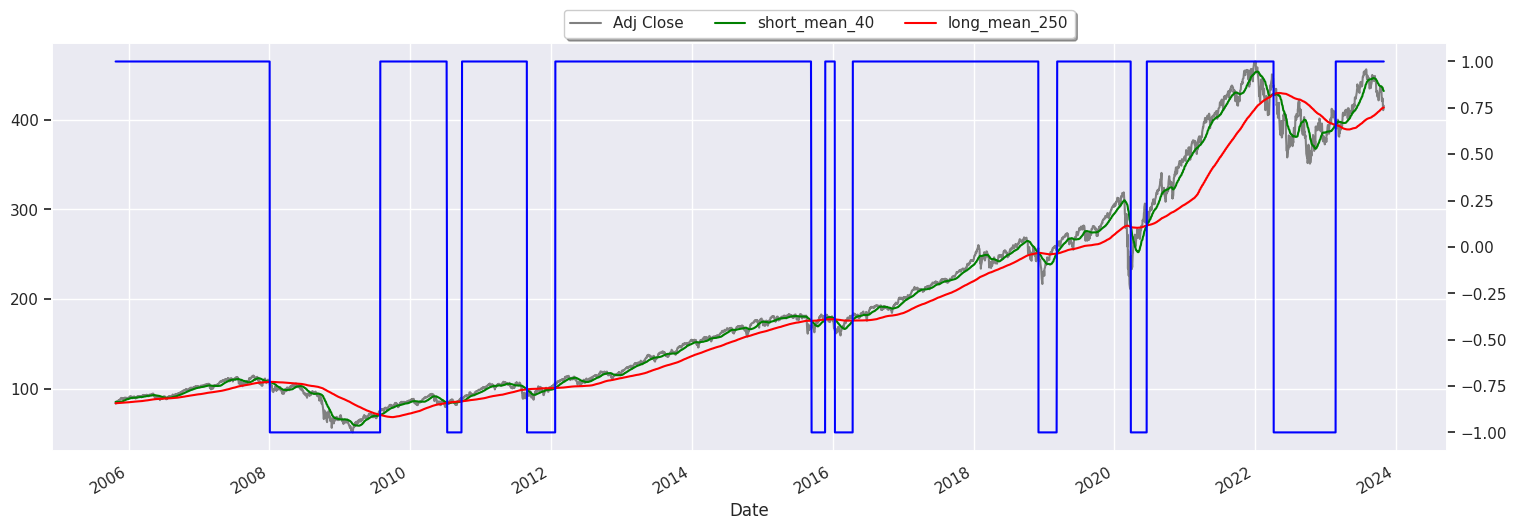

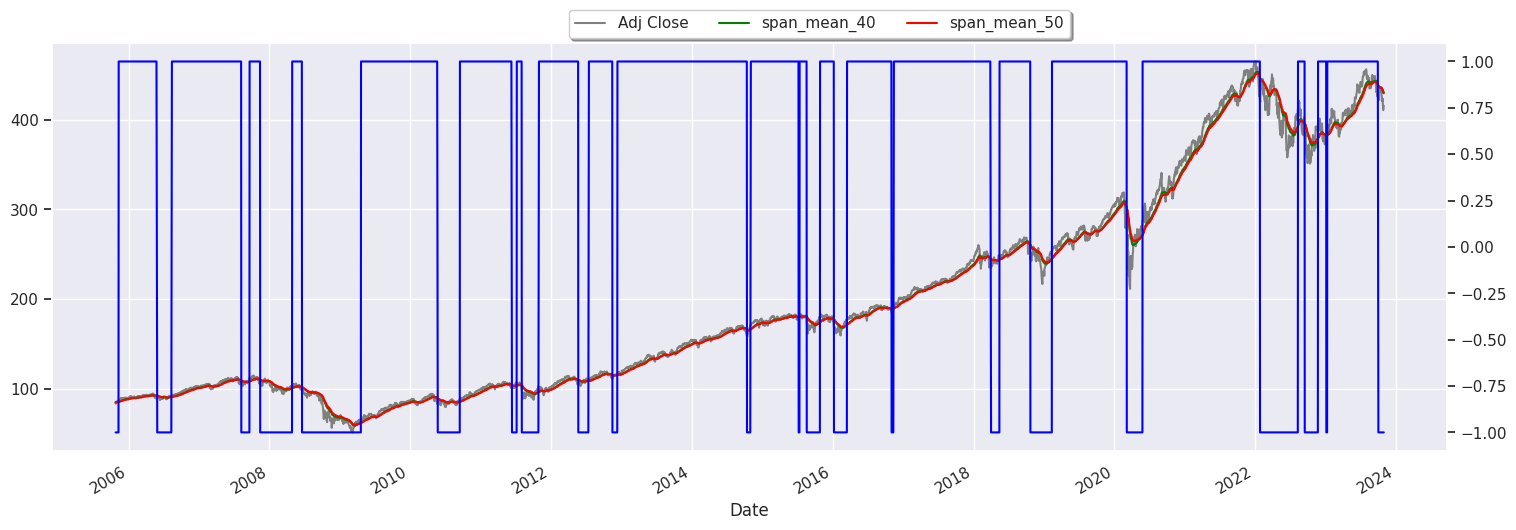

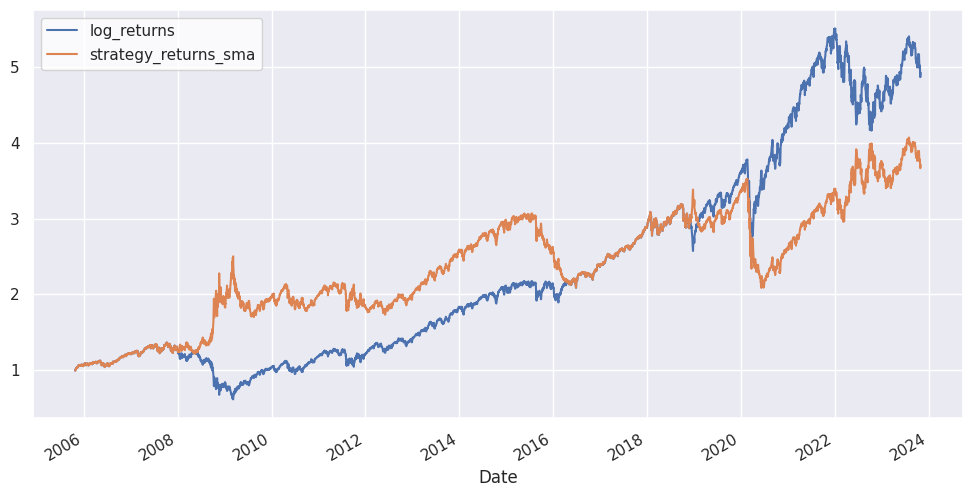

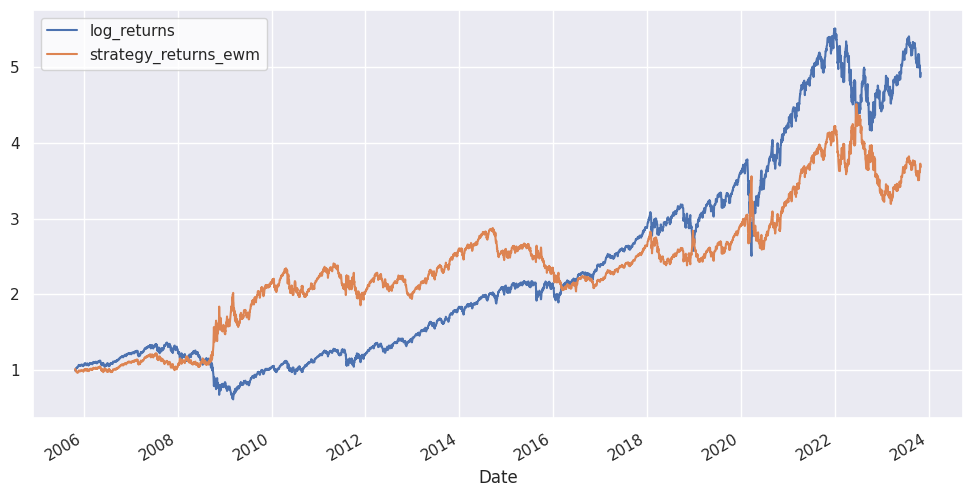

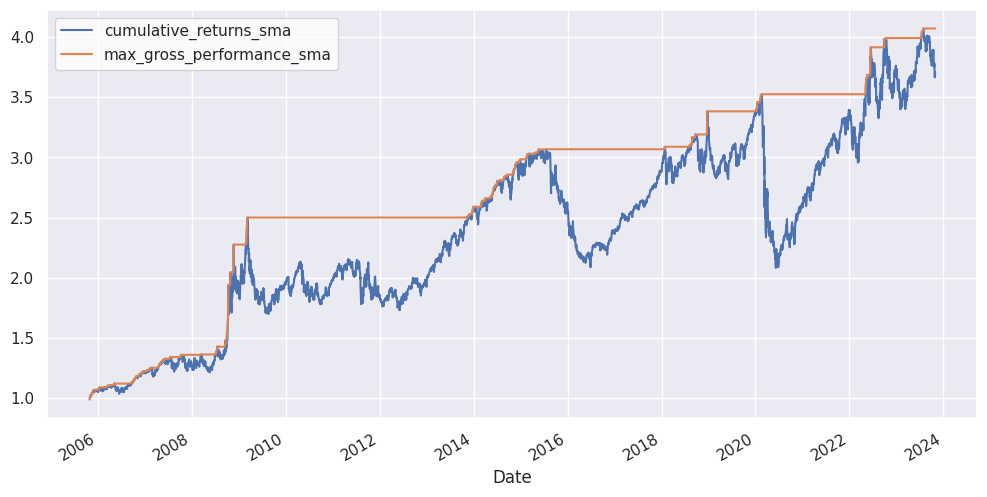

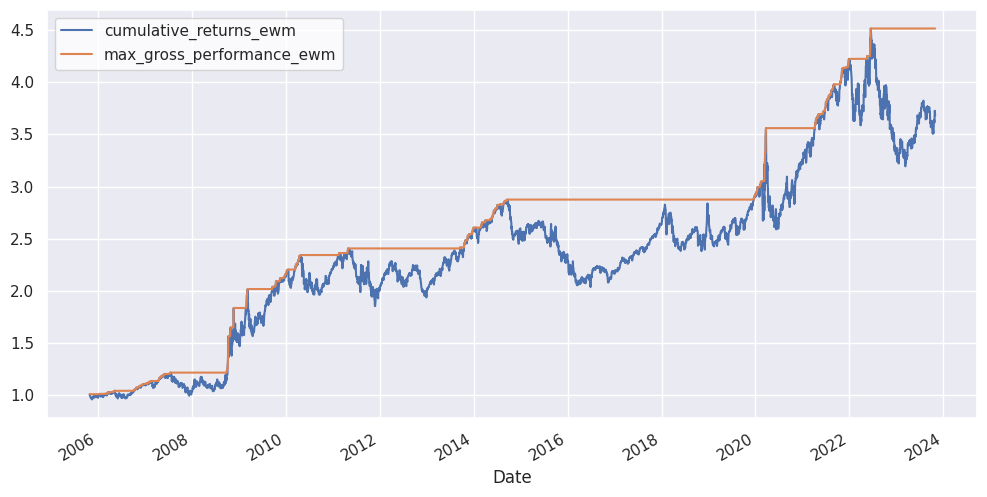

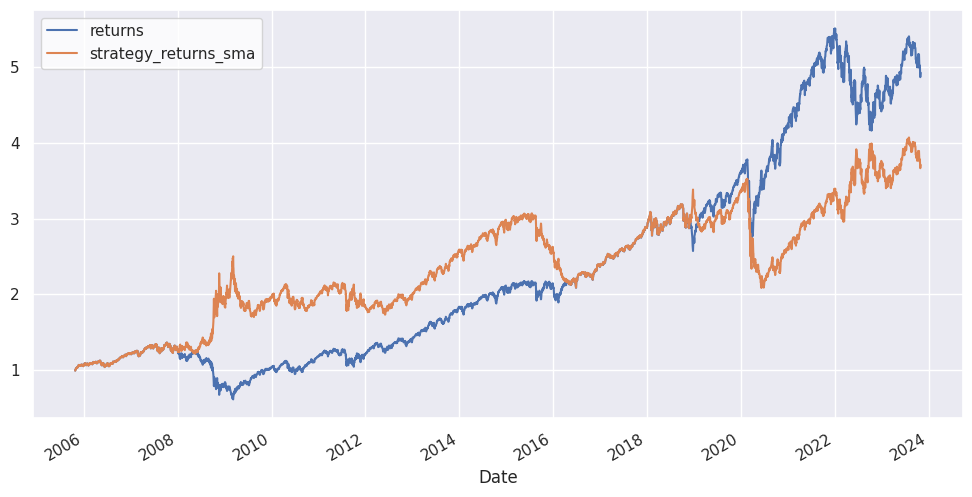

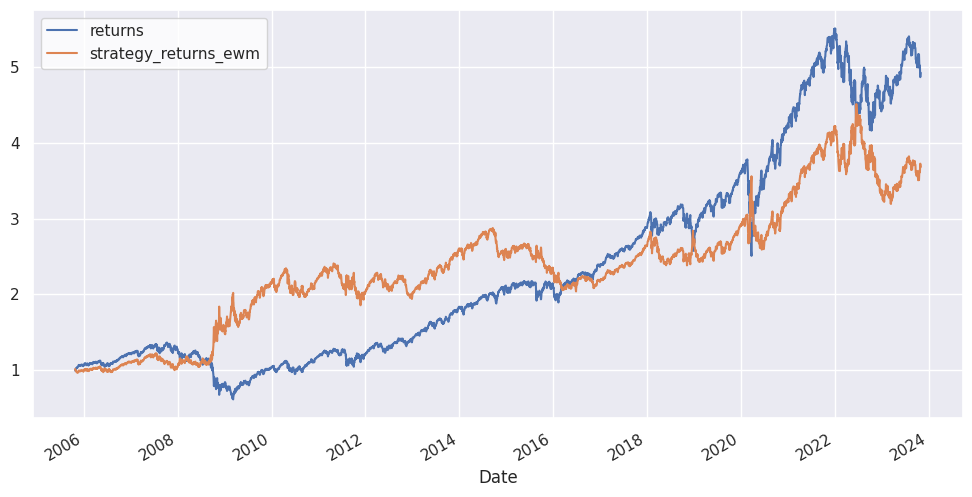

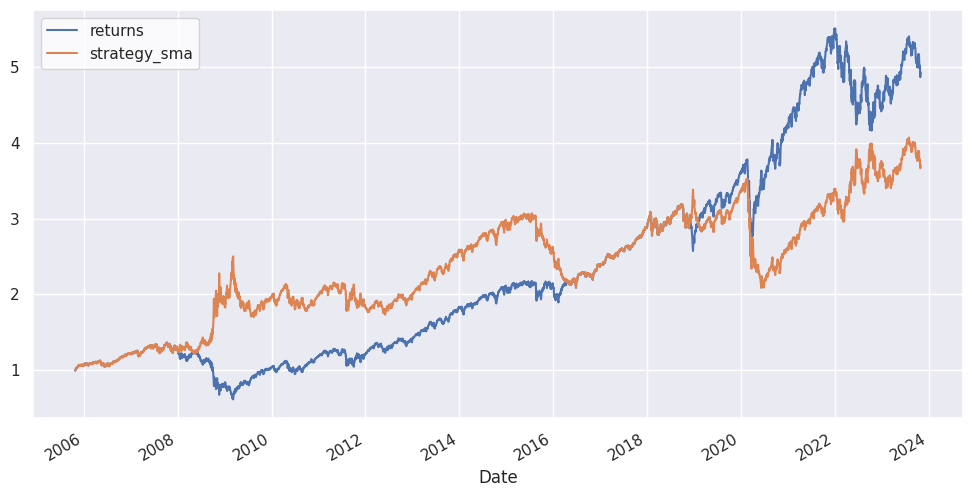

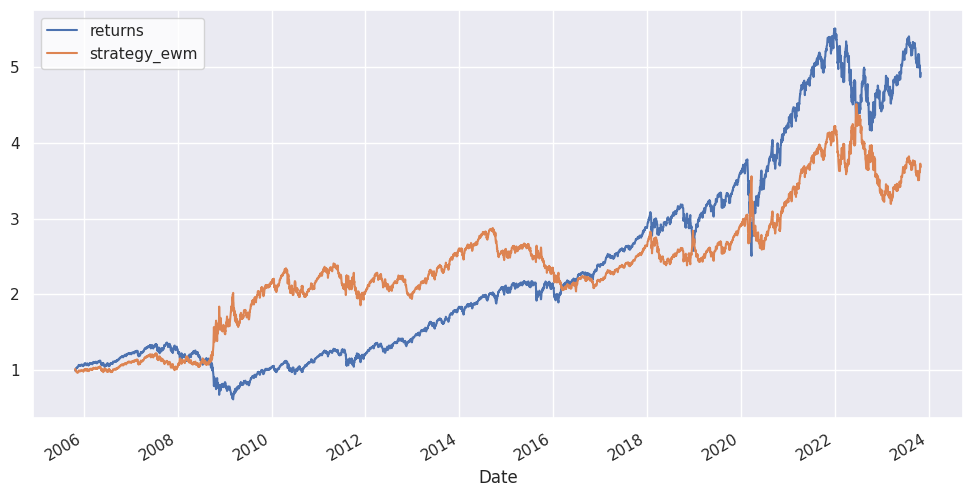

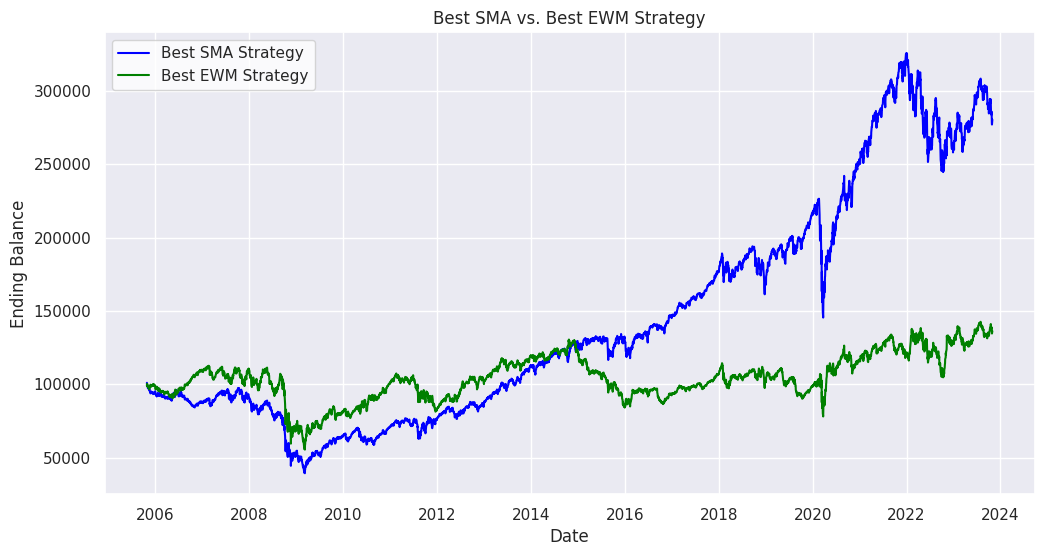

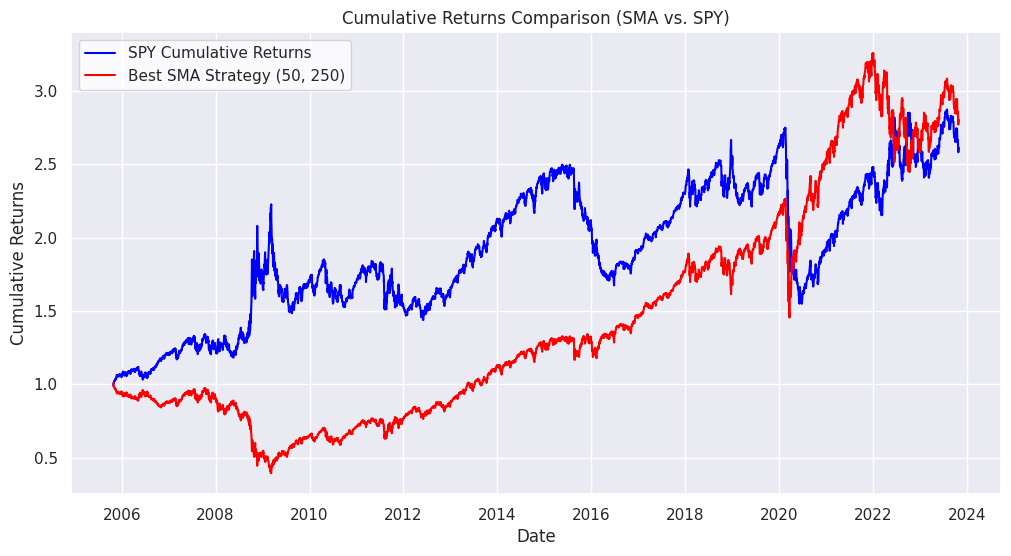

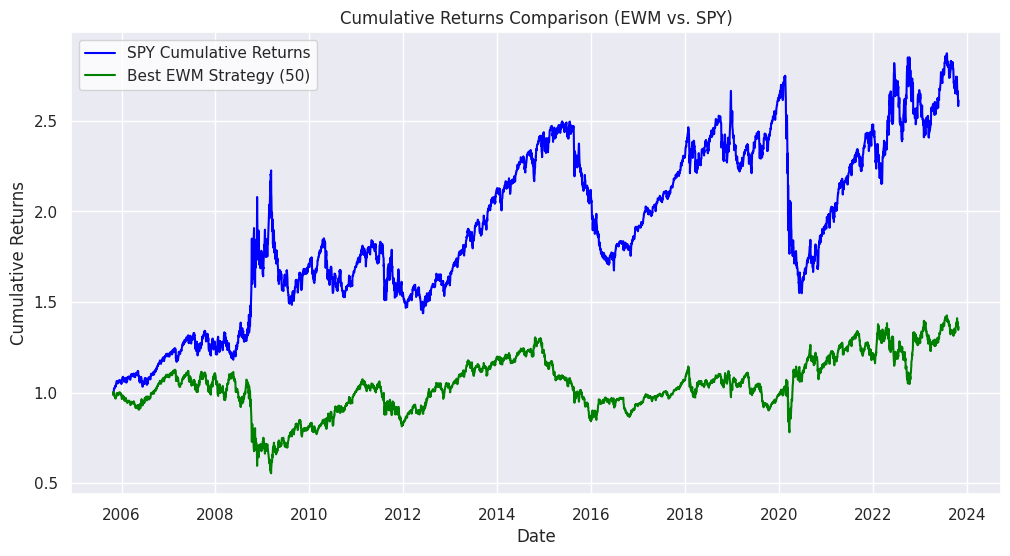

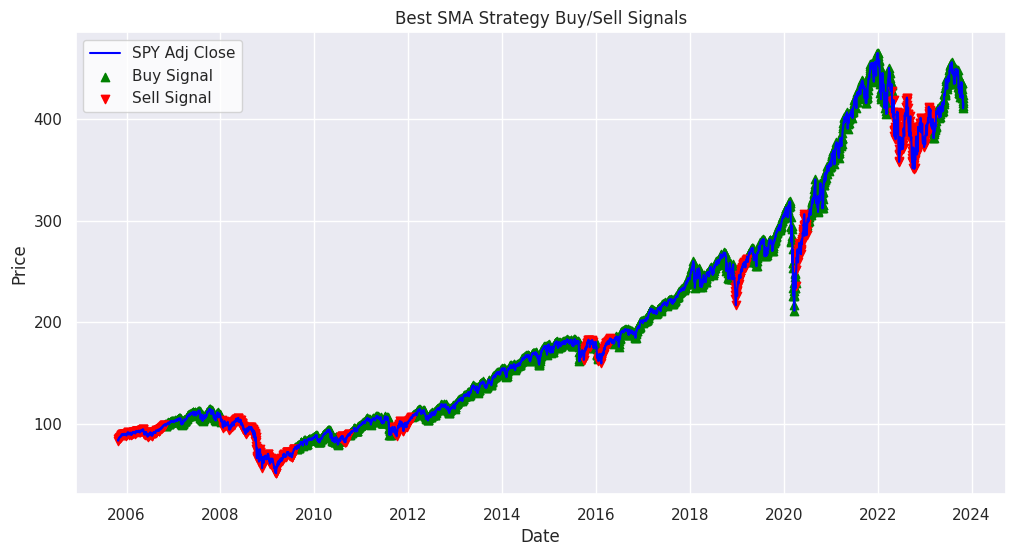

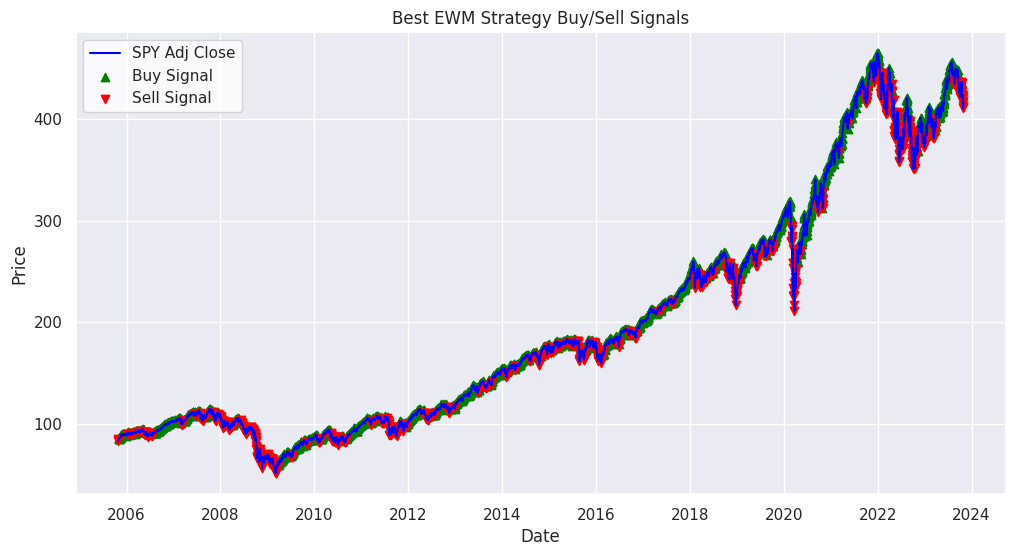

Strategy  Short Period  Long Period  Span  Sharpe Ratio      CAGR  \
0  Best SMA Strategy          50.0        250.0   NaN      0.390528  0.137033   
1  Best EWM Strategy           NaN          NaN  50.0      0.186459  0.137033   

   Max Drawdown Max Drawdown Period (days)  Ending Balance  \
0      2.057693                  1712 days   397876.233157   
1      3.046543                  1918 days   193383.496672   

   Annualized Volatility      Total P&L  Cumulative Returns  
0               0.197407  138097.079897            3.709607  
1               0.197453   65950.506077            3.681525

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib as mpl
# import datetime as dt
# from pandas_datareader import data as pdr
# import yfinance as yf

# Set options
# np.set_printoptions(precision=3)
# plt.style.use("ggplot")
# mpl.rcParams.update({
#     "axes.grid": True,
#     "grid.color": "grey",
#     "grid.alpha": 0.25,
#     "axes.facecolor": "white",
#     "legend.fontsize": 14
# })

# Load S&P 500 data
spy_data = yf.download('SPY', start='2004-11-01', end='2023-10-31').drop(['High', 'Low', 'Open', 'Close', 'Volume'], axis=1)
initial_capital = 100000

# Define parameter ranges
short_window_range = range(10, 51, 10)
long_window_range = range(100, 251, 50)
ewm_span_range = range(10, 51, 10)

# Calculate rolling and exponential moving averages
for short_window in short_window_range:
    spy_data[f"short_mean_{short_window}"] = spy_data["Adj Close"].rolling(window=short_window).mean()

for long_window in long_window_range:
    spy_data[f"long_mean_{long_window}"] = spy_data["Adj Close"].rolling(window=long_window).mean()

for span_range in ewm_span_range:
    spy_data[f"span_mean_{span_range}"] = spy_data["Adj Close"].ewm(span=span_range).mean()

# Calculate SMA positions
spy_data["positions_sma"] = np.where(spy_data["short_mean_40"] > spy_data["long_mean_250"], 1, -1)

# Calculate EWM positions
spy_data["positions_ewm"] = np.where(spy_data["span_mean_40"] > spy_data["span_mean_50"], 1, -1)

# Drop NaN values
spy_data = spy_data.dropna()

# Plot SMA
ax_sma = (spy_data[["Adj Close", "short_mean_40", "long_mean_250", "positions_sma"]]
          .plot(secondary_y="positions_sma", style=["grey", "green", "red", "blue"], figsize=[18, 6]))

ax_sma.legend(loc="upper center", shadow=True, ncol=4, bbox_to_anchor=(0.55, 1.10), fancybox=True)

# Plot EWM
ax_ewm = (spy_data[["Adj Close", "span_mean_40", "span_mean_50", "positions_ewm"]]
          .plot(secondary_y="positions_ewm", style=["grey", "green", "red", "blue"], figsize=[18, 6]))

ax_ewm.legend(loc="upper center", shadow=True, ncol=4, bbox_to_anchor=(0.55, 1.10), fancybox=True)

# Calculate log returns
spy_data["log_returns"] = np.log(spy_data["Adj Close"] / spy_data["Adj Close"].shift(1))

# Calculate strategy returns for SMA and EWM
spy_data["strategy_returns_sma"] = spy_data["positions_sma"].shift(1) * spy_data["log_returns"]
spy_data["strategy_returns_ewm"] = spy_data["positions_ewm"].shift(1) * spy_data["log_returns"]

# Plot cumulative returns for SMA
(spy_data[["log_returns", "strategy_returns_sma"]].cumsum().apply(np.exp)
 .plot(figsize=[12, 6]))

# Plot cumulative returns for EWM
(spy_data[["log_returns", "strategy_returns_ewm"]].cumsum().apply(np.exp)
 .plot(figsize=[12, 6]))

# Calculate and plot cumulative returns with max gross performance for SMA
spy_data["cumulative_returns_sma"] = spy_data["strategy_returns_sma"].cumsum().apply(np.exp)
spy_data["max_gross_performance_sma"] = spy_data["cumulative_returns_sma"].cummax()
(spy_data[["cumulative_returns_sma", "max_gross_performance_sma"]].dropna()
 .plot(figsize=[12, 6]))

# Calculate and plot cumulative returns with max gross performance for EWM
spy_data["cumulative_returns_ewm"] = spy_data["strategy_returns_ewm"].cumsum().apply(np.exp)
spy_data["max_gross_performance_ewm"] = spy_data["cumulative_returns_ewm"].cummax()
(spy_data[["cumulative_returns_ewm", "max_gross_performance_ewm"]].dropna()
 .plot(figsize=[12, 6]))

# Calculate returns and plot
spy_data["returns"] = np.log(spy_data["Adj Close"] / spy_data["Adj Close"].shift(1))
(spy_data[["returns", "strategy_returns_sma"]].dropna().cumsum().apply(np.exp)
 .plot(figsize=[12, 6]))

(spy_data[["returns", "strategy_returns_ewm"]].dropna().cumsum().apply(np.exp)
 .plot(figsize=[12, 6]))

# Calculate strategy return for SMA and EWM
spy_data["strategy_sma"] = spy_data["positions_sma"].shift(1) * spy_data["returns"]
spy_data["strategy_ewm"] = spy_data["positions_ewm"].shift(1) * spy_data["returns"]

(spy_data[["returns", "strategy_sma"]].dropna().cumsum().apply(np.exp)
 .plot(figsize=[12, 6]))

(spy_data[["returns", "strategy_ewm"]].dropna().cumsum().apply(np.exp)
 .plot(figsize=[12, 6]))

# Calculate days and CAGR
days = (spy_data.index[-1] - spy_data.index[0]).days
# CAGR = ((spy_data["Adj Close"][-1] / spy_data["Adj Close"][0]) ** (365.0 / days)) - 1

##########################################################################################################################################


# # Define initial capital
# initial_capital = 100000

# Define a function to calculate performance metrics
def calculate_metrics(data, strategy_name, initial_capital=100000):
    strategy_returns_column = f'Strategy Returns_{strategy_name}'
    max_gross_performance_column = f'max_gross_performance_{strategy_name}'  # Use the correct max_gross_performance column
    sharpe_ratio = (data[strategy_returns_column].mean() / data[strategy_returns_column].std()) * np.sqrt(253)
    cumulative_returns = data[strategy_returns_column].cumsum().apply(np.exp)
    cagr = ((((data["Adj Close"][-1]) / (data["Adj Close"][0])) ** (365.0 / len(data.index))) - 1)
    rolling_max = cumulative_returns.cummax()

    # Use the correct max_gross_performance column
    drawdown = data[max_gross_performance_column] - cumulative_returns
    max_drawdown = drawdown.max()
    total_pnl = (data[strategy_returns_column].sum()) * initial_capital
    annualized_volatility = data[strategy_returns_column].std() * np.sqrt(253)
    ending_balance = cumulative_returns.iloc[-1] * initial_capital

    return sharpe_ratio, cagr, max_drawdown, ending_balance, annualized_volatility, total_pnl

# Initialize lists to store strategy metrics
sma_sharpe_ratios = []
sma_cagrs = []
sma_max_drawdowns = []
sma_max_drawdown_periods = []  # Add a list to store maximum drawdown periods
sma_ending_balances = []
sma_cumulative_returns = []
sma_annualized_volatilities = []
sma_total_pnls = []

ewm_sharpe_ratios = []
ewm_cagrs = []
ewm_max_drawdowns = []
ewm_max_drawdown_periods = []  # Add a list to store maximum drawdown periods
ewm_ending_balances = []
ewm_cumulative_returns = []
ewm_annualized_volatilities = []
ewm_total_pnls = []

# Define a range for short and long periods to test for SMA
short_window_range = range(10, 51, 10)  # Range from 10 to 50 with a step of 10
long_window_range = range(100, 251, 50)  # Range from 100 to 250 with a step of 50.

# Define a range of span values to test for EWM
ewm_span_range = range(10, 51, 10)  # Range from 10 to 50 with a step of 10

# Iterate through different combinations of SMA short and long periods
for sma_short_period in short_window_range:
    for sma_long_period in long_window_range:
        sma_strategy_data = spy_data.copy()
        sma_strategy_data['SMA Short'] = sma_strategy_data['Adj Close'].rolling(sma_short_period).mean()
        sma_strategy_data['SMA Long'] = sma_strategy_data['Adj Close'].rolling(sma_long_period).mean()
        sma_strategy_data['Signal'] = np.where(sma_strategy_data['SMA Short'] > sma_strategy_data['SMA Long'], 1, -1)
        sma_strategy_data['Position_sma'] = sma_strategy_data['Signal'].shift(1)
        sma_strategy_data['Strategy Returns_sma'] = sma_strategy_data['Position_sma'] * sma_strategy_data['strategy_returns_sma']

        # Calculate ending balance based on initial capital
        sma_strategy_data['Ending Balance'] = initial_capital * (sma_strategy_data['Strategy Returns_sma'] + 1).cumprod()

        sma_sharpe, sma_cagr, sma_max_dd, sma_ending_balance, sma_annualized_volatility, sma_total_pnl = calculate_metrics(
            sma_strategy_data, "sma", initial_capital)

        # Calculate the drawdown periods for SMA strategy
        drawdown = sma_strategy_data["max_gross_performance_sma"] - sma_strategy_data["cumulative_returns_sma"]
        periods = (
            drawdown[drawdown == 0].index[1:].to_pydatetime()
            - drawdown[drawdown == 0].index[:-1].to_pydatetime()
        )

        sma_sharpe_ratios.append(sma_sharpe)
        sma_cagrs.append(sma_cagr)
        sma_max_drawdowns.append(sma_max_dd)
        sma_max_drawdown_periods.append(periods.max())  # Store the maximum drawdown period
        sma_ending_balances.append(sma_ending_balance)
        sma_cumulative_returns.append(sma_strategy_data['cumulative_returns_sma'].iloc[-1])
        sma_annualized_volatilities.append(sma_annualized_volatility)
        sma_total_pnls.append(sma_total_pnl)

# Iterate through different span values for EWM
for ewm_span in ewm_span_range:
    ewm_strategy_data = spy_data.copy()
    ewm_strategy_data['Signal'] = np.where(ewm_strategy_data['Adj Close'] > ewm_strategy_data['Adj Close'].ewm(span=ewm_span).mean(), 1, -1)
    ewm_strategy_data['Position_ewm'] = ewm_strategy_data['Signal'].shift(1)
    ewm_strategy_data['Strategy Returns_ewm'] = ewm_strategy_data['Position_ewm'] * ewm_strategy_data['strategy_returns_ewm']

    # Calculate ending balance based on initial capital
    ewm_strategy_data['Ending Balance'] = initial_capital * (ewm_strategy_data['Strategy Returns_ewm'] + 1).cumprod()

    ewm_sharpe, ewm_cagr, ewm_max_dd, ewm_ending_balance, ewm_annualized_volatility, ewm_total_pnl = calculate_metrics(
        ewm_strategy_data, "ewm", initial_capital)

    # Calculate the drawdown periods for EWM strategy
    drawdown = ewm_strategy_data["max_gross_performance_ewm"] - ewm_strategy_data["cumulative_returns_ewm"]
    periods = (
        drawdown[drawdown == 0].index[1:].to_pydatetime()
        - drawdown[drawdown == 0].index[:-1].to_pydatetime()
    )

    ewm_sharpe_ratios.append(ewm_sharpe)
    ewm_cagrs.append(ewm_cagr)
    ewm_max_drawdowns.append(ewm_max_dd)
    ewm_max_drawdown_periods.append(periods.max())  # Store the maximum drawdown period
    ewm_ending_balances.append(ewm_ending_balance)
    ewm_cumulative_returns.append(ewm_strategy_data['cumulative_returns_ewm'].iloc[-1])
    ewm_annualized_volatilities.append(ewm_annualized_volatility)
    ewm_total_pnls.append(ewm_total_pnl)

# Find the best combination of SMA short and long periods based on Sharpe Ratio
best_sma_index = np.argmax(sma_sharpe_ratios)
best_sma_short_period = short_window_range[best_sma_index // len(long_window_range)]
best_sma_long_period = long_window_range[best_sma_index % len(long_window_range)]

# Find the best span value for EWM based on Sharpe Ratio
best_ewm_index = np.argmax(ewm_sharpe_ratios)
best_ewm_span = ewm_span_range[best_ewm_index]

# Find the best cumulative returns for SMA and EMA strategies
best_sma_cumulative_return_index = np.argmax(sma_cumulative_returns)
best_ewm_cumulative_return_index = np.argmax(ewm_cumulative_returns)
best_sma_cumulative_return = sma_cumulative_returns[best_sma_cumulative_return_index]
best_ewm_cumulative_return = ewm_cumulative_returns[best_ewm_cumulative_return_index]

# Print the best SMA and EMA strategy's metrics along with maximum drawdown periods and cumulative returns
print(f"Best SMA Strategy - Short Period: {best_sma_short_period}, Long Period: {best_sma_long_period}")
print(f"Sharpe Ratio: {sma_sharpe_ratios[best_sma_index]}, CAGR: {sma_cagrs[best_sma_index]}, Max Drawdown: {sma_max_drawdowns[best_sma_index]}, Max Drawdown Period: {sma_max_drawdown_periods[best_sma_index]} days, Ending Balance: ${sma_ending_balances[best_sma_index]:,.2f}, Annualized Volatility: {sma_annualized_volatilities[best_sma_index]:.4f}, Total P&L: ${sma_total_pnls[best_sma_index]:,.2f}, Cumulative Returns: {sma_cumulative_returns[best_sma_index]:.4f}")

print()

print(f"Best EWM Strategy - Span: {best_ewm_span}")
print(f"Sharpe Ratio: {ewm_sharpe_ratios[best_ewm_index]}, CAGR: {ewm_cagrs[best_ewm_index]}, Max Drawdown: {ewm_max_drawdowns[best_ewm_index]}, Max Drawdown Period: {ewm_max_drawdown_periods[best_ewm_index]} days, Ending Balance: ${ewm_ending_balances[best_ewm_index]:,.2f}, Annualized Volatility: {ewm_annualized_volatilities[best_ewm_index]:.4f}, Total P&L: ${ewm_total_pnls[best_ewm_index]:,.2f}, Cumulative Returns: {ewm_cumulative_returns[best_ewm_index]:.4f}")

# Plot the best SMA and EMA strategies
best_sma_strategy_data = spy_data.copy()
best_sma_strategy_data['SMA Short'] = best_sma_strategy_data['Adj Close'].rolling(best_sma_short_period).mean()
best_sma_strategy_data['SMA Long'] = best_sma_strategy_data['Adj Close'].rolling(best_sma_long_period).mean()
best_sma_strategy_data['Signal'] = np.where(best_sma_strategy_data['SMA Short'] > best_sma_strategy_data['SMA Long'], 1, -1)
best_sma_strategy_data['Position_sma'] = best_sma_strategy_data['Signal'].shift(1)
best_sma_strategy_data['Strategy Returns_sma'] = best_sma_strategy_data['Position_sma'] * best_sma_strategy_data['strategy_returns_sma']
best_sma_strategy_data['Ending Balance'] = initial_capital * (best_sma_strategy_data['Strategy Returns_sma'] + 1).cumprod()

best_ewm_strategy_data = spy_data.copy()
best_ewm_strategy_data['Signal'] = np.where(best_ewm_strategy_data['Adj Close'] > best_ewm_strategy_data['Adj Close'].ewm(span=best_ewm_span).mean(), 1, -1)
best_ewm_strategy_data['Position_ewm'] = best_ewm_strategy_data['Signal'].shift(1)
best_ewm_strategy_data['Strategy Returns_ewm'] = best_ewm_strategy_data['Position_ewm'] * best_ewm_strategy_data['strategy_returns_ewm']
best_ewm_strategy_data['Ending Balance'] = initial_capital * (best_ewm_strategy_data['Strategy Returns_ewm'] + 1).cumprod()

plt.figure(figsize=(12, 6))
plt.title('Best SMA vs. Best EWM Strategy')
plt.plot(best_sma_strategy_data.index, best_sma_strategy_data['Ending Balance'], label='Best SMA Strategy', color='blue')
plt.plot(best_ewm_strategy_data.index, best_ewm_strategy_data['Ending Balance'], label='Best EWM Strategy', color='green')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Ending Balance')
plt.show()


# Visualize the performance of the best SMA and EWM strategies
plt.figure(figsize=(12, 6))

# Visualize the performance of the best SMA strategy
best_sma_strategy_data = spy_data.copy()
best_sma_strategy_data['SMA Short'] = best_sma_strategy_data['Adj Close'].rolling(best_sma_short_period).mean()
best_sma_strategy_data['SMA Long'] = best_sma_strategy_data['Adj Close'].rolling(best_sma_long_period).mean()
best_sma_strategy_data['Signal'] = np.where(best_sma_strategy_data['SMA Short'] > best_sma_strategy_data['SMA Long'], 1, -1)
best_sma_strategy_data['Position'] = best_sma_strategy_data['Signal'].shift(1)
best_sma_strategy_data['Strategy Returns'] = best_sma_strategy_data['Position'] * best_sma_strategy_data['strategy_returns_sma']

# Calculate cumulative SPY returns
spy_data['Cumulative Returns'] = (spy_data['strategy_returns_sma'] + 1).cumprod()

# Calculate cumulative returns for the best SMA strategy
best_sma_strategy_data['Cumulative Strategy Returns'] = (best_sma_strategy_data['Strategy Returns'] + 1).cumprod()

# Plot cumulative returns for SPY and the best SMA strategy
plt.plot(spy_data.index, spy_data['Cumulative Returns'], label='SPY Cumulative Returns', color='blue')
plt.plot(best_sma_strategy_data.index, best_sma_strategy_data['Cumulative Strategy Returns'], label=f'Best SMA Strategy ({best_sma_short_period}, {best_sma_long_period})', color='red')

plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.title('Cumulative Returns Comparison (SMA vs. SPY)')
plt.show()

# Visualize the performance of the best EWM strategy
best_ewm_strategy_data = spy_data.copy()
best_ewm_strategy_data['Signal'] = np.where(best_ewm_strategy_data['Adj Close'] > best_ewm_strategy_data['Adj Close'].ewm(span=best_ewm_span).mean(), 1, -1)
best_ewm_strategy_data['Position'] = best_ewm_strategy_data['Signal'].shift(1)
best_ewm_strategy_data['Strategy Returns'] = best_ewm_strategy_data['Position'] * best_ewm_strategy_data['strategy_returns_ewm']

# Calculate cumulative returns for the best EWM strategy
best_ewm_strategy_data['Cumulative Strategy Returns'] = (best_ewm_strategy_data['Strategy Returns'] + 1).cumprod()

# Plot cumulative returns for SPY and the best EWM strategy
plt.figure(figsize=(12, 6))
plt.plot(spy_data.index, spy_data['Cumulative Returns'], label='SPY Cumulative Returns', color='blue')
plt.plot(best_ewm_strategy_data.index, best_ewm_strategy_data['Cumulative Strategy Returns'], label=f'Best EWM Strategy ({best_ewm_span})', color='green')

plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.title('Cumulative Returns Comparison (EWM vs. SPY)')
plt.show()


# Visualize the performance of the best SMA strategy with buy/sell signals
plt.figure(figsize=(12, 6))

# Visualize the performance of the best SMA strategy with buy/sell signals
best_sma_strategy_data['Buy Signal'] = np.where(best_sma_strategy_data['Position'] == 1, best_sma_strategy_data['Adj Close'], np.nan)
best_sma_strategy_data['Sell Signal'] = np.where(best_sma_strategy_data['Position'] == -1, best_sma_strategy_data['Adj Close'], np.nan)

# Plot the adjusted closing price of SPY
plt.plot(spy_data.index, spy_data['Adj Close'], label='SPY Adj Close', color='blue')

# Plot buy and sell signals for the best SMA strategy
plt.scatter(best_sma_strategy_data.index, best_sma_strategy_data['Buy Signal'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(best_sma_strategy_data.index, best_sma_strategy_data['Sell Signal'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title('Best SMA Strategy Buy/Sell Signals')
plt.show()

# Visualize the performance of the best EWM strategy with buy/sell signals
plt.figure(figsize=(12, 6))

best_ewm_strategy_data['Buy Signal'] = np.where(best_ewm_strategy_data['Position'] == 1, best_ewm_strategy_data['Adj Close'], np.nan)
best_ewm_strategy_data['Sell Signal'] = np.where(best_ewm_strategy_data['Position'] == -1, best_ewm_strategy_data['Adj Close'], np.nan)

# Plot the adjusted closing price of SPY
plt.plot(spy_data.index, spy_data['Adj Close'], label='SPY Adj Close', color='blue')

# Plot buy and sell signals for the best EWM strategy
plt.scatter(best_ewm_strategy_data.index, best_ewm_strategy_data['Buy Signal'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(best_ewm_strategy_data.index, best_ewm_strategy_data['Sell Signal'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title('Best EWM Strategy Buy/Sell Signals')
plt.show()

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    "Strategy": ["Best SMA Strategy", "Best EWM Strategy"],
    "Short Period": [best_sma_short_period, None],
    "Long Period": [best_sma_long_period, None],
    "Span": [None, best_ewm_span],
    "Sharpe Ratio": [sma_sharpe_ratios[best_sma_index], ewm_sharpe_ratios[best_ewm_index]],
    "CAGR": [sma_cagrs[best_sma_index], ewm_cagrs[best_ewm_index]],
    "Max Drawdown": [sma_max_drawdowns[best_sma_index], ewm_max_drawdowns[best_ewm_index]],
    "Max Drawdown Period (days)": [sma_max_drawdown_periods[best_sma_index], ewm_max_drawdown_periods[best_ewm_index]],
    "Ending Balance": [sma_ending_balances[best_sma_index], ewm_ending_balances[best_ewm_index]],
    "Annualized Volatility": [sma_annualized_volatilities[best_sma_index], ewm_annualized_volatilities[best_ewm_index]],
    "Total P&L": [sma_total_pnls[best_sma_index], ewm_total_pnls[best_ewm_index]],
    "Cumulative Returns": [sma_cumulative_returns[best_sma_index], ewm_cumulative_returns[best_ewm_index]]
})

# Print the DataFrame
display(results_df)

2. MACD

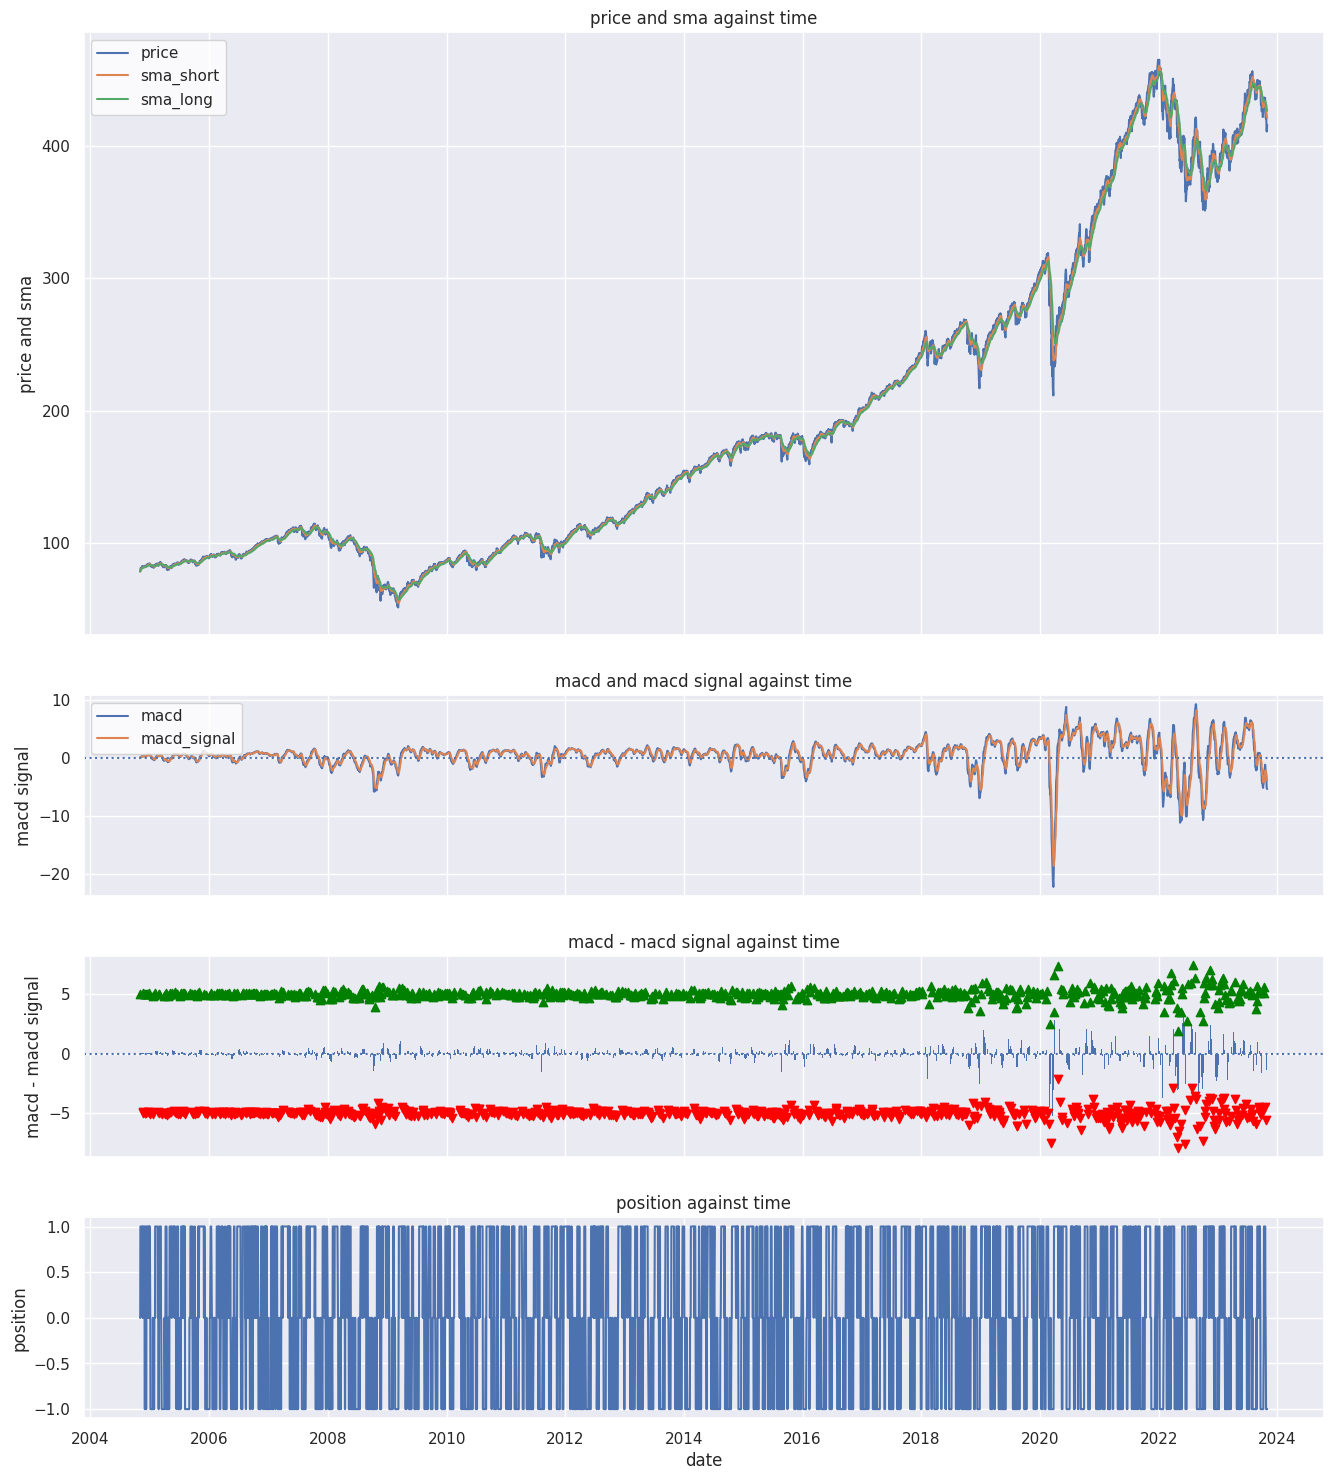

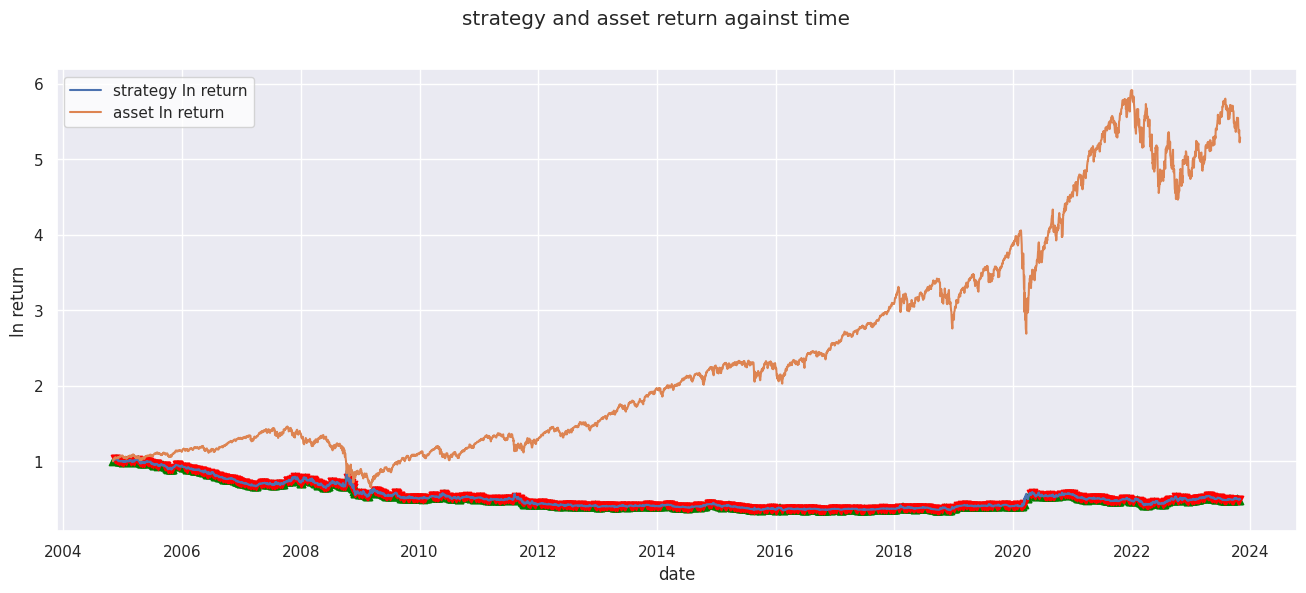

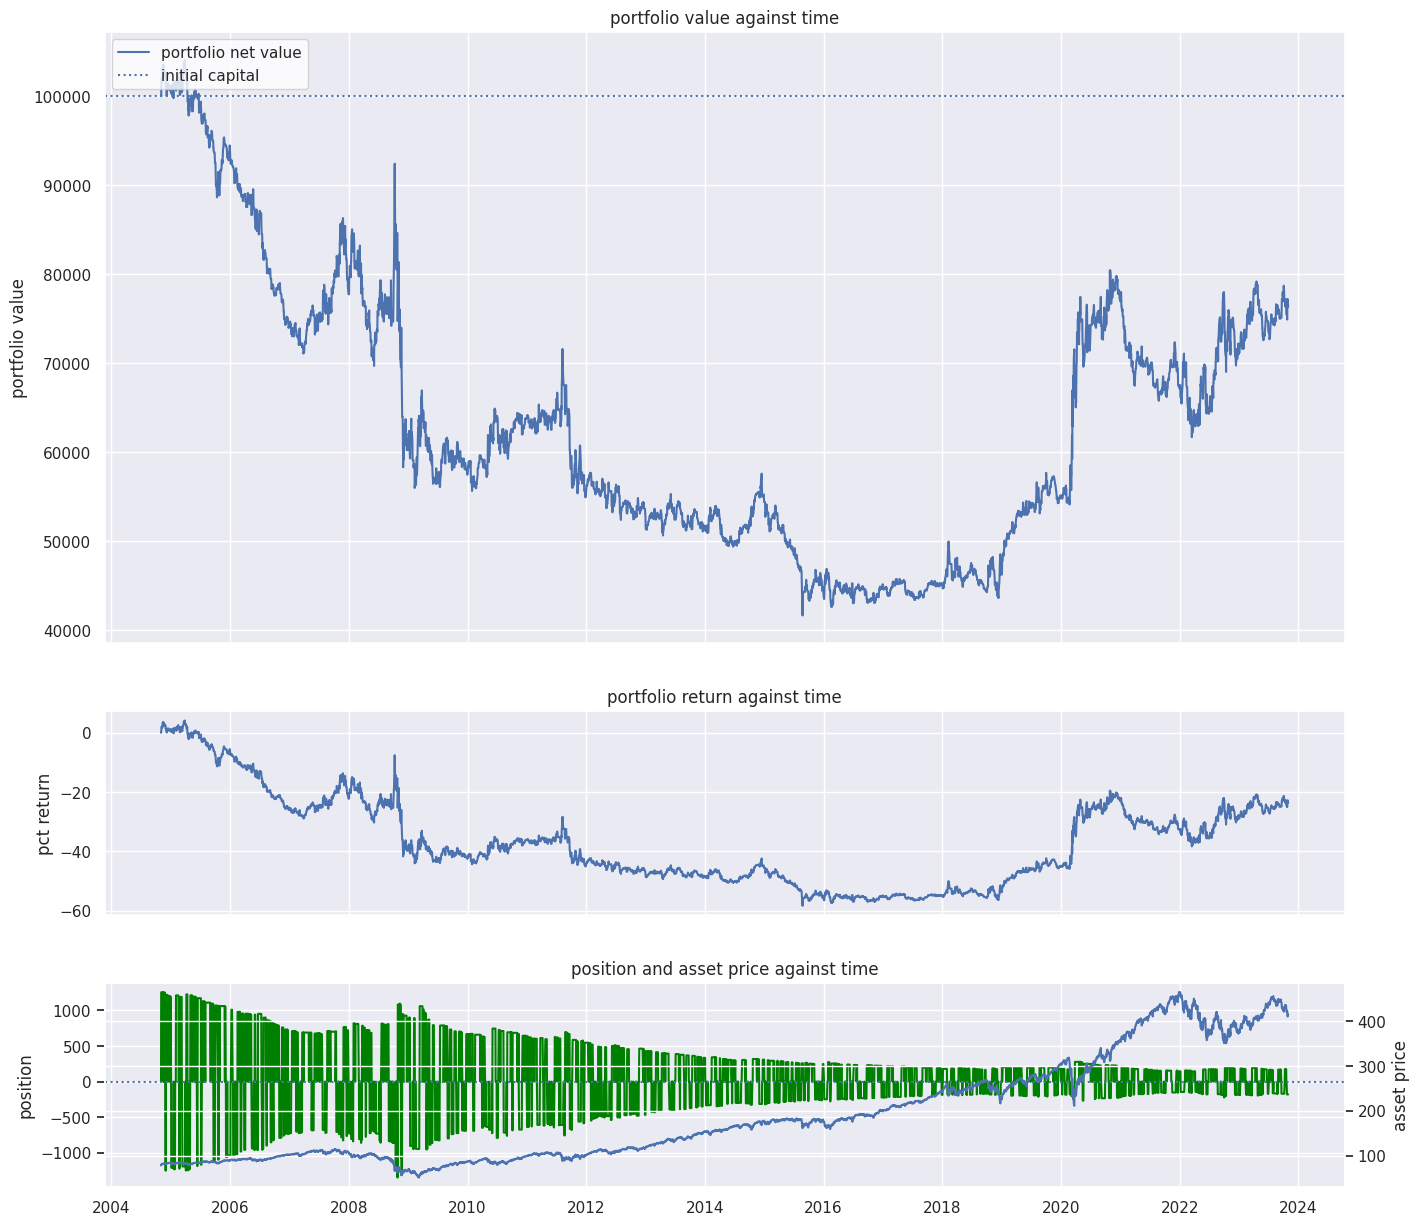

{'value_final': 76328.73003387451, 'ret_portfolio': -0.23671269966125486, 'return': -0.01413388643316249, 'volatility': 0.16214538262648595, 'sharpe': -0.08716798594086986, 'cagr': -0.014112259396324767}

=== MAX DRAWDOWN ON SORT BY MAX VALUES ===
              return  drawdown  drawdown_max  drawdown_period
date                                                         
2015-08-25 -0.583570 -0.624532     -0.624532  0 days 00:00:00
2015-08-24 -0.578627 -0.619590     -0.619590  0 days 00:00:00
2015-08-21 -0.560166 -0.601128     -0.601128  0 days 00:00:00
2015-08-20 -0.546558 -0.587520     -0.587520  0 days 00:00:00
2015-08-19 -0.536917 -0.577879     -0.577879  0 days 00:00:00

=== MAX DRAWDOWN ON DRAWDOWN PERIOD ===
              return  drawdown  drawdown_max     drawdown_period
date                                                            
2023-10-30 -0.236713 -0.277675     -0.624532  2988 days 00:00:00
2011-11-08 -0.425143 -0.466106     -0.484670   648 days 00:00:00
2008-05-20 -0.280

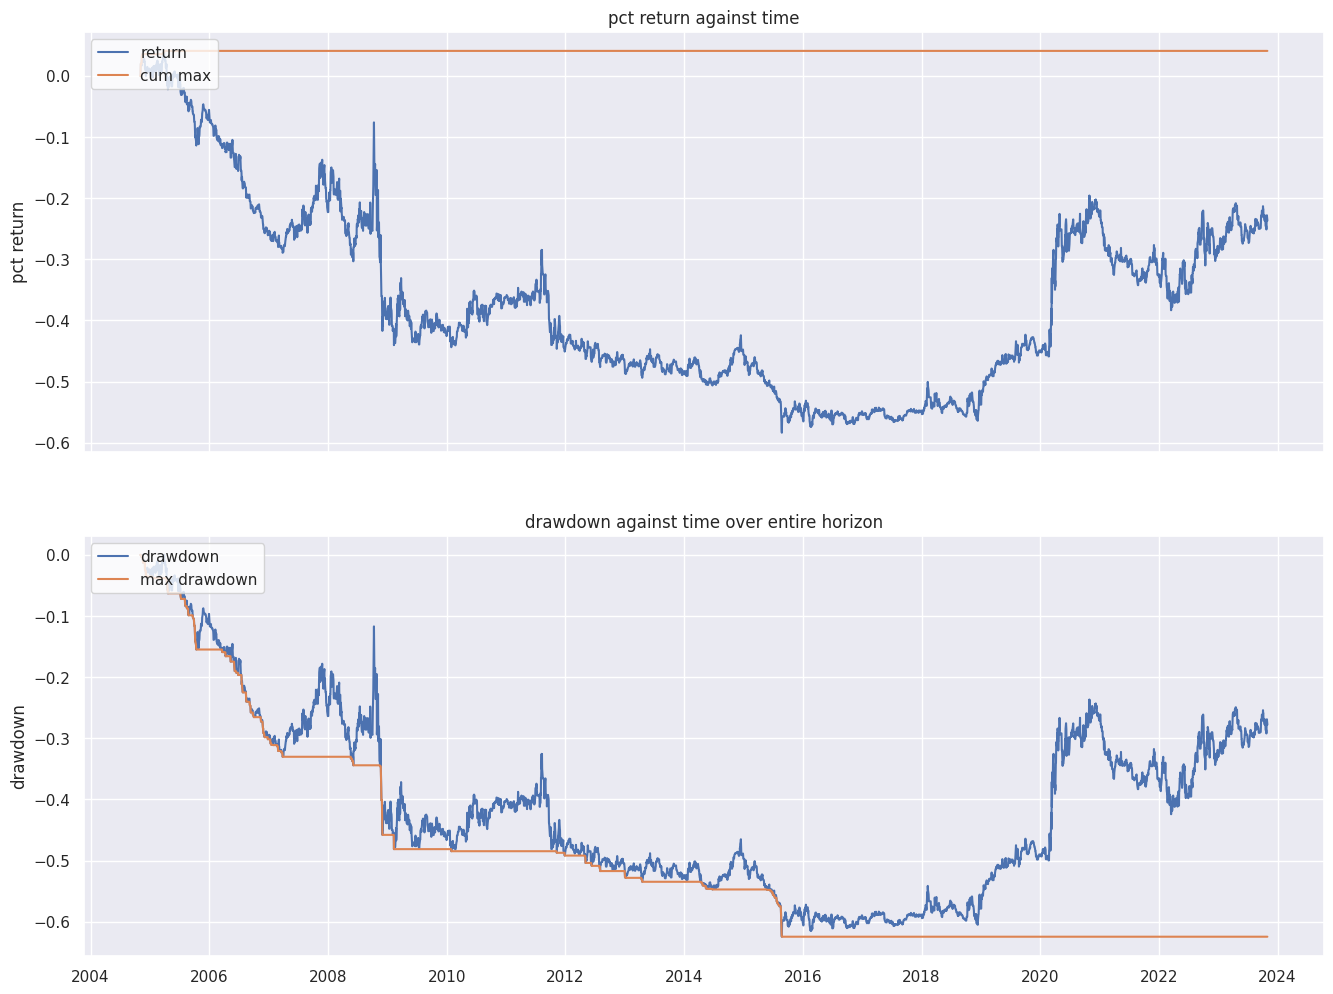

In [ ]:
def getMacdTradingStrategy(df, *,
    key_value : str             = "price",
    period_ma_short : int       = 12,
    period_ma_long : int        = 26,
    period_macd_window : int    = 9,
    short_sell_allowed  : bool  = True,
    plot : bool                 = True
):
    df  = df_sp500_price.copy()
    df["sma_short"]       = df[key_value].ewm(span = period_ma_short, min_periods = 1).mean()
    df["sma_long"]        = df[key_value].ewm(span = period_ma_long, min_periods = 1).mean()
    df["macd"]            = df.sma_short - df.sma_long
    df["macd_signal"]     = df.macd.ewm(span = period_macd_window, min_periods = 1).mean()

    # df["sma_short"]       = df[key_value].rolling(window = period_ma_short, min_periods = 1).mean()
    # df["sma_long"]        = df[key_value].rolling(window = period_ma_long, min_periods = 1).mean()
    # df["macd"]            = df.sma_short - df.sma_long
    # df["macd_signal"]     = df.macd.rolling(window = period_macd_window, min_periods = 1).mean()

    df["bull_signal"]  = (
      (df.macd > df.macd.shift(periods = 1))
      & (df.macd > df.macd_signal)
    )
    df["bear_signal"]  = (
      (df.macd < df.macd.shift(periods = 1))
      & (df.macd < df.macd_signal)
    )
    if short_sell_allowed:
      df["signal"]  = df.bull_signal * 1 + df.bear_signal * -1
    else:
      df["signal"]  = df.bull_signal * 1

    df["position"]  = df.signal.shift(periods = 1).fillna(0)
    df["trade"]     = df.position - df.position.shift(periods = 1).fillna(0)

    if plot:
      fig, axes = plt.subplots(
          nrows   = 4,
          sharex  = True,
          figsize = (16, 18),
          height_ratios = [3, 1, 1, 1]
      )

      ax  = axes[0]
      ax.plot(
          df[["price", "sma_short", "sma_long"]],
          label = ["price", "sma_short", "sma_long"]
      )
      ax.legend()
      ax.set_ylabel("price and sma")
      ax.set_title("price and sma against time")

      ax  = axes[1]
      ax.plot(
          df[["macd", "macd_signal"]],
          label = ["macd", "macd_signal"]
      )
      ax.axhline(
          0.0,
          linestyle = "dotted"
      )
      ax.legend()
      ax.set_ylabel("macd signal")
      ax.set_title("macd and macd signal against time")

      ax  = axes[2]
      ax.bar(
          df.index,
          df["macd"] - df["macd_signal"],
          lw  = 0
      )
      ax.scatter(
          df[df.trade > 0].index,
          (df[df.trade > 0].macd - df[df.trade > 0].macd_signal) + 5,
          marker  = "^",
          color   = "green"
      )
      ax.scatter(
          df[df.trade < 0].index,
          (df[df.trade < 0].macd - df[df.trade < 0].macd_signal) - 5,
          marker  = "v",
          color   = "red"
      )
      ax.axhline(
          0.0,
          linestyle = "dotted"
      )
      ax.set_ylabel("macd - macd signal")
      ax.set_title("macd - macd signal against time")

      ax  = axes[3]
      ax.plot(
          df.position
      )
      ax.set_ylabel("position")
      ax.set_title("position against time")
      plt.xlabel("date")
      plt.show()

    return df

df_sp500_macd_both  = getMacdTradingStrategy(df_sp500_price_bkup.copy())
df_sp500_macd_both  = getReturnPerPositionStrategy(df_sp500_macd_both)
### When long, buy max number of stocks with available cash
### When short sell, loan max number of stocks using available cash as leverage
df_sp500_macd_both  = getTradingReturn(df_sp500_macd_both, capital_initial = 10 **5)

measure_sp500_macd_both = getSharpeRatio(df_sp500_macd_both.ret_portfolio_pct)
dict_measure_sp500_macd_both  = {
    "value_final"   : df_sp500_macd_both.iloc[-1]["value_total"],
    "ret_portfolio" : df_sp500_macd_both.iloc[-1]["ret_portfolio"],
    "return"        : measure_sp500_macd_both[1],
    "volatility"    : measure_sp500_macd_both[2],
    "sharpe"        : measure_sp500_macd_both[0],
    "cagr"          : getCagr(df_sp500_macd_both.ret_portfolio)
}
print(dict_measure_sp500_macd_both)

df_sp500_macd_both_dd = getDrawdownDf(df_sp500_macd_both.ret_portfolio_pct) #, window = 252)
print("\n=== MAX DRAWDOWN ON SORT BY MAX VALUES ===")
print(df_sp500_macd_both_dd.drop_duplicates(subset = "drawdown_max", keep = "first").sort_values(by = "drawdown_max", ascending = True).head(5))
print("\n=== MAX DRAWDOWN ON DRAWDOWN PERIOD ===")
print(df_sp500_macd_both_dd.drop_duplicates(subset = "drawdown_max", keep = "last").sort_values(by = "drawdown_period", ascending = False).head(5))


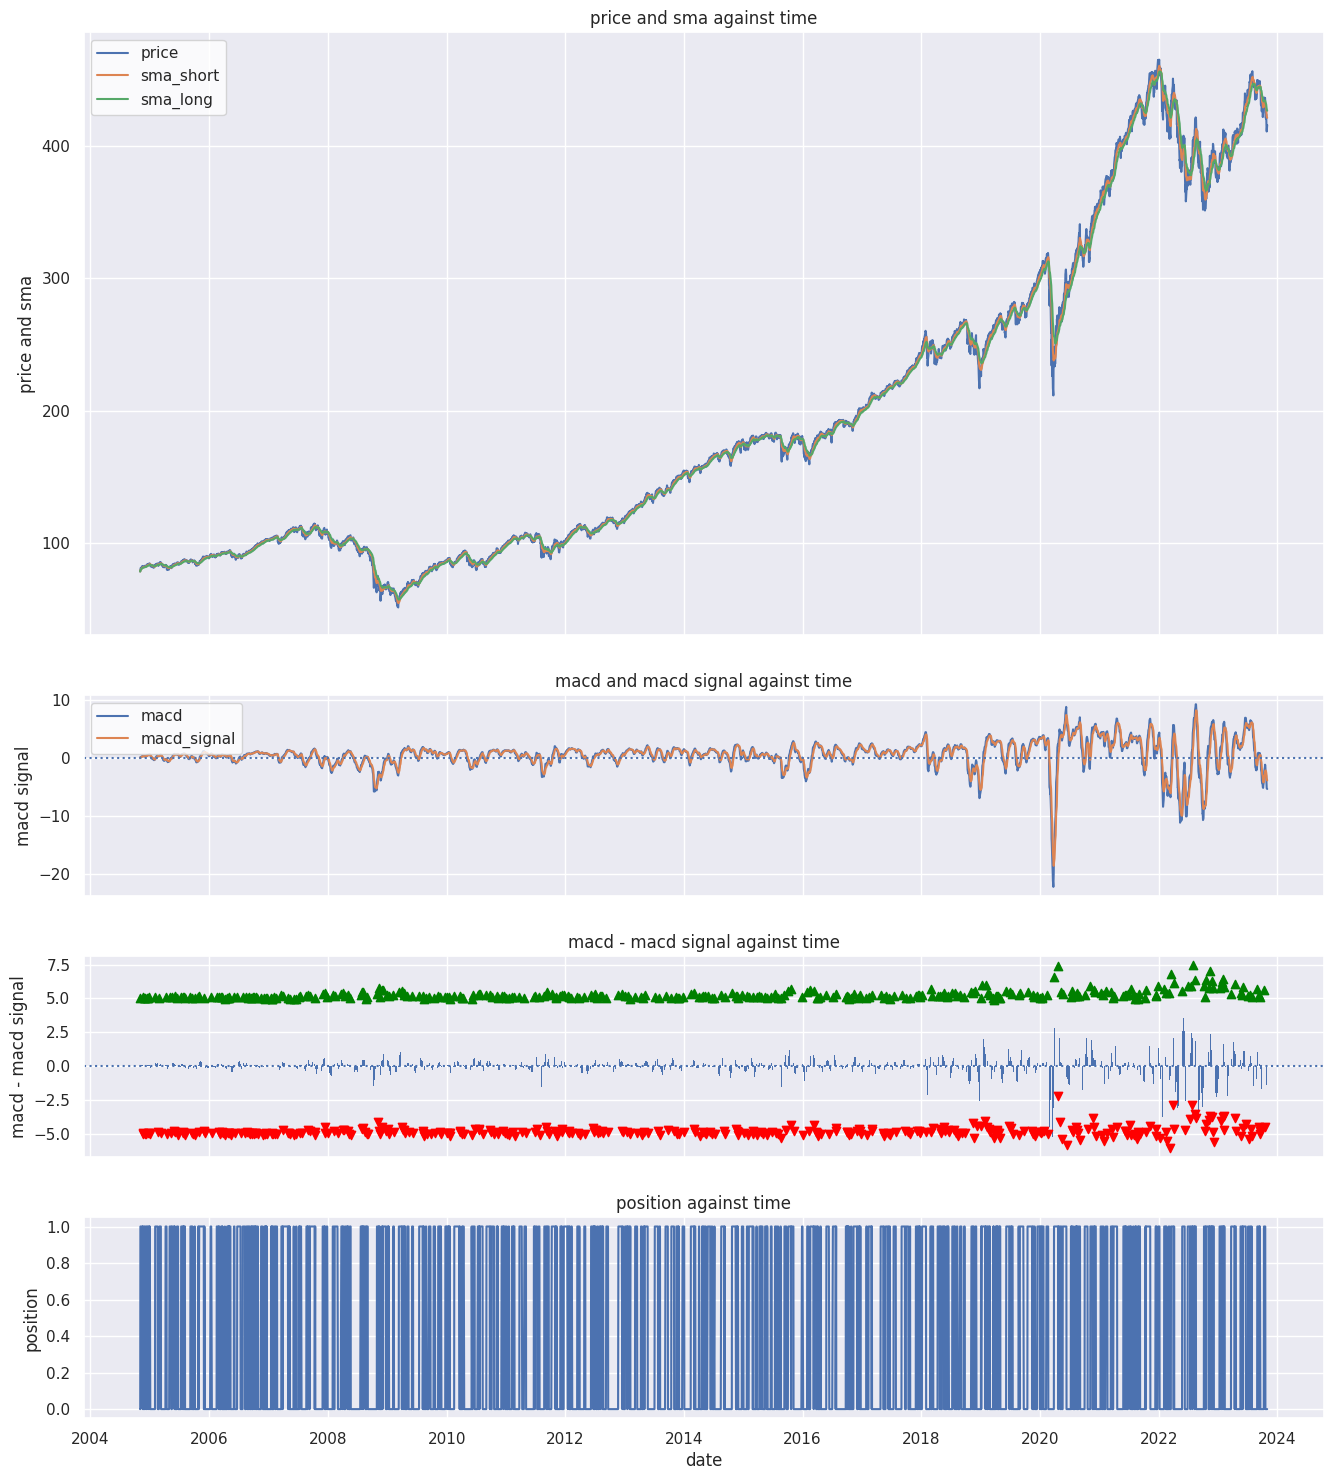

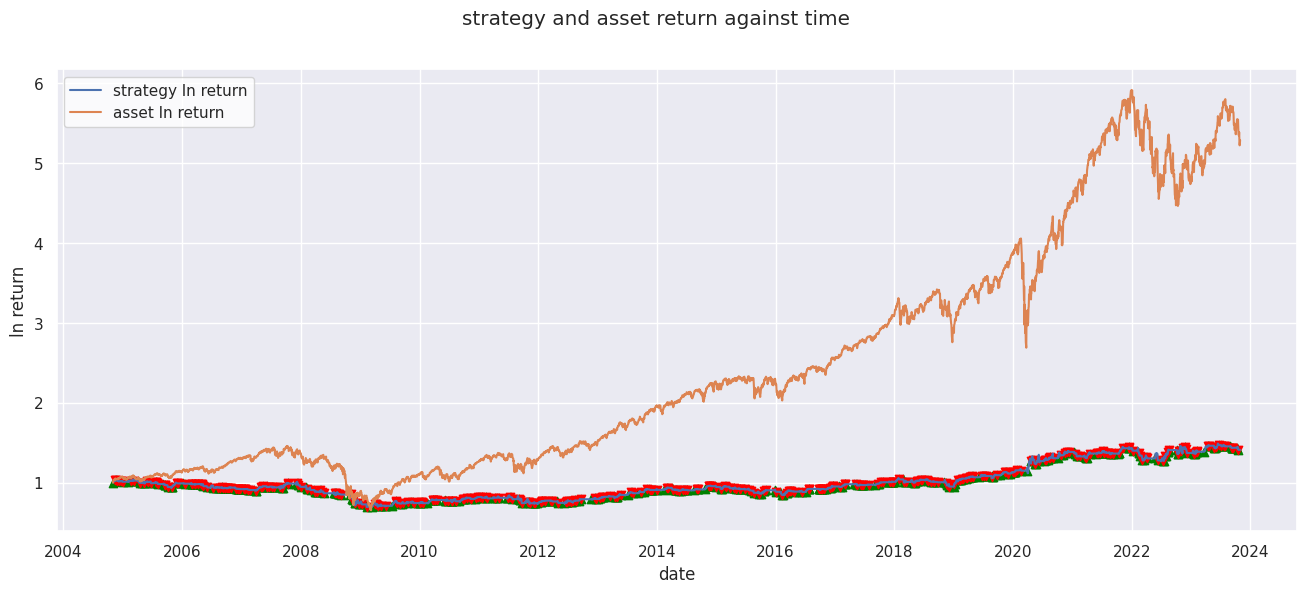

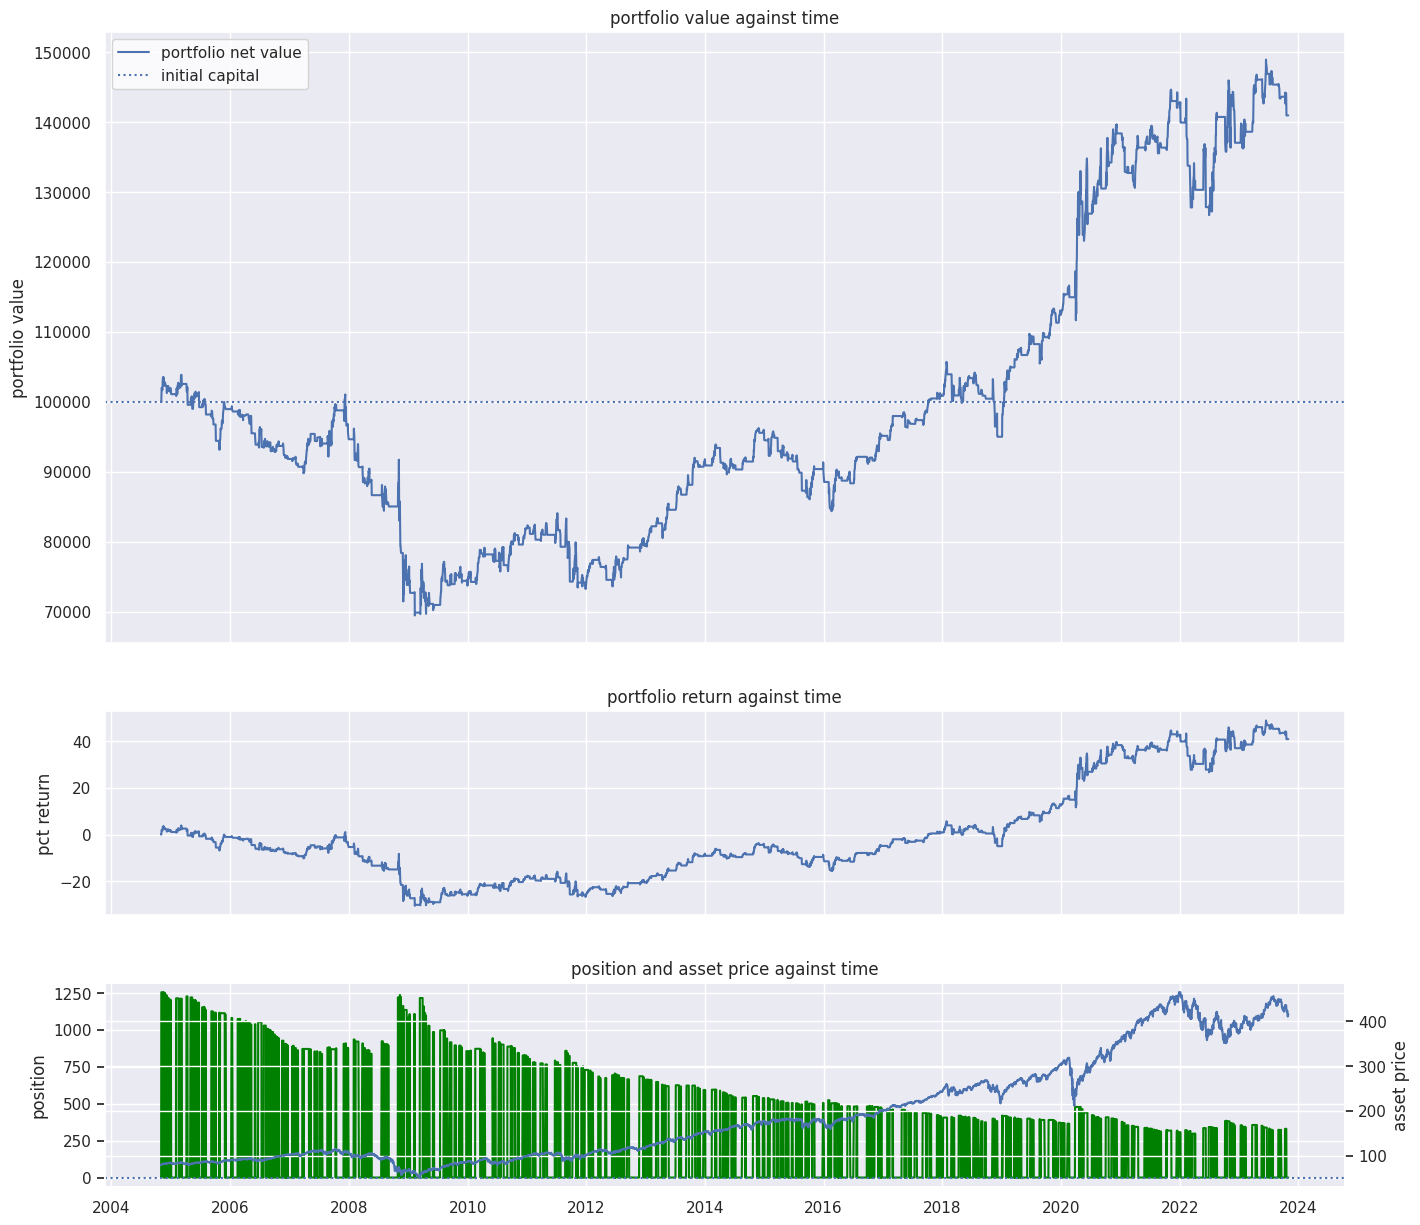

{'value_final': 140955.89031219482, 'ret_portfolio': 0.4095589031219482, 'return': 0.01825448291409404, 'volatility': 0.09823926864122345, 'sharpe': 0.18581655957518028, 'cagr': 0.018226096464195596}

=== MAX DRAWDOWN ON SORT BY MAX VALUES ===
              return  drawdown  drawdown_max  drawdown_period
date                                                         
2009-02-10 -0.305646 -0.344275     -0.344275  0 days 00:00:00
2008-12-01 -0.285555 -0.324184     -0.324184  0 days 00:00:00
2008-11-17 -0.216159 -0.254787     -0.254787  0 days 00:00:00
2008-11-12 -0.205616 -0.244245     -0.244245  0 days 00:00:00
2008-11-06 -0.170013 -0.208642     -0.208642  0 days 00:00:00

=== MAX DRAWDOWN ON DRAWDOWN PERIOD ===
              return  drawdown  drawdown_max     drawdown_period
date                                                            
2023-10-30  0.409559 -0.079844     -0.344275  5375 days 00:00:00
2008-03-25 -0.092606 -0.131235     -0.140866   363 days 00:00:00
2006-09-06 -0.066291 

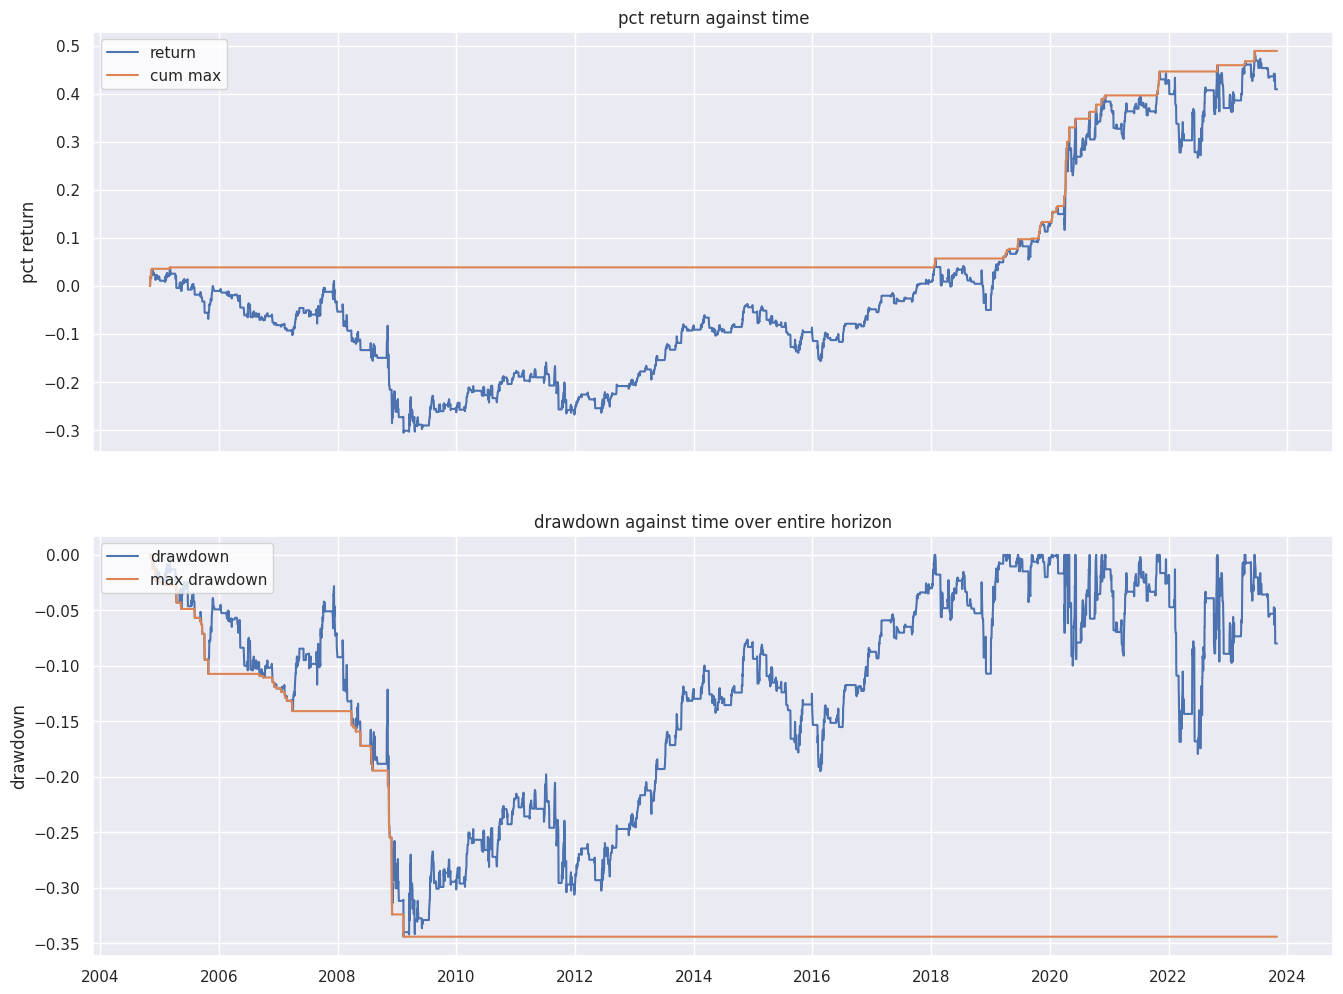

In [ ]:
df_sp500_macd_long  = getMacdTradingStrategy(df_sp500_price_bkup.copy(), short_sell_allowed = False)
df_sp500_macd_long  = getReturnPerPositionStrategy(df_sp500_macd_long)
### When long, buy max number of stocks with available cash
df_sp500_macd_long  = getTradingReturn(df_sp500_macd_long, capital_initial = 10 **5)

measure_sp500_macd_long = getSharpeRatio(df_sp500_macd_long.ret_portfolio_pct)
dict_measure_sp500_macd_long  = {
    "value_final"   : df_sp500_macd_long.iloc[-1]["value_total"],
    "ret_portfolio" : df_sp500_macd_long.iloc[-1]["ret_portfolio"],
    "return"        : measure_sp500_macd_long[1],
    "volatility"    : measure_sp500_macd_long[2],
    "sharpe"        : measure_sp500_macd_long[0],
    "cagr"          : getCagr(df_sp500_macd_long.ret_portfolio)
}
print(dict_measure_sp500_macd_long)

df_sp500_macd_long_dd = getDrawdownDf(df_sp500_macd_long.ret_portfolio_pct) #, window = 252)
print("\n=== MAX DRAWDOWN ON SORT BY MAX VALUES ===")
print(df_sp500_macd_long_dd.drop_duplicates(subset = "drawdown_max", keep = "first").sort_values(by = "drawdown_max", ascending = True).head(5))
print("\n=== MAX DRAWDOWN ON DRAWDOWN PERIOD ===")
print(df_sp500_macd_long_dd.drop_duplicates(subset = "drawdown_max", keep = "last").sort_values(by = "drawdown_period", ascending = False).head(5))


### <a id = "s2">=== PART 2: MEAN REVERSION STRATEGIES ===</a>
[contents](#top)

#### 2.1. Traditional Strategy by Using Technical Factors

2.1.2 RSI

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date       price  ret_asset    Return   up_sign  down_sign  \
date                                                                          
2004-11-03 2004-11-03   79.636063   0.012515  0.990433  0.990433   0.000000   
2004-11-04 2004-11-04   80.723488   0.013563  1.087425  1.087425   0.000000   
2004-11-05 2004-11-05   81.229073   0.006244  0.505585  0.505585   0.000000   
2004-11-08 2004-11-08   81.111290  -0.001451 -0.117783  0.000000   0.117783   
2004-11-09 2004-11-09   80.952034  -0.001965 -0.159256  0.000000   0.159256   
...               ...         ...        ...       ...       ...        ...   
2023-10-24 2023-10-24  423.630005   0.007511  3.170013  3.170013   0.000000   
2023-10-25 2023-10-25  417.549988  -0.014456 -6.080017  0.000000   6.080017   
2023-10-26 2023-10-26  412.549988  -0.012047 -5.000000  0.000000   5.000000   
2023-10-27 2023-10-27  410.679993  -0.004543 -1.869995  0.000000   1.869995   
2023-10-30 2023-10-30  415.589996   0.011885  4.910004  4.910004   0.000000   

                RSI14  position  trade  strategy  ret_strategy  ret_cum_asset  \
date                                                                            
2004-11-03   0.000000       0.0    0.0       0.0           NaN       1.012594   
2004-11-04   0.000000       0.0    0.0       0.0           0.0       1.026421   
2004-11-05   0.000000       0.0    0.0       0.0           0.0       1.032849   
2004-11-08   0.000000       0.0    0.0       0.0          -0.0       1.031352   
2004-11-09   0.000000       0.0    0.0       0.0          -0.0       1.029327   
...               ...       ...    ...       ...           ...            ...   
2023-10-24  39.980540       0.0    0.0       0.0           0.0       5.386568   
2023-10-25  34.341441       0.0    0.0       0.0          -0.0       5.309259   
2023-10-26  30.528061       0.0    0.0       0.0          -0.0       5.245682   
2023-10-27  29.221156       0.0    0.0       0.0          -0.0       5.221905   
2023-10-30  36.863890       1.0    1.0       1.0           0.0       5.284337   

            ret_cum_strategy  
date                          
2004-11-03               NaN  
2004-11-04          1.000000  
2004-11-05          1.000000  
2004-11-08          1.000000  
2004-11-09          1.000000  
...                      ...  
2023-10-24          1.151745  
2023-10-25          1.151745  
2023-10-26          1.151745  
2023-10-27          1.151745  
2023-10-30          1.151745  

[4780 rows x 13 columns]

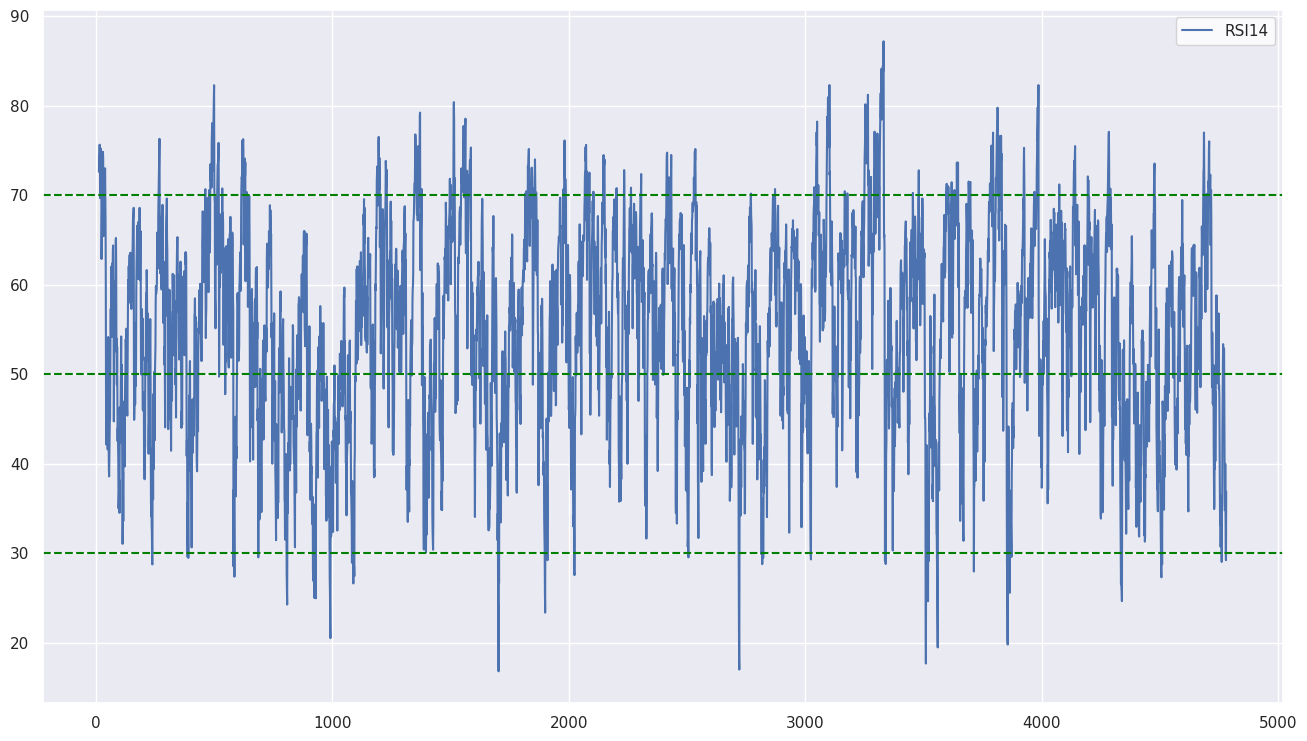

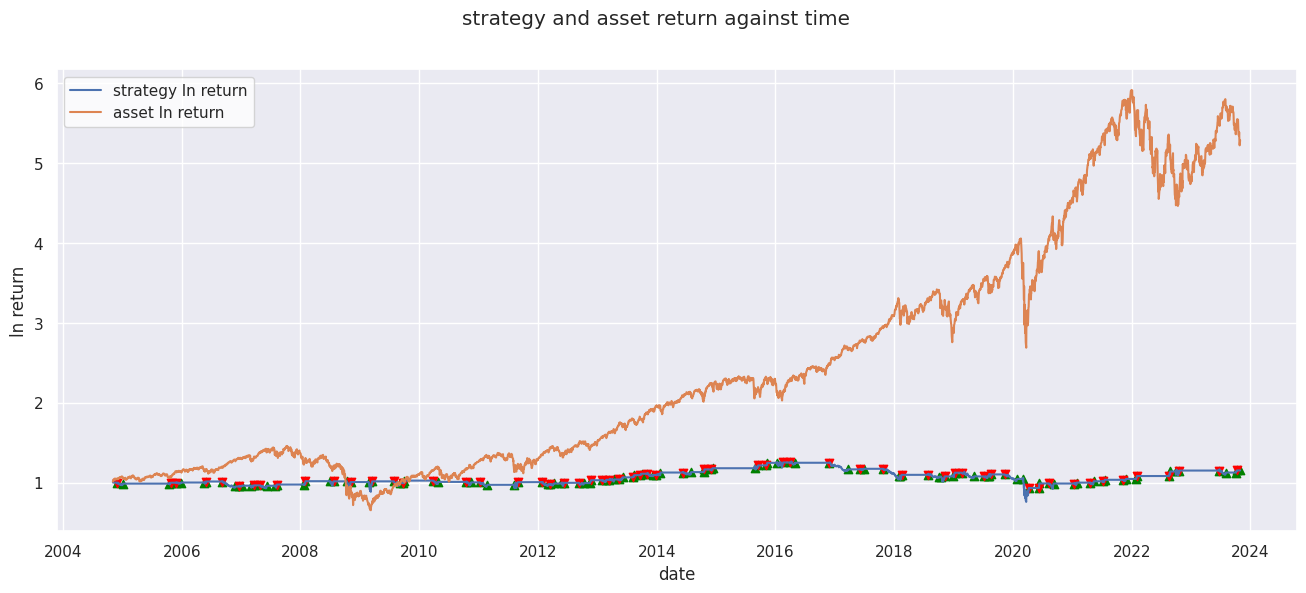

In [ ]:
df  = df_sp500_price_bkup.copy()

def get_RSI_data(df):
    df["Return"] = df["price"].diff()
    df["up_sign"] = np.where(df["Return"]>0,df["Return"],0)
    df["down_sign"] = np.where(df["Return"]<0,abs(df["Return"]),0)
    df = df.dropna()
    df = df.reset_index(drop = False)
    return df

def calc_RSI(df0, num):
    df = df0.iloc[0:num]
    average_loss = df["down_sign"].mean()
    average_gain = df["up_sign"].mean()
    RS = average_gain/average_loss
    RSI = 100-100/(1+RS)
    df0.loc[num-1,"RSI"+str(num)]=RSI
    for i in range(num,len(df0)):
        average_loss = (average_loss*(num-1)+df0.loc[i,"down_sign"])/num
        average_gain = (average_gain*(num-1)+df0.loc[i,"up_sign"])/num
        RS = average_gain/average_loss
        RSI = 100-100/(1+RS)
        df0.loc[i,"RSI"+str(num)] = RSI
    return df0

sp500_RSI_0 = get_RSI_data(df)
sp500_RSI_0 = calc_RSI(sp500_RSI_0, 14)

upper_threshold = 70
lower_threshold = 30
middle_line = 50

sp500_RSI_0[["RSI14"]].dropna().plot(figsize = [16, 9])

plt.axhline(upper_threshold, color = "green", ls = "--")

plt.axhline(middle_line, color = "green", ls = "--")

plt.axhline(lower_threshold, color = "green", ls = "--")

sp500_RSI_0["position"] =\
(
    np
    .where(((sp500_RSI_0["RSI14"]>lower_threshold)&(sp500_RSI_0["RSI14"].shift(1)<lower_threshold)),
           1, np.nan)
)

sp500_RSI_0["position"] =\
(
    np
    .where(((sp500_RSI_0["RSI14"]<upper_threshold)&(sp500_RSI_0["RSI14"].shift(1)>upper_threshold)),
           -1, sp500_RSI_0["position"])
)

sp500_RSI_0["position"] =\
(
    np
    .where(((sp500_RSI_0["RSI14"]-middle_line)*(sp500_RSI_0["RSI14"].shift(1)-middle_line)<0),
           0, sp500_RSI_0["position"])
)
sp500_RSI_0["position"] = sp500_RSI_0["position"].ffill()
sp500_RSI_0 = sp500_RSI_0.fillna(0)
sp500_RSI_0["trade"] = (sp500_RSI_0.position - sp500_RSI_0.position.shift(periods = 1).fillna(0))


sp500_RSI_0["ret_asset"] = np.log(sp500_RSI_0["price"]/sp500_RSI_0["price"].shift(1))
sp500_RSI_0 = sp500_RSI_0.dropna()
sp500_RSI_0.index = sp500_RSI_0["date"]

RSI_Traditional_strategy = getReturnPerPositionStrategy(sp500_RSI_0)
RSI_Traditional_strategy.drop(["date"], axis=1)
RSI_Traditional_strategy

Performance is bad, so try to use data tuning.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-12-3f9cf349969a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Return"] = df["price"].diff()
<ipython-input-12-3f9cf349969a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Optimal Window: 2
Max Cumulative Returns: 1.7253388601277844


<ipython-input-12-3f9cf349969a>:15: RuntimeWarning: divide by zero encountered in double_scalars
  RS = average_gain/average_loss
<ipython-input-12-3f9cf349969a>:21: RuntimeWarning: divide by zero encountered in double_scalars
  RS = average_gain/average_loss


date       price  ret_asset    Return   up_sign  down_sign  \
date                                                                          
2004-11-03 2004-11-03   79.636063   0.012515  0.990433  0.990433   0.000000   
2004-11-04 2004-11-04   80.723488   0.013563  1.087425  1.087425   0.000000   
2004-11-05 2004-11-05   81.229073   0.006244  0.505585  0.505585   0.000000   
2004-11-08 2004-11-08   81.111290  -0.001451 -0.117783  0.000000   0.117783   
2004-11-09 2004-11-09   80.952034  -0.001965 -0.159256  0.000000   0.159256   
...               ...         ...        ...       ...       ...        ...   
2023-10-24 2023-10-24  423.630005   0.007511  3.170013  3.170013   0.000000   
2023-10-25 2023-10-25  417.549988  -0.014456 -6.080017  0.000000   6.080017   
2023-10-26 2023-10-26  412.549988  -0.012047 -5.000000  0.000000   5.000000   
2023-10-27 2023-10-27  410.679993  -0.004543 -1.869995  0.000000   1.869995   
2023-10-30 2023-10-30  415.589996   0.011885  4.910004  4.910004   0.000000   

                  RSI2  position  trade  strategy  ret_strategy  \
date                                                              
2004-11-03  100.000000       0.0    0.0       0.0           NaN   
2004-11-04  100.000000       0.0    0.0       0.0           0.0   
2004-11-05  100.000000       0.0    0.0       0.0           0.0   
2004-11-08   84.697542       0.0    0.0       0.0          -0.0   
2004-11-09   59.907105      -1.0   -1.0      -1.0          -0.0   
...                ...       ...    ...       ...           ...   
2023-10-24   56.138989       0.0    0.0       0.0           0.0   
2023-10-25   18.104340       0.0    0.0       0.0          -0.0   
2023-10-26    8.562724       0.0    0.0       0.0          -0.0   
2023-10-27    6.141583       0.0    0.0       0.0          -0.0   
2023-10-30   62.227570       0.0    0.0       0.0           0.0   

            ret_cum_asset  ret_cum_strategy  
date                                         
2004-11-03       1.012594               NaN  
2004-11-04       1.026421          1.000000  
2004-11-05       1.032849          1.000000  
2004-11-08       1.031352          1.000000  
2004-11-09       1.029327          1.000000  
...                   ...               ...  
2023-10-24       5.386568          1.725339  
2023-10-25       5.309259          1.725339  
2023-10-26       5.245682          1.725339  
2023-10-27       5.221905          1.725339  
2023-10-30       5.284337          1.725339  

[4780 rows x 13 columns]

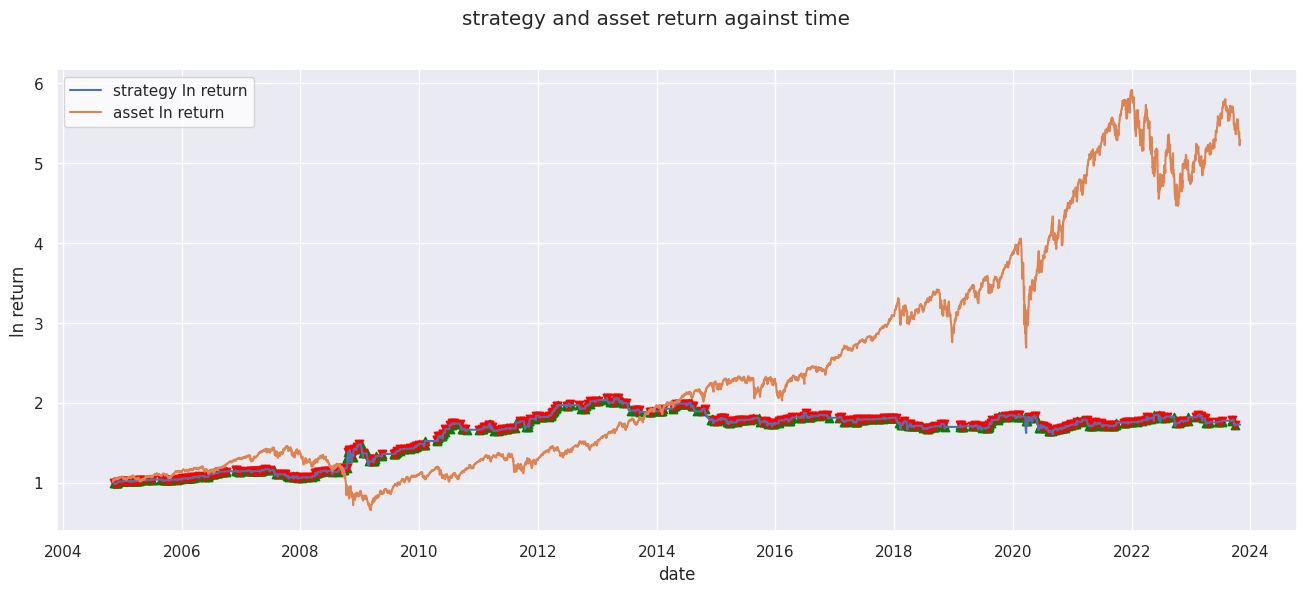

In [ ]:
def optimize_RSI():
    max_cumulative_returns = float('-inf')

    # Define the range of short and long windows to test
    window_range = range(2, 40, 1)

    for window in window_range:

        sp500_RSI = get_RSI_data(df_sp500_price)

        df_strategy_RSI = calc_RSI(sp500_RSI, window)

        df_strategy_RSI["position"] =\
(
    np
    .where(((df_strategy_RSI["RSI"+str(window)]>lower_threshold)&(df_strategy_RSI["RSI"+str(window)].shift(1)<lower_threshold)),
           1, np.nan)
)

        df_strategy_RSI["position"] =\
(
    np
    .where(((df_strategy_RSI["RSI"+str(window)]<upper_threshold)&(df_strategy_RSI["RSI"+str(window)].shift(1)>upper_threshold)),
           -1, df_strategy_RSI["position"])
)

        df_strategy_RSI["position"] =\
(
    np
    .where(((df_strategy_RSI["RSI"+str(window)]-middle_line)*(df_strategy_RSI["RSI"+str(window)].shift(1)-middle_line)<0),
           0, df_strategy_RSI["position"]

))

        df_strategy_RSI["position"] = df_strategy_RSI["position"].ffill()

        df_strategy_RSI = df_strategy_RSI.fillna(0)
        df_strategy_RSI["ret_asset"] = np.log(df_strategy_RSI["price"]/df_strategy_RSI["price"].shift(1))

        df_strategy_RSI['ret_strategy'] = df_strategy_RSI['position'].shift(1) * df_strategy_RSI["ret_asset"]
        df_strategy_RSI = df_strategy_RSI.dropna()
        df_strategy_RSI['ret_cum_strategy'] = df_strategy_RSI['ret_strategy'].cumsum().apply(np.exp)


        final_cumulative_returns = df_strategy_RSI['ret_cum_strategy'].iloc[-1]

        if final_cumulative_returns > max_cumulative_returns:
            max_cumulative_returns = final_cumulative_returns
            best_window = window
        else:
            continue


    return  best_window, max_cumulative_returns

# Call the function to get the optimal short and long windows
optimal_window,  max_returns = optimize_RSI()


print(f"Optimal Window: {optimal_window}")
print(f"Max Cumulative Returns: {max_returns}")


sp500_RSI_00 = get_RSI_data(df)
sp500_RSI_optimize = calc_RSI(sp500_RSI_00, 2)
sp500_RSI_optimize["position"] =\
(
    np
    .where(((sp500_RSI_optimize["RSI2"]>lower_threshold)&(sp500_RSI_optimize["RSI2"].shift(1)<lower_threshold)),
           1, np.nan)
)

sp500_RSI_optimize["position"] =\
(
    np
    .where(((sp500_RSI_optimize["RSI2"]<upper_threshold)&(sp500_RSI_optimize["RSI2"].shift(1)>upper_threshold)),
           -1, sp500_RSI_optimize["position"])
)

sp500_RSI_optimize["position"] =\
(
    np
    .where(((sp500_RSI_optimize["RSI2"]-middle_line)*(sp500_RSI_optimize["RSI2"].shift(1)-middle_line)<0),
           0, sp500_RSI_optimize["position"])
)
sp500_RSI_optimize["position"] = sp500_RSI_optimize["position"].ffill()
sp500_RSI_optimize = sp500_RSI_optimize.fillna(0)
sp500_RSI_optimize["trade"] = (sp500_RSI_optimize.position - sp500_RSI_optimize.position.shift(periods = 1).fillna(0))
sp500_RSI_optimize["ret_asset"] = np.log(sp500_RSI_optimize["price"]/sp500_RSI_optimize["price"].shift(1))
sp500_RSI_optimize = sp500_RSI_optimize.dropna()
sp500_RSI_optimize.index = sp500_RSI_optimize["date"]

RSI_Traditional_strategy1 = getReturnPerPositionStrategy(sp500_RSI_optimize)
RSI_Traditional_strategy1.drop(["date"], axis=1)
RSI_Traditional_strategy1

2.1.3 KDJ

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


price  ret_asset    Return   up_sign  down_sign     KValue  \
date                                                                          
2004-11-12   82.274902        NaN  0.644127  0.644127   0.000000  65.455599   
2004-11-15   82.477036   0.002454  0.202133  0.202133   0.000000  75.079667   
2004-11-16   81.886566  -0.007185 -0.590469  0.000000   0.590469  74.744448   
2004-11-17   82.372826   0.005921  0.486259  0.486259   0.000000  76.118975   
2004-11-18   82.483978   0.001348  0.111153  0.111153   0.000000  78.569649   
...                ...        ...       ...       ...        ...        ...   
2023-10-24  423.630005   0.007511  3.170013  3.170013   0.000000  27.605061   
2023-10-25  417.549988  -0.014456 -6.080017  0.000000   6.080017  19.239861   
2023-10-26  412.549988  -0.012047 -5.000000  0.000000   5.000000  14.019718   
2023-10-27  410.679993  -0.004543 -1.869995  0.000000   1.869995  11.040222   
2023-10-30  415.589996   0.011885  4.910004  4.910004   0.000000  15.549090   

               DValue      JValue  Ksignal  Dsignal  Jsignal  KDJsig  \
date                                                                   
2004-11-12  55.151866   86.063064        0        0        0       0   
2004-11-15  61.794467  101.650069        0        0       -1      -1   
2004-11-16  66.111127   92.011089        0        0        0       0   
2004-11-17  69.447076   89.462772        0        0        0       0   
2004-11-18  72.487934   90.733080        0        0        0       0   
...               ...         ...      ...      ...      ...     ...   
2023-10-24  40.068091    2.679000        0        0        0       0   
2023-10-25  33.125348   -8.531113        1        0        1       2   
2023-10-26  26.756804  -11.454455        1        0        1       2   
2023-10-27  21.517944   -9.915221        1        0        1       2   
2023-10-30  19.528326    7.590618        1        1        0       2   

            position  trade  strategy  ret_strategy  ret_cum_asset  \
date                                                                 
2004-11-12         0    0.0         0           NaN            NaN   
2004-11-15        -1   -1.0        -1      0.000000       1.002457   
2004-11-16         0    1.0         0      0.007185       0.995280   
2004-11-17         0    0.0         0      0.000000       1.001190   
2004-11-18         0    0.0         0      0.000000       1.002541   
...              ...    ...       ...           ...            ...   
2023-10-24         0   -1.0         0      0.007511       5.148958   
2023-10-25         1    1.0         1     -0.000000       5.075059   
2023-10-26         1    0.0         1     -0.012047       5.014287   
2023-10-27         1    0.0         1     -0.004543       4.991559   
2023-10-30         1    0.0         1      0.011885       5.051237   

            ret_cum_strategy  
date                          
2004-11-12               NaN  
2004-11-15          1.000000  
2004-11-16          1.007211  
2004-11-17          1.007211  
2004-11-18          1.007211  
...                      ...  
2023-10-24          3.259622  
2023-10-25          3.259622  
2023-10-26          3.220590  
2023-10-27          3.205991  
2023-10-30          3.244322  

[4773 rows x 18 columns]

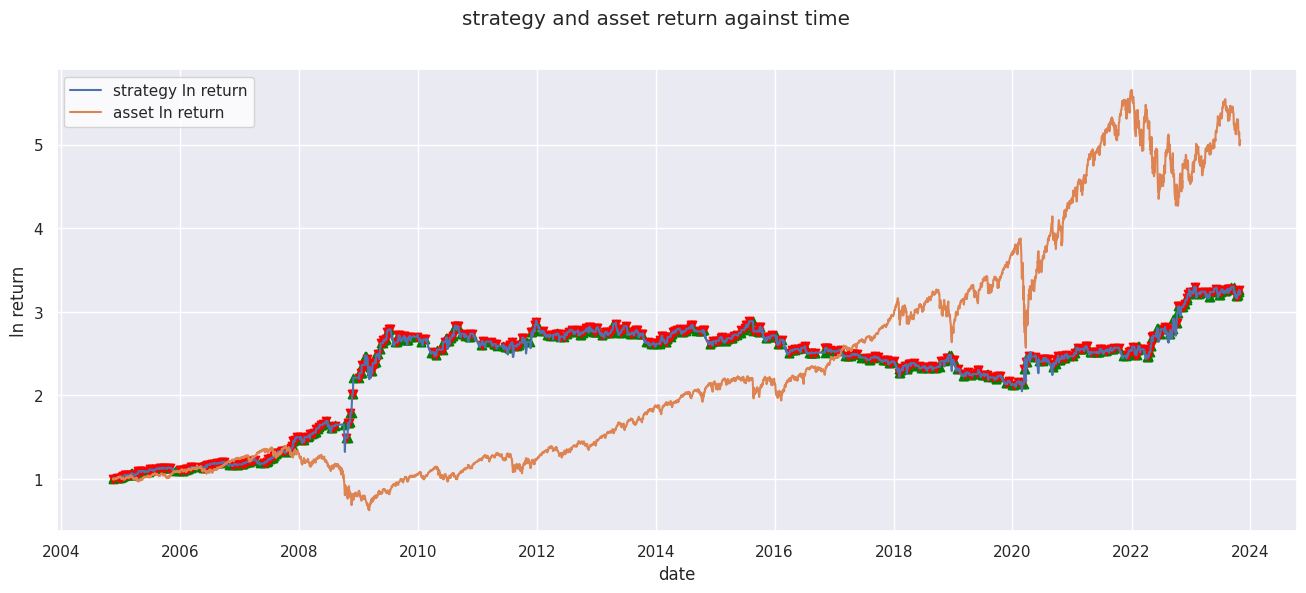

In [ ]:
def calc_KDJ(num):
    warnings.filterwarnings("ignore")
    df = df_sp500.copy()

    close = df.Close
    high = df.High
    low = df.Low


    date = close.index.to_series()
    ndate = len(date)

    periodHigh = pd.Series(np.zeros(ndate-(num-1)),index=date.index[(num-1):])

    periodLow = pd.Series(np.zeros(ndate-(num-1)),index=date.index[(num-1):])

    RSV = pd.Series(np.zeros(ndate-(num-1)), index=date.index[(num-1):])


    for j in range((num-1),ndate):
        period = date[j-(num-1):j+1]
        i = date[j]
        periodHigh[i] = high[period].max()
        periodLow[i] = low[period].min()
        RSV[i] = 100 * (close[i]-periodLow[i])/(periodHigh[i]-periodLow[i])
        periodHigh.name = 'periodHigh'
        periodLow.name = 'periodLow'
        RSV.name = 'RSV'

    KValue = pd.Series(0.0, index=RSV.index)
    KValue[0] = 50
    for i in range(1,len(RSV)):
        KValue[i] = 2/3*KValue[i-1] + RSV[i]/3

    KValue.name = 'KValue'


    DValue = pd.Series(0.0, index=RSV.index)
    DValue[0] = 50
    for i in range(1, len(RSV)):
        DValue[i] = 2/3*DValue[i-1] + KValue[i]/3

    DValue.name = 'DValue'
    KValue = KValue[1:]
    DValue = DValue[1:]

    JValue = 3*KValue - 2*DValue
    JValue.name='JValue'
    return pd.concat([df_sp500_price,KValue,DValue,JValue],axis = 1)

sp500_KDJ0 = calc_KDJ(9)
sp500_KDJ0
sp500_KDJ0 = sp500_KDJ0.dropna()
sp500_KDJ0["Ksignal"] = np.where((sp500_KDJ0['KValue']>80),-1,np.where((sp500_KDJ0['KValue']<20),1,0))
sp500_KDJ0["Dsignal"] = np.where((sp500_KDJ0['DValue']>80),-1,np.where((sp500_KDJ0['DValue']<20),1,0))
sp500_KDJ0["Jsignal"] = np.where((sp500_KDJ0['JValue']>100),-1,np.where((sp500_KDJ0['JValue']<0),1,0))

sp500_KDJ0["KDJsig"] = sp500_KDJ0["Ksignal"]+sp500_KDJ0["Dsignal"]+sp500_KDJ0["Jsignal"]

sp500_KDJ0["position"] = np.where((sp500_KDJ0["KDJsig"]>0),1,0)
sp500_KDJ0["position"] =  np.where((sp500_KDJ0["KDJsig"]<0),-1,sp500_KDJ0["position"])


sp500_KDJ0["position"] = sp500_KDJ0["position"].ffill()
sp500_KDJ0 = sp500_KDJ0.fillna(0)

sp500_KDJ0["ret_asset"] = np.log(sp500_KDJ0["price"]/sp500_KDJ0["price"].shift(1))
sp500_KDJ0["trade"] = (sp500_KDJ0.position - sp500_KDJ0.position.shift(periods = 1).fillna(0))
KDJ_strategy0 = getReturnPerPositionStrategy(sp500_KDJ0)
KDJ_strategy0

Parameter Tuning

Optimal Window: 6
Max Cumulative Returns: 4.754697305961167


price  ret_asset    Return   up_sign  down_sign     KValue  \
date                                                                          
2004-11-09   80.952034        NaN -0.159256  0.000000   0.159256  60.935125   
2004-11-10   81.014359   0.000770  0.062325  0.062325   0.000000  67.388143   
2004-11-11   81.630775   0.007580  0.616417  0.616417   0.000000  75.739363   
2004-11-12   82.274902   0.007860  0.644127  0.644127   0.000000  81.037412   
2004-11-15   82.477036   0.002454  0.202133  0.202133   0.000000  83.410953   
...                ...        ...       ...       ...        ...        ...   
2023-10-24  423.630005   0.007511  3.170013  3.170013   0.000000  24.087762   
2023-10-25  417.549988  -0.014456 -6.080017  0.000000   6.080017  17.031340   
2023-10-26  412.549988  -0.012047 -5.000000  0.000000   5.000000  12.846500   
2023-10-27  410.679993  -0.004543 -1.869995  0.000000   1.869995  11.391800   
2023-10-30  415.589996   0.011885  4.910004  4.910004   0.000000  21.218275   

               DValue      JValue  Ksignal  Dsignal  Jsignal  KDJsig  \
date                                                                   
2004-11-09  53.645042   75.515291        0        0        0       0   
2004-11-10  58.226076   85.712279        0        0        0       0   
2004-11-11  64.063838   99.090414        0        0        0       0   
2004-11-12  69.721696  103.668844       -1        0       -1      -2   
2004-11-15  74.284782  101.663296       -1        0       -1      -2   
...               ...         ...      ...      ...      ...     ...   
2023-10-24  34.034789    4.193709        0        0        0       0   
2023-10-25  28.366972   -5.639926        1        0        1       2   
2023-10-26  23.193482   -7.847462        1        0        1       2   
2023-10-27  19.259588   -4.343776        1        1        1       3   
2023-10-30  19.912484   23.829859        0        1        0       1   

            position  trade  strategy  ret_strategy  ret_cum_asset  \
date                                                                 
2004-11-09         0    0.0         0           NaN            NaN   
2004-11-10         0    0.0         0      0.000000       1.000770   
2004-11-11         0    0.0         0      0.000000       1.008384   
2004-11-12        -1   -1.0        -1      0.000000       1.016341   
2004-11-15        -1    0.0        -1     -0.002454       1.018838   
...              ...    ...       ...           ...            ...   
2023-10-24         0   -1.0         0      0.007511       5.233099   
2023-10-25         1    1.0         1     -0.000000       5.157993   
2023-10-26         1    0.0         1     -0.012047       5.096228   
2023-10-27         1    0.0         1     -0.004543       5.073128   
2023-10-30         1    0.0         1      0.011885       5.133781   

            ret_cum_strategy  
date                          
2004-11-09               NaN  
2004-11-10          1.000000  
2004-11-11          1.000000  
2004-11-12          1.000000  
2004-11-15          0.997549  
...                      ...  
2023-10-24          4.777121  
2023-10-25          4.777121  
2023-10-26          4.719917  
2023-10-27          4.698523  
2023-10-30          4.754697  

[4776 rows x 18 columns]

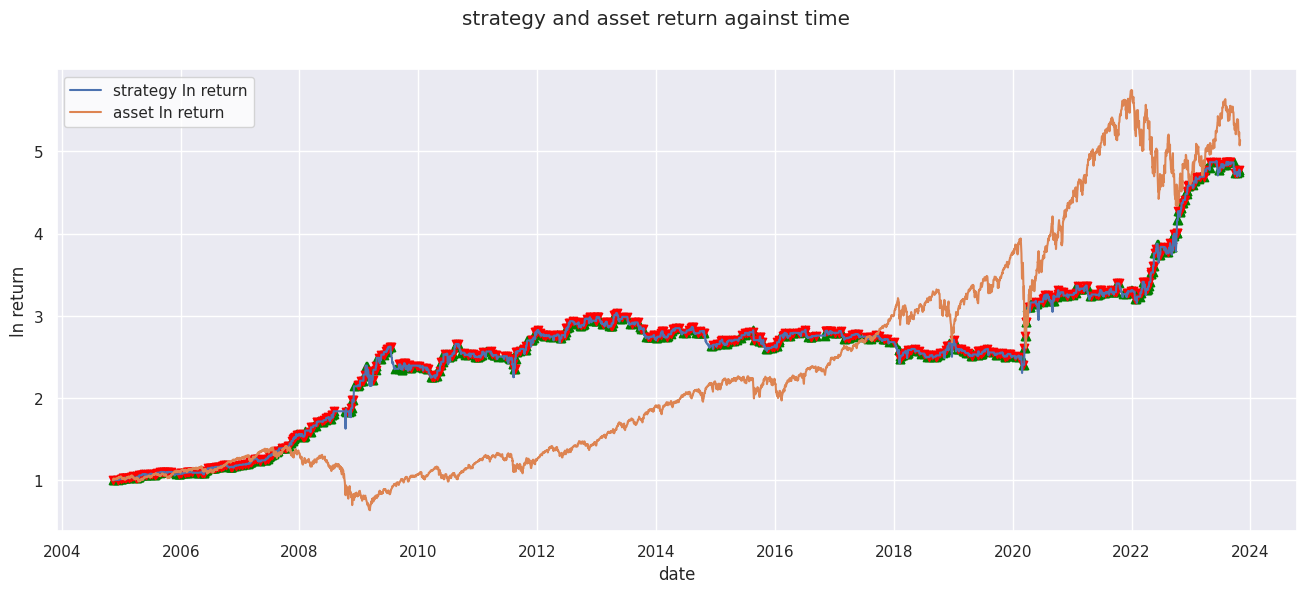

In [ ]:
def optimize_KDJ():
    max_cumulative_returns = float('-inf')

    # Define the range of short and long windows to test
    window_range = range(2, 20, 1)

    for window in window_range:

        df_strategy_KDJ = calc_KDJ(window)

        df_strategy_KDJ = df_strategy_KDJ.dropna()
        df_strategy_KDJ["Ksignal"] = np.where((df_strategy_KDJ['KValue']>80),-1,np.where((df_strategy_KDJ['KValue']<20),1,0))
        df_strategy_KDJ["Dsignal"] = np.where((df_strategy_KDJ['DValue']>80),-1,np.where((df_strategy_KDJ['DValue']<20),1,0))
        df_strategy_KDJ["Jsignal"] = np.where((df_strategy_KDJ['JValue']>100),-1,np.where((df_strategy_KDJ['JValue']<0),1,0))

        df_strategy_KDJ["KDJsig"] = df_strategy_KDJ["Ksignal"]+df_strategy_KDJ["Dsignal"]+df_strategy_KDJ["Jsignal"]

        df_strategy_KDJ["position"] = np.where((df_strategy_KDJ["KDJsig"]>0),1,0)
        df_strategy_KDJ["position"] =  np.where((df_strategy_KDJ["KDJsig"]<0),-1,df_strategy_KDJ["position"])


        df_strategy_KDJ["position"] = df_strategy_KDJ["position"].ffill()
        df_strategy_KDJ = df_strategy_KDJ.fillna(0)

        df_strategy_KDJ['ret_strategy'] = df_strategy_KDJ['position'].shift(1) * df_strategy_KDJ["ret_asset"]
        df_strategy_KDJ = df_strategy_KDJ.dropna()
        df_strategy_KDJ['ret_cum_strategy'] = df_strategy_KDJ['ret_strategy'].cumsum().apply(np.exp)

        final_cumulative_returns = df_strategy_KDJ['ret_cum_strategy'].iloc[-1]

        if final_cumulative_returns > max_cumulative_returns:
            max_cumulative_returns = final_cumulative_returns
            best_window = window
        else:
            continue


    return  best_window, max_cumulative_returns

# Call the function to get the optimal short and long windows
optimal_window,  max_returns = optimize_KDJ()


print(f"Optimal Window: {optimal_window}")
print(f"Max Cumulative Returns: {max_returns}")


sp500_KDJ00 = calc_KDJ(6)
sp500_KDJ00 = sp500_KDJ00.dropna()
sp500_KDJ00["Ksignal"] = np.where((sp500_KDJ00['KValue']>80),-1,np.where((sp500_KDJ00['KValue']<20),1,0))
sp500_KDJ00["Dsignal"] = np.where((sp500_KDJ00['DValue']>80),-1,np.where((sp500_KDJ00['DValue']<20),1,0))
sp500_KDJ00["Jsignal"] = np.where((sp500_KDJ00['JValue']>100),-1,np.where((sp500_KDJ00['JValue']<0),1,0))

sp500_KDJ00["KDJsig"] = sp500_KDJ00["Ksignal"]+sp500_KDJ00["Dsignal"]+sp500_KDJ00["Jsignal"]

sp500_KDJ00["position"] = np.where((sp500_KDJ00["KDJsig"]>0),1,0)
sp500_KDJ00["position"] =  np.where((sp500_KDJ00["KDJsig"]<0),-1,sp500_KDJ00["position"])


sp500_KDJ00["position"] = sp500_KDJ00["position"].ffill()
sp500_KDJ00 = sp500_KDJ00.fillna(0)

sp500_KDJ00["ret_asset"] = np.log(sp500_KDJ00["price"]/sp500_KDJ00["price"].shift(1))
sp500_KDJ00["trade"] = (sp500_KDJ00.position - sp500_KDJ00.position.shift(periods = 1).fillna(0))
KDJ_strategy00 = getReturnPerPositionStrategy(sp500_KDJ00)
KDJ_strategy00

2.1.4 MACD+RSI

date       price  ret_asset    Return   up_sign  down_sign  \
date                                                                          
2004-11-02 2004-11-02   78.645630   0.000352  0.027695  0.027695   0.000000   
2004-11-03 2004-11-03   79.636063   0.012515  0.990433  0.990433   0.000000   
2004-11-04 2004-11-04   80.723488   0.013563  1.087425  1.087425   0.000000   
2004-11-05 2004-11-05   81.229073   0.006244  0.505585  0.505585   0.000000   
2004-11-08 2004-11-08   81.111290  -0.001451 -0.117783  0.000000   0.117783   
...               ...         ...        ...       ...       ...        ...   
2023-10-24 2023-10-24  423.630005   0.007511  3.170013  3.170013   0.000000   
2023-10-25 2023-10-25  417.549988  -0.014456 -6.080017  0.000000   6.080017   
2023-10-26 2023-10-26  412.549988  -0.012047 -5.000000  0.000000   5.000000   
2023-10-27 2023-10-27  410.679993  -0.004543 -1.869995  0.000000   1.869995   
2023-10-30 2023-10-30  415.589996   0.011885  4.910004  4.910004   0.000000   

             short_EWM    long_EWM      MACD  MACD_signal  position_MACD  \
date                                                                       
2004-11-02   78.632936   78.632315  0.000621     0.000345              1   
2004-11-03   79.024457   78.992952  0.031505     0.013116              1   
2004-11-04   79.560775   79.476734  0.084040     0.037142              1   
2004-11-05   80.014045   79.883109  0.130937     0.065043              1   
2004-11-08   80.280733   80.129104  0.151630     0.088513              1   
...                ...         ...       ...          ...            ...   
2023-10-24  427.720451  430.860102 -3.139651    -2.531280             -1   
2023-10-25  426.155765  429.874168 -3.718403    -2.768705             -1   
2023-10-26  424.062568  428.590895 -4.528327    -3.120629             -1   
2023-10-27  422.003710  427.264162 -5.260451    -3.548594             -1   
2023-10-30  421.016985  426.399409 -5.382423    -3.915360             -1   

                RSI14  position_RSI  position  trade  strategy  ret_strategy  \
date                                                                           
2004-11-02        NaN            -1       0.0    0.0       0.0           NaN   
2004-11-03        NaN            -1       0.0    0.0       0.0      0.000000   
2004-11-04        NaN            -1       0.0    0.0       0.0      0.000000   
2004-11-05        NaN            -1       0.0    0.0       0.0      0.000000   
2004-11-08        NaN            -1       0.0    0.0       0.0     -0.000000   
...               ...           ...       ...    ...       ...           ...   
2023-10-24  39.980540             1       1.0    0.0       1.0      0.007511   
2023-10-25  34.341441             1       1.0    0.0       1.0     -0.014456   
2023-10-26  30.528061             1       1.0    0.0       1.0     -0.012047   
2023-10-27  29.221156             1       1.0    0.0       1.0     -0.004543   
2023-10-30  36.863890             1       1.0    0.0       1.0      0.011885   

            ret_cum_asset  ret_cum_strategy  
date                                         
2004-11-02       1.000352               NaN  
2004-11-03       1.012950          1.000000  
2004-11-04       1.026782          1.000000  
2004-11-05       1.033213          1.000000  
2004-11-08       1.031715          1.000000  
...                   ...               ...  
2023-10-24       5.388465          0.481496  
2023-10-25       5.311129          0.474585  
2023-10-26       5.247530          0.468902  
2023-10-27       5.223744          0.466777  
2023-10-30       5.286198          0.472357  

[4781 rows x 19 columns]

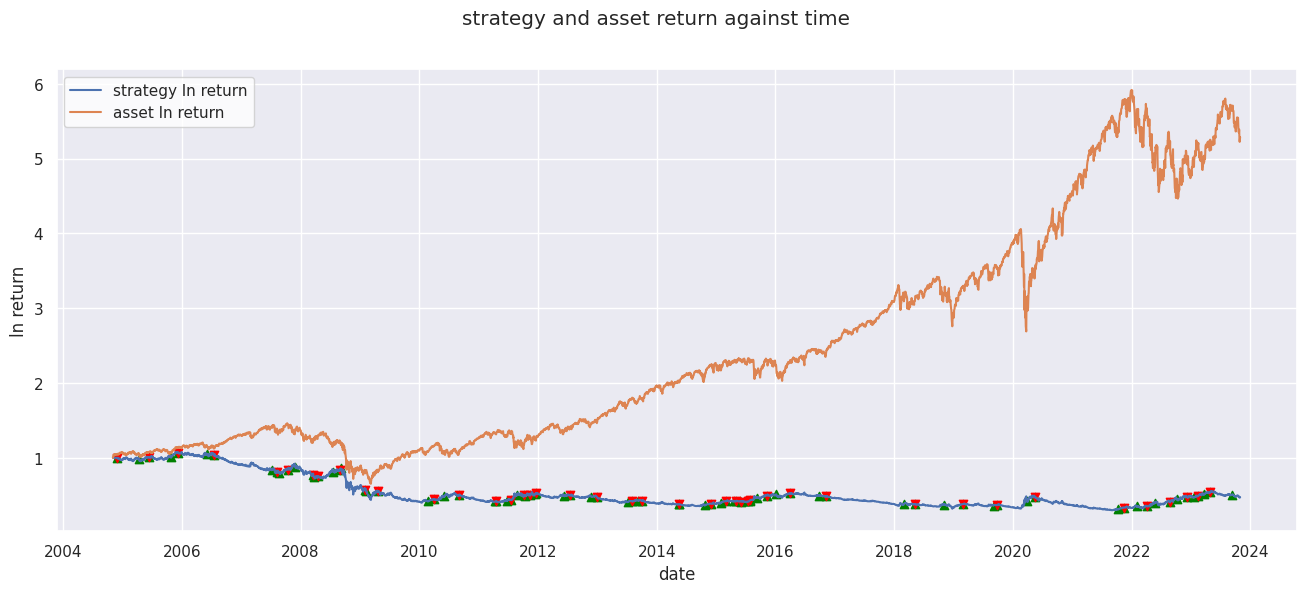

In [ ]:
#short and long EWM
sp500_mix  = df_sp500_price.copy()
short_EWM = 12
long_EWM = 26

sp500_mix["short_EWM"] = sp500_mix["price"].ewm(span=short_EWM).mean()
sp500_mix["long_EWM"] = sp500_mix["price"].ewm(span=long_EWM).mean()

#MACD and MACD signal line
signal = 9

sp500_mix["MACD"] = sp500_mix["short_EWM"] - sp500_mix["long_EWM"]
sp500_mix["MACD_signal"] = sp500_mix["MACD"].ewm(span = signal).mean()
sp500_mix["position_MACD"] = np.where(sp500_mix["MACD"] > sp500_mix["MACD_signal"], 1, -1)

sp500_mix = get_RSI_data(sp500_mix)

sp500_mix_1 = calc_RSI(sp500_mix, 14)


sp500_mix_1["position_RSI"] = np.where(sp500_mix_1["RSI14"]<50, 1, -1)

sp500_mix_1["position"] = np.where((sp500_mix_1["position_MACD"]==-1)&(sp500_mix_1["position_RSI"]==-1), -1, np.nan)
sp500_mix_1["position"] = np.where((sp500_mix_1["position_MACD"]==1)&(sp500_mix_1["position_RSI"]==1), 1, sp500_mix_1["position"])
sp500_mix_1["position"] = sp500_mix_1["position"].shift(1)
sp500_mix_1["position"].ffill(inplace=True)
sp500_mix_1["position"].fillna(0, inplace=True)

sp500_mix_1["trade"] = (sp500_mix_1.position - sp500_mix_1.position.shift(periods = 1).fillna(0))
sp500_mix_1.index = sp500_mix_1["date"]
sp500_mix_1 = getReturnPerPositionStrategy(sp500_mix_1)
sp500_mix_1

#### 2.2 Adjusted Strategy Based on Mean-Reversion

2.2.1 RSI + Momentum Factors

In addition to the conventional methods for judging RSI, long term RSI and short term RSI have been added here. When the short-term RSI line crosses the long-term RSI line upwards, the recent buying power of the stock is strong, and the price rise is strong, releasing a strong buying signal. At this time, the stock is bought. When the short-term RSI line drops below the long-term RSI line, the recent selling power of the stock is strong, and the price decline is strong, releasing a strong selling signal. At this time, the stock is sold.

date       price  ret_asset    Return   up_sign  down_sign  \
date                                                                          
2004-12-07 2004-12-07   82.039398  -0.009355 -0.771072  0.000000   0.771072   
2004-12-08 2004-12-08   82.518730   0.005826  0.479332  0.479332   0.000000   
2004-12-09 2004-12-09   82.810471   0.003529  0.291740  0.291740   0.000000   
2004-12-10 2004-12-10   82.893814   0.001006  0.083344  0.083344   0.000000   
2004-12-13 2004-12-13   83.616287   0.008678  0.722473  0.722473   0.000000   
...               ...         ...        ...       ...       ...        ...   
2023-10-24 2023-10-24  423.630005   0.007511  3.170013  3.170013   0.000000   
2023-10-25 2023-10-25  417.549988  -0.014456 -6.080017  0.000000   6.080017   
2023-10-26 2023-10-26  412.549988  -0.012047 -5.000000  0.000000   5.000000   
2023-10-27 2023-10-27  410.679993  -0.004543 -1.869995  0.000000   1.869995   
2023-10-30 2023-10-30  415.589996   0.011885  4.910004  4.910004   0.000000   

                 RSI6      RSI24  trading_positions  trading_positions1  \
date                                                                      
2004-12-07  42.743111  67.631009                0.0                 0.0   
2004-12-08  55.456147  69.298759                0.0                 0.0   
2004-12-09  61.671734  70.271545                0.0                 0.0   
2004-12-10  63.421487  70.549715                0.0                 0.0   
2004-12-13  75.199082  72.847847                0.0                 1.0   
...               ...        ...                ...                 ...   
2023-10-24  37.388699  42.058962                1.0                -1.0   
2023-10-25  26.646097  38.356140                1.0                -1.0   
2023-10-26  20.759836  35.661951                1.0                -1.0   
2023-10-27  18.887311  34.710454                1.0                -1.0   
2023-10-30  36.838037  39.158096                1.0                -1.0   

            position  trade  strategy  ret_strategy  ret_cum_asset  \
date                                                                 
2004-12-07         0    0.0         0           NaN       0.990689   
2004-12-08         0    0.0         0      0.000000       0.996477   
2004-12-09         0    0.0         0      0.000000       1.000000   
2004-12-10         0    0.0         0      0.000000       1.001006   
2004-12-13         0    0.0         0      0.000000       1.009731   
...              ...    ...       ...           ...            ...   
2023-10-24         1    0.0         1      0.007511       5.115657   
2023-10-25         1    0.0         1     -0.014456       5.042237   
2023-10-26         1    0.0         1     -0.012047       4.981858   
2023-10-27         1    0.0         1     -0.004543       4.959276   
2023-10-30         1    0.0         1      0.011885       5.018568   

            ret_cum_strategy  
date                          
2004-12-07               NaN  
2004-12-08          1.000000  
2004-12-09          1.000000  
2004-12-10          1.000000  
2004-12-13          1.000000  
...                      ...  
2023-10-24          5.775206  
2023-10-25          5.692319  
2023-10-26          5.624155  
2023-10-27          5.598662  
2023-10-30          5.665599  

[4757 rows x 16 columns]

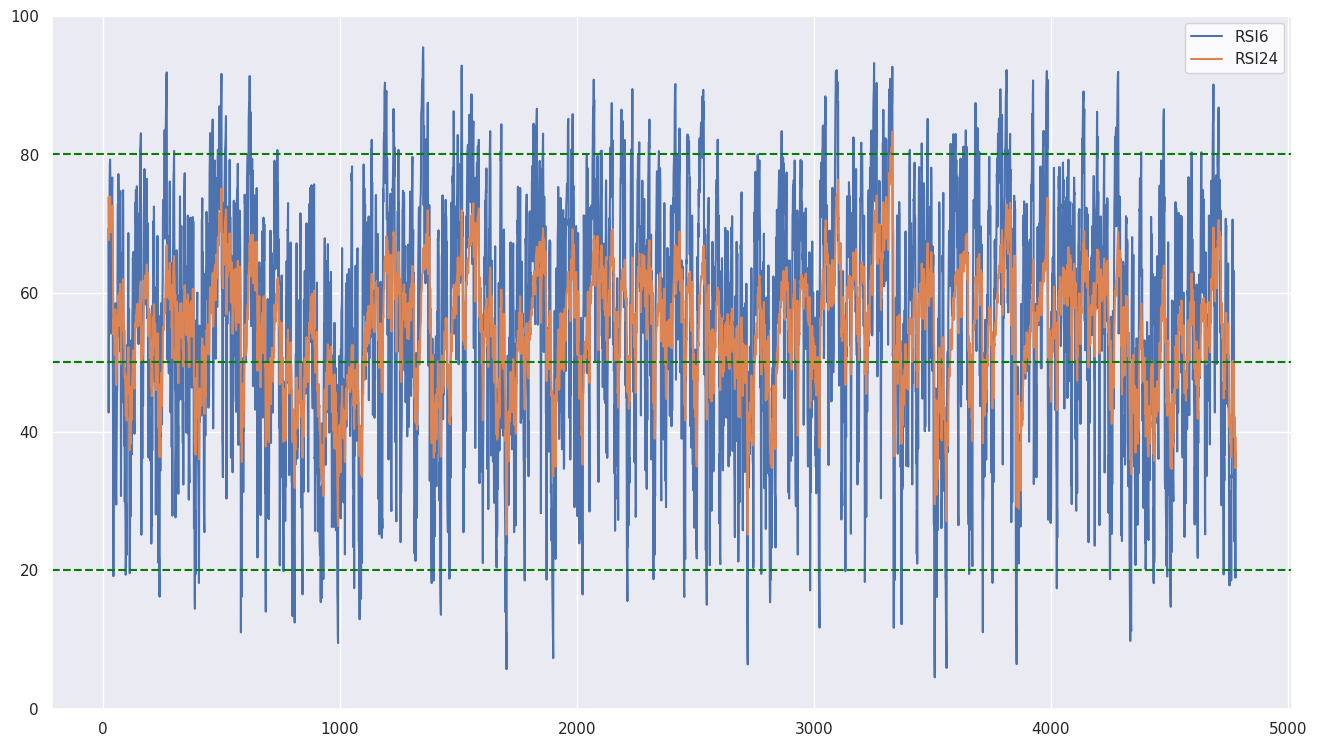

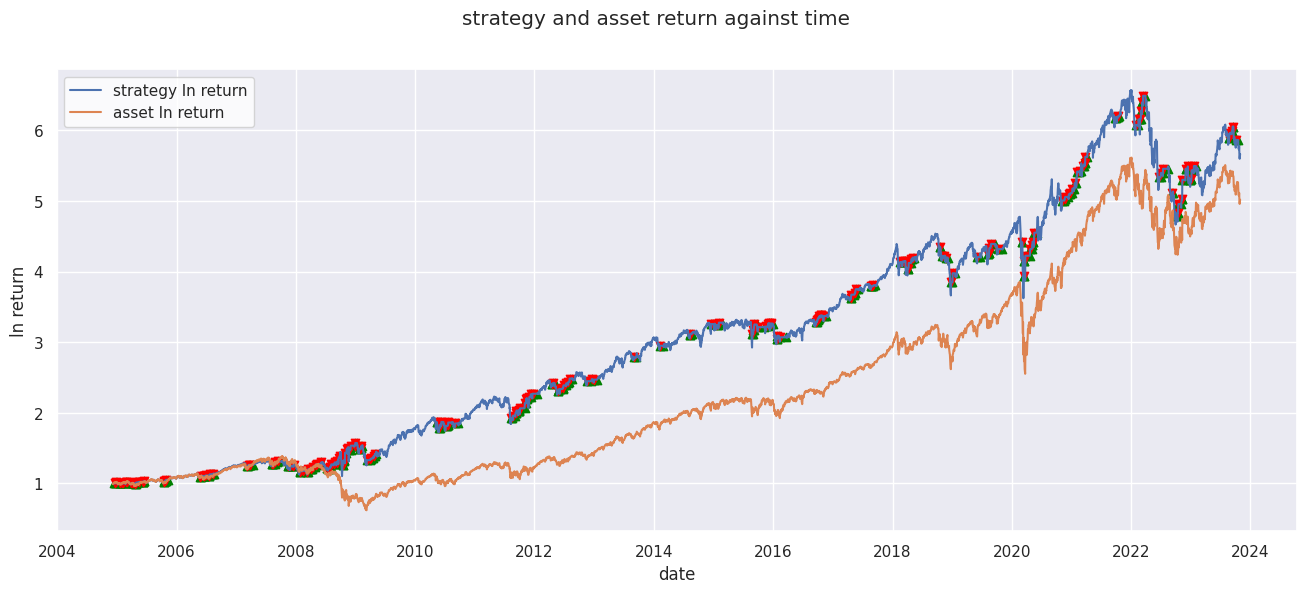

In [ ]:
sp500_RSI1 = get_RSI_data(df)
sp500_RSI = calc_RSI(sp500_RSI1,6)
sp500_RSI = calc_RSI(sp500_RSI1,24)

upper_threshold = 80
lower_threshold = 20
middle_line = 50

sp500_RSI[["RSI6","RSI24"]].dropna().plot(figsize = [16, 9])

plt.axhline(upper_threshold, color = "green", ls = "--")

plt.axhline(middle_line, color = "green", ls = "--")

plt.axhline(lower_threshold, color = "green", ls = "--")
sp500_RSI = sp500_RSI.dropna()
sp500_RSI["trading_positions"] =\
(
    np
    .where(((sp500_RSI["RSI6"]<lower_threshold)),
           1, np.nan)
)

sp500_RSI["trading_positions"] =\
(
    np
    .where(((sp500_RSI["RSI6"]>upper_threshold)),
           -1, sp500_RSI["trading_positions"])
)


#Add Momentum Factor to improve strategy performance
sp500_RSI["trading_positions1"] =\
(
    np
    .where(((sp500_RSI["RSI6"].shift(1)<sp500_RSI["RSI24"].shift(1))&
            (sp500_RSI["RSI6"]>sp500_RSI["RSI24"])),
           1, np.nan))

sp500_RSI["trading_positions1"] =\
(
    np
    .where(((sp500_RSI["RSI6"].shift(1)>sp500_RSI["RSI24"].shift(1))&
            (sp500_RSI["RSI6"]<sp500_RSI["RSI24"])),
           -1, sp500_RSI["trading_positions1"]))
sp500_RSI = sp500_RSI.ffill()
sp500_RSI = sp500_RSI.fillna(0)

sp500_RSI["position"] = np.where(((sp500_RSI["trading_positions"]>0)|(sp500_RSI["trading_positions1"]>0)),-1,0)
sp500_RSI["position"] = np.where(((sp500_RSI["trading_positions"]<0)|(sp500_RSI["trading_positions1"]<0)),1,0)

sp500_RSI["trade"] = (sp500_RSI.position - sp500_RSI.position.shift(periods = 1).fillna(0))
sp500_RSI["ret_asset"] = np.log(sp500_RSI["price"]/sp500_RSI["price"].shift(1))
sp500_RSI = sp500_RSI.dropna()
sp500_RSI.index = sp500_RSI["date"]
sp500_RSI.drop(["date"], axis=1)
RSI_strategy = getReturnPerPositionStrategy(sp500_RSI)
RSI_strategy

In [ ]:
def optimize_RSI_advanced():
    best_short = 0
    best_long = 0
    max_cumulative_returns = float('-inf')


    # Define the range of short and long windows to test
    short_window_range = range(1, 15, 1)
    long_window_range = range(15, 30, 1)

    for short_window in short_window_range:
        for long_window in long_window_range:
            if short_window < long_window:

                sp500_RSI = get_RSI_data(df_sp500_price)

                df_strategy_RSI = calc_RSI(sp500_RSI, short_window)

                df_strategy_RSI = calc_RSI(sp500_RSI, long_window)

                df_strategy_RSI["trading_positions"] =\
(
    np
    .where(((df_strategy_RSI["RSI"+str(short_window)]<lower_threshold)),
           1, np.nan)
)

                df_strategy_RSI["trading_positions"] =\
(
    np
    .where(((df_strategy_RSI["RSI"+str(short_window)]>upper_threshold)),
           -1, df_strategy_RSI["trading_positions"])
)


#Add Momentum Factor to improve strategy performance
                df_strategy_RSI["trading_positions1"] =\
(
    np
    .where(((df_strategy_RSI["RSI"+str(short_window)].shift(1)<df_strategy_RSI["RSI"+str(long_window)].shift(1))&
            (df_strategy_RSI["RSI"+str(short_window)]>df_strategy_RSI["RSI"+str(long_window)])),
           1, np.nan))

                df_strategy_RSI["trading_positions1"] =\
(
    np
    .where(((df_strategy_RSI["RSI"+str(short_window)].shift(1)>df_strategy_RSI["RSI"+str(long_window)].shift(1))&
            (df_strategy_RSI["RSI"+str(short_window)]<df_strategy_RSI["RSI"+str(long_window)])),
           -1, df_strategy_RSI["trading_positions1"]))

                df_strategy_RSI = df_strategy_RSI.ffill()
                df_strategy_RSI = df_strategy_RSI.fillna(0)

                df_strategy_RSI["position"] = np.where(((df_strategy_RSI["trading_positions"]>0)|(df_strategy_RSI["trading_positions1"]>0)),-1,0)
                df_strategy_RSI["position"] = np.where(((df_strategy_RSI["trading_positions"]<0)|(df_strategy_RSI["trading_positions1"]<0)),1,0)


                df_strategy_RSI["ret_asset"] = np.log(df_strategy_RSI["price"]/df_strategy_RSI["price"].shift(1))
                df_strategy_RSI["strategy"]      = df_strategy_RSI.position
                df_strategy_RSI["ret_strategy"]  = df_strategy_RSI.strategy.shift(1) * df_strategy_RSI.ret_asset
                df_strategy_RSI = df_strategy_RSI.dropna()
                df_strategy_RSI["ret_cum_strategy"]  = df_strategy_RSI.ret_strategy.cumsum().apply(np.exp)

                final_cumulative_returns = df_strategy_RSI['ret_cum_strategy'].iloc[-1]

                if final_cumulative_returns > max_cumulative_returns:
                    max_cumulative_returns = final_cumulative_returns
                    best_short = short_window
                    best_long = long_window


    return best_short, best_long, max_cumulative_returns

# Call the function to get the optimal short and long windows
optimal_short, optimal_long, max_returns = optimize_RSI_advanced()

print(f"Optimal Short Window: {optimal_short}")
print(f"Optimal Long Window: {optimal_long}")
print(f"Max Cumulative Returns: {max_returns}")

Optimal Short Window: 5
Optimal Long Window: 18
Max Cumulative Returns: 9.432266488201954


date       price  ret_asset    Return   up_sign  down_sign  \
date                                                                          
2004-11-29 2004-11-29   81.837967  -0.004573 -0.375099  0.000000   0.375099   
2004-11-30 2004-11-30   81.893509   0.000678  0.055542  0.055542   0.000000   
2004-12-01 2004-12-01   82.824394   0.011303  0.930885  0.930885   0.000000   
2004-12-02 2004-12-02   82.893814   0.000838  0.069420  0.069420   0.000000   
2004-12-03 2004-12-03   82.838257  -0.000670 -0.055557  0.000000   0.055557   
...               ...         ...        ...       ...       ...        ...   
2023-10-24 2023-10-24  423.630005   0.007511  3.170013  3.170013   0.000000   
2023-10-25 2023-10-25  417.549988  -0.014456 -6.080017  0.000000   6.080017   
2023-10-26 2023-10-26  412.549988  -0.012047 -5.000000  0.000000   5.000000   
2023-10-27 2023-10-27  410.679993  -0.004543 -1.869995  0.000000   1.869995   
2023-10-30 2023-10-30  415.589996   0.011885  4.910004  4.910004   0.000000   

                 RSI5      RSI18  trading_positions  trading_positions1  \
date                                                                      
2004-11-29  47.122588  70.803377                0.0                 0.0   
2004-11-30  49.340416  71.038009                0.0                 0.0   
2004-12-01  73.034819  74.652795                0.0                 0.0   
2004-12-02  74.161371  74.900159                0.0                 0.0   
2004-12-03  71.186208  74.285842                0.0                 0.0   
...               ...        ...                ...                 ...   
2023-10-24  37.086435  40.806211                1.0                -1.0   
2023-10-25  24.724423  36.178327                1.0                -1.0   
2023-10-26  18.414660  32.926752                1.0                -1.0   
2023-10-27  16.451835  31.795134                1.0                -1.0   
2023-10-30  38.105129  37.743538                1.0                 1.0   

            position  trade  strategy  ret_strategy  ret_cum_asset  \
date                                                                 
2004-11-29         0    0.0         0           NaN       0.995437   
2004-11-30         0    0.0         0      0.000000       0.996113   
2004-12-01         0    0.0         0      0.000000       1.007436   
2004-12-02         0    0.0         0      0.000000       1.008280   
2004-12-03         0    0.0         0     -0.000000       1.007605   
...              ...    ...       ...           ...            ...   
2023-10-24         1    0.0         1      0.007511       5.152831   
2023-10-25         1    0.0         1     -0.014456       5.078876   
2023-10-26         1    0.0         1     -0.012047       5.018059   
2023-10-27         1    0.0         1     -0.004543       4.995313   
2023-10-30         0   -1.0         0      0.011885       5.055036   

            ret_cum_strategy  
date                          
2004-11-29               NaN  
2004-11-30          1.000000  
2004-12-01          1.000000  
2004-12-02          1.000000  
2004-12-03          1.000000  
...                      ...  
2023-10-24          9.294271  
2023-10-25          9.160878  
2023-10-26          9.051180  
2023-10-27          9.010153  
2023-10-30          9.117876  

[4763 rows x 16 columns]

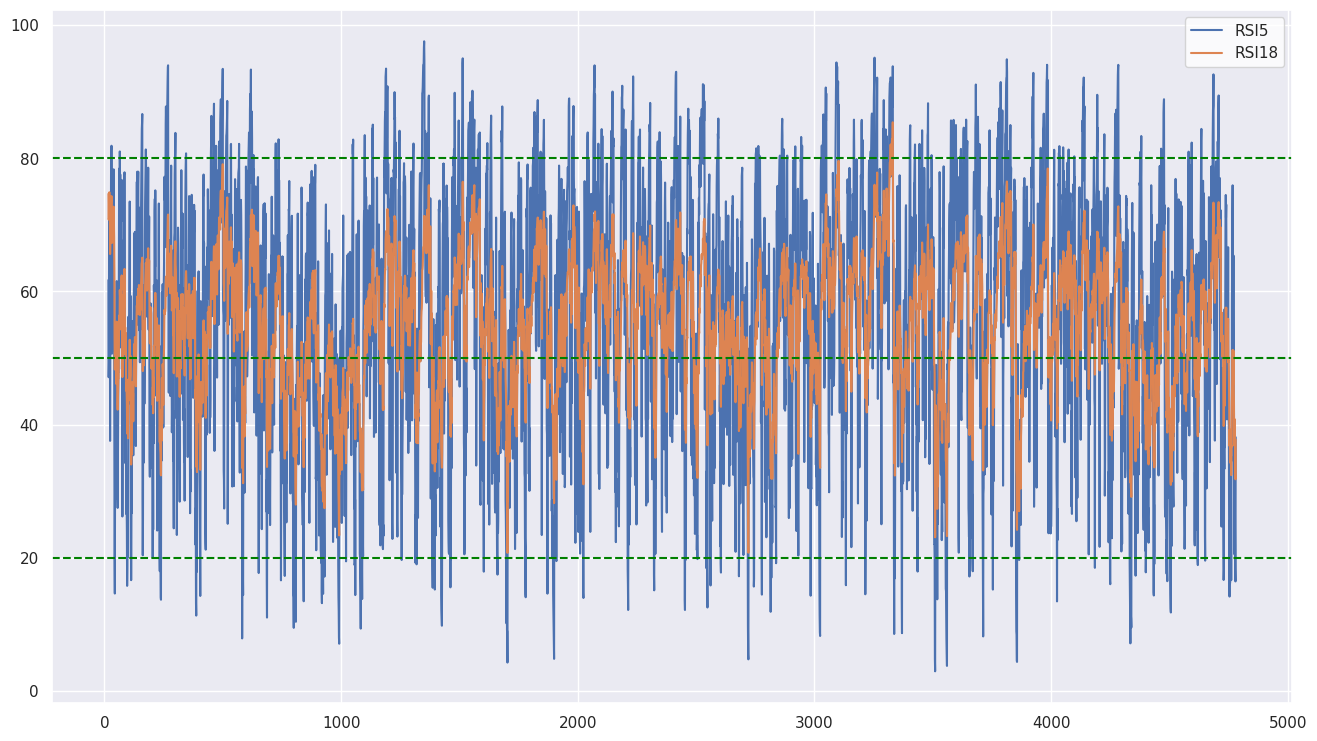

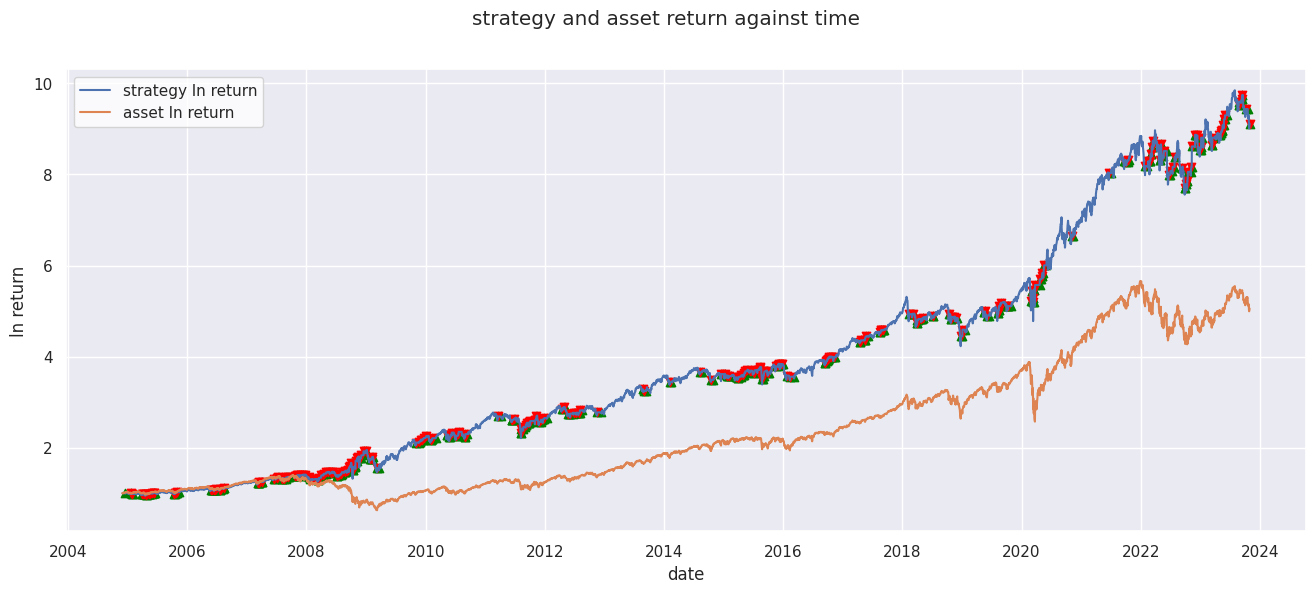

In [ ]:
sp500_RSI11 = get_RSI_data(df_sp500_price)
sp500_RSI_optimize1 = calc_RSI(sp500_RSI11,5)
sp500_RSI_optimize1 = calc_RSI(sp500_RSI11,18)

upper_threshold = 80
lower_threshold = 20
middle_line = 50

sp500_RSI_optimize1[["RSI5","RSI18"]].dropna().plot(figsize = [16, 9])

plt.axhline(upper_threshold, color = "green", ls = "--")

plt.axhline(middle_line, color = "green", ls = "--")

plt.axhline(lower_threshold, color = "green", ls = "--")

sp500_RSI_optimize1 = sp500_RSI_optimize1.dropna()
sp500_RSI_optimize1["trading_positions"] =\
(
    np
    .where(((sp500_RSI_optimize1["RSI5"]<lower_threshold)),
           1, np.nan)
)

sp500_RSI_optimize1["trading_positions"] =\
(
    np
    .where(((sp500_RSI_optimize1["RSI5"]>upper_threshold)),
           -1, sp500_RSI_optimize1["trading_positions"])
)


#Add Momentum Factor to improve strategy performance
sp500_RSI_optimize1["trading_positions1"] =\
(
    np
    .where(((sp500_RSI_optimize1["RSI5"].shift(1)<sp500_RSI_optimize1["RSI18"].shift(1))&
            (sp500_RSI_optimize1["RSI5"]>sp500_RSI_optimize1["RSI18"])),
           1, np.nan))

sp500_RSI_optimize1["trading_positions1"] =\
(
    np
    .where(((sp500_RSI_optimize1["RSI5"].shift(1)>sp500_RSI_optimize1["RSI18"].shift(1))&
            (sp500_RSI_optimize1["RSI5"]<sp500_RSI_optimize1["RSI18"])),
           -1, sp500_RSI_optimize1["trading_positions1"]))

sp500_RSI_optimize1 = sp500_RSI_optimize1.ffill()
sp500_RSI_optimize1 = sp500_RSI_optimize1.fillna(0)

sp500_RSI_optimize1["position"] = np.where(((sp500_RSI_optimize1["trading_positions"]>0)|(sp500_RSI_optimize1["trading_positions1"]>0)),-1,0)
sp500_RSI_optimize1["position"] = np.where(((sp500_RSI_optimize1["trading_positions"]<0)|(sp500_RSI_optimize1["trading_positions1"]<0)),1,0)

sp500_RSI_optimize1["trade"] = (sp500_RSI_optimize1.position - sp500_RSI_optimize1.position.shift(periods = 1).fillna(0))

sp500_RSI_optimize1["ret_asset"] = np.log(sp500_RSI_optimize1["price"]/sp500_RSI_optimize1["price"].shift(1))
sp500_RSI_optimize1 = sp500_RSI_optimize1.dropna()
sp500_RSI_optimize1.index = sp500_RSI_optimize1["date"]
sp500_RSI_optimize1.drop(["date"], axis=1)
RSI_strategy_final = getReturnPerPositionStrategy(sp500_RSI_optimize1)
RSI_strategy_final

2.2.2 KDJ + Mean-Reversion Factors

In addition to the conventional methods of capturing KDJ signals, the golden cross and death cross formed by the K and D lines have been added. However, in practical application, it has been found that selling stocks when there is a golden cross and buying stocks when there is a death cross can improve the performance of the strategy. Therefore, the buying and selling signal brought by the intersection of the K and D lines is used as a new mean regression factor.

In [ ]:
def optimize_KDJ_advanced():
    max_cumulative_returns = float('-inf')

    # Define the range of short and long windows to test
    window_range = range(2, 30, 1)

    for window in window_range:

        df_strategy_KDJ = calc_KDJ(window)


        df_strategy_KDJ = df_strategy_KDJ.dropna()
        df_strategy_KDJ["Ksignal"] = np.where((df_strategy_KDJ['KValue']>80),-1,np.where((df_strategy_KDJ['KValue']<20),1,0))
        df_strategy_KDJ["Dsignal"] = np.where((df_strategy_KDJ['DValue']>80),-1,np.where((df_strategy_KDJ['DValue']<20),1,0))
        df_strategy_KDJ["Jsignal"] = np.where((df_strategy_KDJ['JValue']>100),-1,np.where((df_strategy_KDJ['JValue']<0),1,0))
        df_strategy_KDJ["KDsignal"] =\
(
    np
    .where(((df_strategy_KDJ["KValue"].shift(1)<df_strategy_KDJ["DValue"].shift(1))&
            (df_strategy_KDJ["KValue"]>df_strategy_KDJ["DValue"])),
           -1, 0))

        df_strategy_KDJ["KDsignal"] =\
(
    np
    .where(((df_strategy_KDJ["KValue"].shift(1)>df_strategy_KDJ["DValue"].shift(1))&
            (df_strategy_KDJ["KValue"]<df_strategy_KDJ["DValue"])),
           1, df_strategy_KDJ["KDsignal"]))

        df_strategy_KDJ["KDJsig"] = df_strategy_KDJ["Ksignal"]+df_strategy_KDJ["Dsignal"]+df_strategy_KDJ["Jsignal"]

        df_strategy_KDJ["position"] = np.where(((df_strategy_KDJ["KDJsig"]>0)|(df_strategy_KDJ["KDsignal"]>0)),1,0)
        df_strategy_KDJ["position"] =  np.where(((df_strategy_KDJ["KDJsig"]<0)|(df_strategy_KDJ["KDsignal"]<0)),-1,df_strategy_KDJ["position"])


        df_strategy_KDJ["position"] = df_strategy_KDJ["position"].ffill()
        df_strategy_KDJ = df_strategy_KDJ.fillna(0)

        df_strategy_KDJ['ret_strategy'] = df_strategy_KDJ['position'].shift(1) * df_strategy_KDJ["ret_asset"]
        df_strategy_KDJ = df_strategy_KDJ.dropna()
        df_strategy_KDJ['ret_cum_strategy'] = df_strategy_KDJ['ret_strategy'].cumsum().apply(np.exp)

        final_cumulative_returns = df_strategy_KDJ['ret_cum_strategy'].iloc[-1]

        if final_cumulative_returns > max_cumulative_returns:
            max_cumulative_returns = final_cumulative_returns
            best_window = window
        else:
            continue


    return  best_window, max_cumulative_returns

# Call the function to get the optimal short and long windows
optimal_window,  max_returns = optimize_KDJ_advanced()


print(f"Optimal Window: {optimal_window}")
print(f"Max Cumulative Returns: {max_returns}")


sp500_KDJ = calc_KDJ(4)
sp500_KDJ = sp500_KDJ.dropna()
sp500_KDJ["Ksignal"] = np.where((sp500_KDJ['KValue']>80),-1,np.where((sp500_KDJ['KValue']<20),1,0))
sp500_KDJ["Dsignal"] = np.where((sp500_KDJ['DValue']>80),-1,np.where((sp500_KDJ['DValue']<20),1,0))
sp500_KDJ["Jsignal"] = np.where((sp500_KDJ['JValue']>100),-1,np.where((sp500_KDJ['JValue']<0),1,0))



sp500_KDJ["KDsignal"] =\
(
    np
    .where(((sp500_KDJ["KValue"].shift(1)<sp500_KDJ["DValue"].shift(1))&
            (sp500_KDJ["KValue"]>sp500_KDJ["DValue"])),
           -1, 0))

sp500_KDJ["KDsignal"] =\
(
    np
    .where(((sp500_KDJ["KValue"].shift(1)>sp500_KDJ["DValue"].shift(1))&
            (sp500_KDJ["KValue"]<sp500_KDJ["DValue"])),
           1, sp500_KDJ["KDsignal"]))
sp500_KDJ["KDJsig"] = sp500_KDJ["Ksignal"]+sp500_KDJ["Dsignal"]+sp500_KDJ["Jsignal"]

sp500_KDJ["position"] = np.where(((sp500_KDJ["KDJsig"]>0)|(sp500_KDJ["KDsignal"]>0)),1,0)
sp500_KDJ["position"] =  np.where(((sp500_KDJ["KDJsig"]<0)|(sp500_KDJ["KDsignal"]<0)),-1,sp500_KDJ["position"])



sp500_KDJ["ret_asset"] = np.log(sp500_KDJ["price"]/sp500_KDJ["price"].shift(1))
sp500_KDJ["trade"] = (sp500_KDJ.position - sp500_KDJ.position.shift(periods = 1).fillna(0))
KDJ_strategy = getReturnPerPositionStrategy(sp500_KDJ)
KDJ_strategy

KeyboardInterrupt: ignored

2.2.3
Simple Moving Average on Volume

##### This strategy deploys simple moving averages on daily volume. The shorter and longer window is define by hyperparameter tuning base on the best cumulative return. Whenever the shorter window cross and more than the longer window, a long position, else a short position. This strategy beat the long and hold SPY for the same period, more details on the result can be found below.

In [ ]:
import numpy as np
import pandas as pd
import datetime   as dt
import yfinance   as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt


yf.pdr_override()


DATE_BEGIN  = dt.date(2004, 11, 1)
DATE_END    = dt.date(2023, 10, 31)
LIST_TICKER = ["SPY"] # US dollar index
df_raw = yf.download(LIST_TICKER, DATE_BEGIN, DATE_END)



df_raw['Log_ret'] = np.log(df_raw['Adj Close']/df_raw['Adj Close'].shift(1))

import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df_raw.index, y=df_raw['Adj Close'], name='SPY ADJ Close'), secondary_y=False)
fig.add_trace(go.Bar(x=df_raw.index, y=df_raw['Volume'], name='Volume', opacity = 0.5), secondary_y=True)

fig.update_layout(
    title='Adj Close Prices',
    xaxis_title='Date',
    yaxis_title='Price',
    template='plotly_white',
    xaxis_rangeslider_visible=True,
    hovermode='x'
)
fig.layout.yaxis2.showgrid=False

fig.show()

cum_max =  0
for i in range(1,100):

    for u in range(1,200):

        raw = df_raw.copy()
        raw['Log_ret'] = np.log(raw['Adj Close']/raw['Adj Close'].shift(1))

        #raw["shorter_SMA"] =raw["Volume"].ewm(i, min_periods = 1).mean()
        #raw["longer_SMA"] =raw["Volume"].ewm(u, min_periods = 1).mean()

        raw["shorter_SMA"] =raw["Volume"].rolling(window = i, min_periods = 1,center = False).mean()
        raw["longer_SMA"] =raw["Volume"].rolling(window = u, min_periods = 1,center = False).mean()

        raw["position"] = 0

        raw["position"] =np.where(raw["shorter_SMA"] > raw["longer_SMA"],1.0,0.0)
        raw["buy_sell"] = raw["position"].diff()
        raw ['STRATEGY'] = raw["position"].shift(1)*raw["Log_ret"]
        raw =raw.rename(columns = {'Adj Close':'SPY'})
        raw['cum_return'] = raw['STRATEGY'].cumsum().apply(np.exp)
        raw['cum_max'] = raw['cum_return'].cummax()


        if raw['cum_return'].iloc[-1] >= cum_max:

            print(f"Short:{i}, long:{u}, cum_ret = {raw['cum_max'].iloc[-1]}")
            cum_max =  raw['cum_max'].iloc[-1]
        else:
            continue

print()
short = 41
long = 40

df_raw["shorter_SMA"] =df_raw["Volume"].rolling(window = short, min_periods = 1,center = False).mean()
df_raw["longer_SMA"] =df_raw["Volume"].rolling(window = long, min_periods = 1,center = False).mean()

# df_raw["shorter_SMA"] =df_raw["Volume"].ewm(short, min_periods = 1).mean()
# df_raw["longer_SMA"] =df_raw["Volume"].ewm(long, min_periods = 1).mean()

df_raw["position"] = 0

df_raw["position"] =np.where(df_raw["shorter_SMA"] > df_raw["longer_SMA"],1.0,0.0)
df_raw["buy_sell"] = df_raw["position"].diff()
df_raw ['STRATEGY'] = df_raw["position"].shift(1)*df_raw["Log_ret"]
df_raw =df_raw.rename(columns = {'Adj Close':'SPY'})
df_raw['cum_return'] = df_raw['STRATEGY'].cumsum().apply(np.exp)
df_raw['cum_max'] = df_raw['cum_return'].cummax()

def sharpe_ratio(ts_returns, periods_per_year = 252,log=False):
    n_years = ts_returns.shape[0]/periods_per_year
    if log ==False:
        annualized_return = np.power(np.prod(1 + ts_returns), (1 / n_years)) - 1
        annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
        annualized_sharpe = annualized_return / annualized_vol
        # for simple return
    else:
        annualized_return = np.exp((ts_returns.sum() / n_years))-1
        annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
        annualized_sharpe = annualized_return / annualized_vol
    return annualized_return,annualized_vol,annualized_sharpe

def drawdown(drawdown, n=5):
    period = (drawdown[drawdown  == 0].index[1:].to_pydatetime() - drawdown[drawdown  == 0].index[:-1].to_pydatetime())
    worst_draw = pd.DataFrame(period,columns=['period']).sort_values(by='period',ascending=False).head()
    max_draw = []
    for i in range(n):
        date_1 = drawdown[drawdown == 0].index[worst_draw.index[i]]
        date_2 = drawdown[drawdown == 0].index[worst_draw.index[i]+1]
        max_draw.append(drawdown.loc[date_1:date_2].max())
    worst_draw['max_draw']= max_draw
    return worst_draw

def backtest(df, capital = 1e5):

    annual_returns, annual_vol, sharpe = sharpe_ratio(df['STRATEGY'], log =True)
    annual_returns_spy, annual_vol_spy, sharpe_spy = sharpe_ratio(df['Log_ret'], log =True)


    dollar = df['STRATEGY'].cumsum().apply(np.exp).iloc[-1]*capital
    dollar_spy = df['Log_ret'].cumsum().apply(np.exp).iloc[-1]*capital

    cum_ret = df['STRATEGY'].cumsum().apply(np.exp).iloc[-1]
    cum_ret_spy = df['Log_ret'].cumsum().apply(np.exp).iloc[-1]
    max_drawdown = drawdown(df['STRATEGY'])

    summary = pd.DataFrame( {'Annual_return(%)':[annual_returns*100,annual_returns_spy*100],\
                             'Annual_vol(%)':[annual_vol*100,annual_vol_spy*100],\
                             'Sharpe_ratio':[sharpe,sharpe_spy],\
                             'Cum_ret':[cum_ret,cum_ret_spy],\
                             'P&L($)':[dollar,dollar_spy]}, index = ['Strategy','long&hold'])

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 10))

    axes[0].plot(df["SPY"],color = "black",lw = 0.80)
    axes[0].plot(df['SPY'].loc[df.buy_sell == 1.0].index,df['SPY'][df.buy_sell == 1.0],"^",color = "green",markersize = 6, label = 'Long')
    axes[0].plot(df['SPY'].loc[df.buy_sell == -1.0].index,df['SPY'][df.buy_sell == -1.0],"^",color = "red",markersize = 3, label = 'Short')
    axes[0].set_title('Position')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Price')
    axes[0].legend()

    axes[1].plot(df[['STRATEGY','Log_ret']].dropna().cumsum().apply(np.exp))
    axes[1].set_title('Cumulative Return')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Cumulative Return')
    axes[1].legend(['STRATEGY','long&hold'])

    axes[2].plot(df[['cum_return','cum_max']])
    axes[2].set_title('Drawdown(strategy)')
    axes[2].set_xlabel('Time')
    axes[2].set_ylabel('Cumulative Return')
    axes[2].legend(['cum_return','cum_max'])



    plt.subplots_adjust(hspace=0.5)

    print(summary)
    print()
    print(f' Max drawdown for Strategy \n\n {max_drawdown}')

backtest(df_raw)

[*********************100%%**********************]  1 of 1 completed


Short:1, long:1, cum_ret = 1.0
Short:1, long:2, cum_ret = 1.849004929837032
Short:1, long:3, cum_ret = 2.4667823316244335
Short:1, long:9, cum_ret = 2.8605102710253205
Short:1, long:60, cum_ret = 3.263757945555121
Short:1, long:70, cum_ret = 4.093528682900443
Short:5, long:3, cum_ret = 4.746190484614131
Short:8, long:7, cum_ret = 5.575808532576938


KeyboardInterrupt: ignored

### <a id = "s3">=== PART 3: MACHINE LEARNING STRATEGIES ===</a>
[contents](#top)

In [ ]:
df  = df_sp500_price_bkup.copy()

### OLS

This strategy is by using OLS to predict the daily log return of SPY Adj Close price. The endogeous variables are 1. US dollar index, 2. USDGBP FX, 3. lag values of SPY Adj Close price, up to 5 lags. We tried other endogeous variables as well, like VIX index, USDJPY, Amazon and Google stock price, however, the t-stats were not significant. The results are remarkable and too good to be true. It beats the  long and hold SPY for the same period by 6000 plus times in terms of cumulative return. More details can be fo

[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  1 of 1 completed

                            OLS Regression Results                            
Dep. Variable:                Log_ret   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     77.24
Date:                Sun, 19 Nov 2023   Prob (F-statistic):          1.26e-119
Time:                        09:55:24   Log-Likelihood:                 13176.
No. Observations:                4339   AIC:                        -2.633e+04
Df Residuals:                    4330   BIC:                        -2.628e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025     

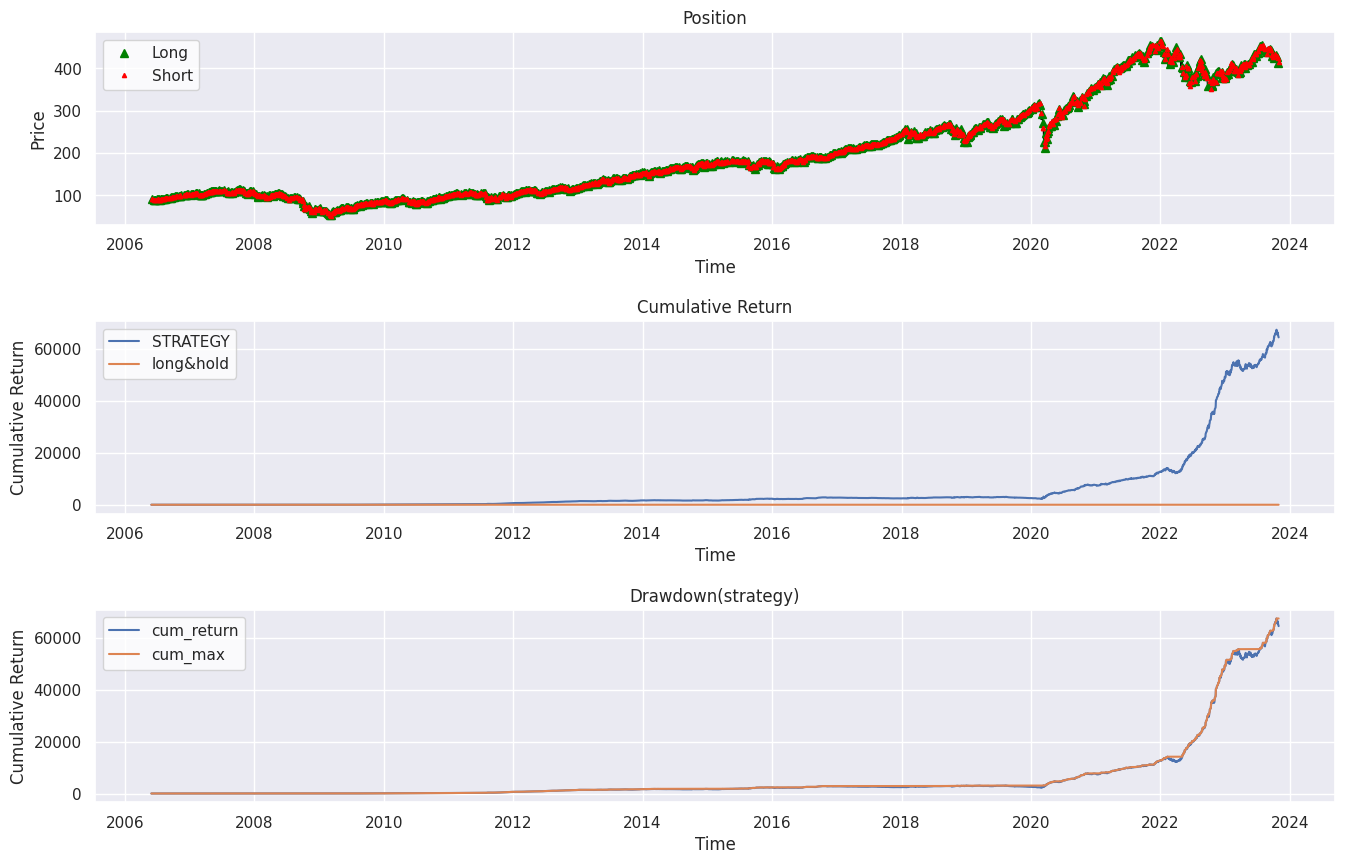

In [ ]:
yf.pdr_override()
LIST_TICKER = ["SPY",'DX-Y.NYB'] # US dollar index
#index_ticker = [ "VIXCLS"]
currency_ticker = ["DEXUSUK"]
#stock_list = ['AMZN','GOOGL']

DATE_BEGIN  = dt.date(2004, 11, 1)
DATE_END    = dt.date(2023, 10, 31)
df_raw  = yf.download(LIST_TICKER, DATE_BEGIN, DATE_END)
currency_data = pdr.get_data_fred(currency_ticker, DATE_BEGIN, DATE_END)
gold =pdr.get_data_yahoo("GDX",start = DATE_BEGIN,end = DATE_END)

#index_data = pdr.get_data_fred(index_ticker, DATE_BEGIN, DATE_END)
#stock_data  = yf.download(stock_list, DATE_BEGIN, DATE_END)

print()

capital = 1e5

log_ret = np.log(df_raw['Adj Close']['SPY']/df_raw['Adj Close']['SPY'].shift(1))
#log_ret = df_raw['Adj Close']['SPY'].pct_change()
log_ret = pd.DataFrame(log_ret)
log_ret = log_ret.rename(columns = {'SPY':'Log_ret'})

df = pd.concat([df_raw['Adj Close']['DX-Y.NYB'],currency_data,gold['Adj Close'].rename('Gold')], axis=1).dropna()
df =np.log(df/df.shift(1))

df = pd.concat([df_raw['Adj Close']['SPY'],log_ret,df], axis=1).dropna()


LAGS = 5
for LAG in range(1, LAGS + 1):
    COL = f"lag_{LAG}"
    df[COL] = df["Log_ret"].shift(LAG)
df = df.dropna()

y = df['Log_ret']
x = df.iloc[:,2:]

x.shape[0] == y.shape[0]

OLS =np.linalg.lstsq(x,np.sign(y),rcond = None)
#OLS =np.linalg.lstsq(x,y,rcond = None)

df["PREDICTION"] =np.sign(np.dot(x,OLS[0]))
#df["PREDICTION"] =np.dot(x,OLS[0])

df["STRATEGY"] = df['Log_ret'] * df['PREDICTION']
df['buy_sell'] = df['PREDICTION'].diff()
#df['buy_sell'][0] = 2
df['cum_return'] = df['STRATEGY'].cumsum().apply(np.exp)
df['cum_max'] = df['cum_return'].cummax()


import statsmodels.api as sm

indep = sm.add_constant(x)
model = sm.OLS(y, indep).fit()
print(f'{model.summary()}\n')


def sharpe_ratio(ts_returns, periods_per_year = 252,log=False):
    n_years = ts_returns.shape[0]/periods_per_year
    if log ==False:
        annualized_return = np.power(np.prod(1 + ts_returns), (1 / n_years)) - 1
        annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
        annualized_sharpe = annualized_return / annualized_vol
        # for simple return
    else:
        annualized_return = np.exp((ts_returns.sum() / n_years))-1
        annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
        annualized_sharpe = annualized_return / annualized_vol
    return annualized_return,annualized_vol,annualized_sharpe

def drawdown(drawdown, n=5):
    period = (drawdown[drawdown  == 0].index[1:].to_pydatetime() - drawdown[drawdown  == 0].index[:-1].to_pydatetime())
    worst_draw = pd.DataFrame(period,columns=['period']).sort_values(by='period',ascending=False).head()
    max_draw = []
    for i in range(n):
        date_1 = drawdown[drawdown == 0].index[worst_draw.index[i]]
        date_2 = drawdown[drawdown == 0].index[worst_draw.index[i]+1]
        max_draw.append(drawdown.loc[date_1:date_2].max())
    worst_draw['max_draw'] = max_draw
    return worst_draw

def backtest(df):

    annual_returns, annual_vol, sharpe = sharpe_ratio(df['STRATEGY'], log =True)
    annual_returns_spy, annual_vol_spy, sharpe_spy = sharpe_ratio(df['Log_ret'], log =True)


    dollar = df['STRATEGY'].cumsum().apply(np.exp).iloc[-1]*capital
    dollar_spy = df['Log_ret'].cumsum().apply(np.exp).iloc[-1]*capital

    cum_ret = df['STRATEGY'].cumsum().apply(np.exp).iloc[-1]
    cum_ret_spy = df['Log_ret'].cumsum().apply(np.exp).iloc[-1]
    max_drawdown = drawdown(df['STRATEGY'])

    summary = pd.DataFrame( {'Annual_return':[annual_returns*100,annual_returns_spy*100],\
                             'Annual_vol':[annual_vol*100,annual_vol_spy*100],\
                             'Sharpe_ratio':[sharpe,sharpe_spy],\
                             'Cum_ret':[cum_ret,cum_ret_spy],\
                             'P&L($)':[dollar,dollar_spy]}, index = ['Strategy','Long&hold'])

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 10))

    axes[0].plot(df["SPY"],color = "black",lw = 0.80)
    axes[0].plot(df['SPY'].loc[df.buy_sell == 2.0].index,df['SPY'][df.buy_sell == 2.0],"^",color = "green",markersize = 6, label = 'Long')
    axes[0].plot(df['SPY'].loc[df.buy_sell == -2.0].index,df['SPY'][df.buy_sell == -2.0],"^",color = "red",markersize = 3, label = 'Short')
    axes[0].set_title('Position')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Price')
    axes[0].legend()

    axes[1].plot(df[['STRATEGY','Log_ret']].dropna().cumsum().apply(np.exp))
    axes[1].set_title('Cumulative Return')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Cumulative Return')
    axes[1].legend(['STRATEGY','long&hold'])

    axes[2].plot(df[['cum_return','cum_max']])
    axes[2].set_title('Drawdown(strategy)')
    axes[2].set_xlabel('Time')
    axes[2].set_ylabel('Cumulative Return')
    axes[2].legend(['cum_return','cum_max'])

    plt.subplots_adjust(hspace=0.5)

    print(summary)
    print()
    print(f' Max drawdown for Strategy \n\n {max_drawdown}')

backtest(df)

In [ ]:
df_sp500_price_bkup


price  ret_asset
date                             
2004-11-01   78.617935   0.000000
2004-11-02   78.645630   0.000352
2004-11-03   79.636063   0.012515
2004-11-04   80.723488   0.013563
2004-11-05   81.229073   0.006244
...                ...        ...
2023-10-24  423.630005   0.007511
2023-10-25  417.549988  -0.014456
2023-10-26  412.549988  -0.012047
2023-10-27  410.679993  -0.004543
2023-10-30  415.589996   0.011885

[4782 rows x 2 columns]

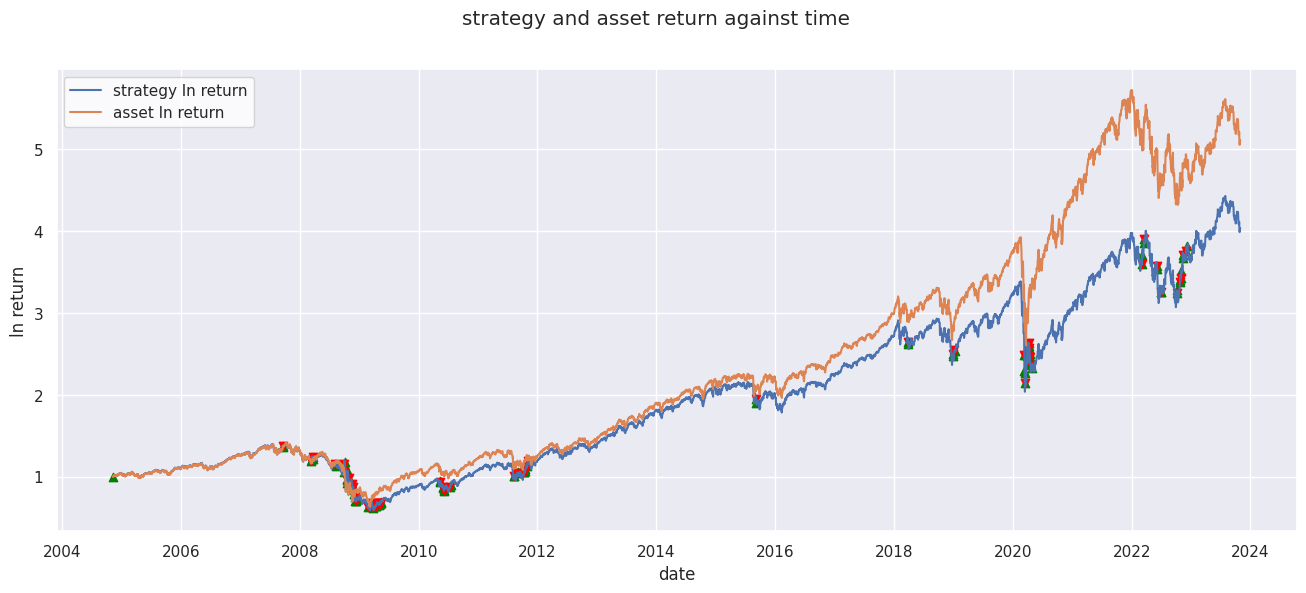

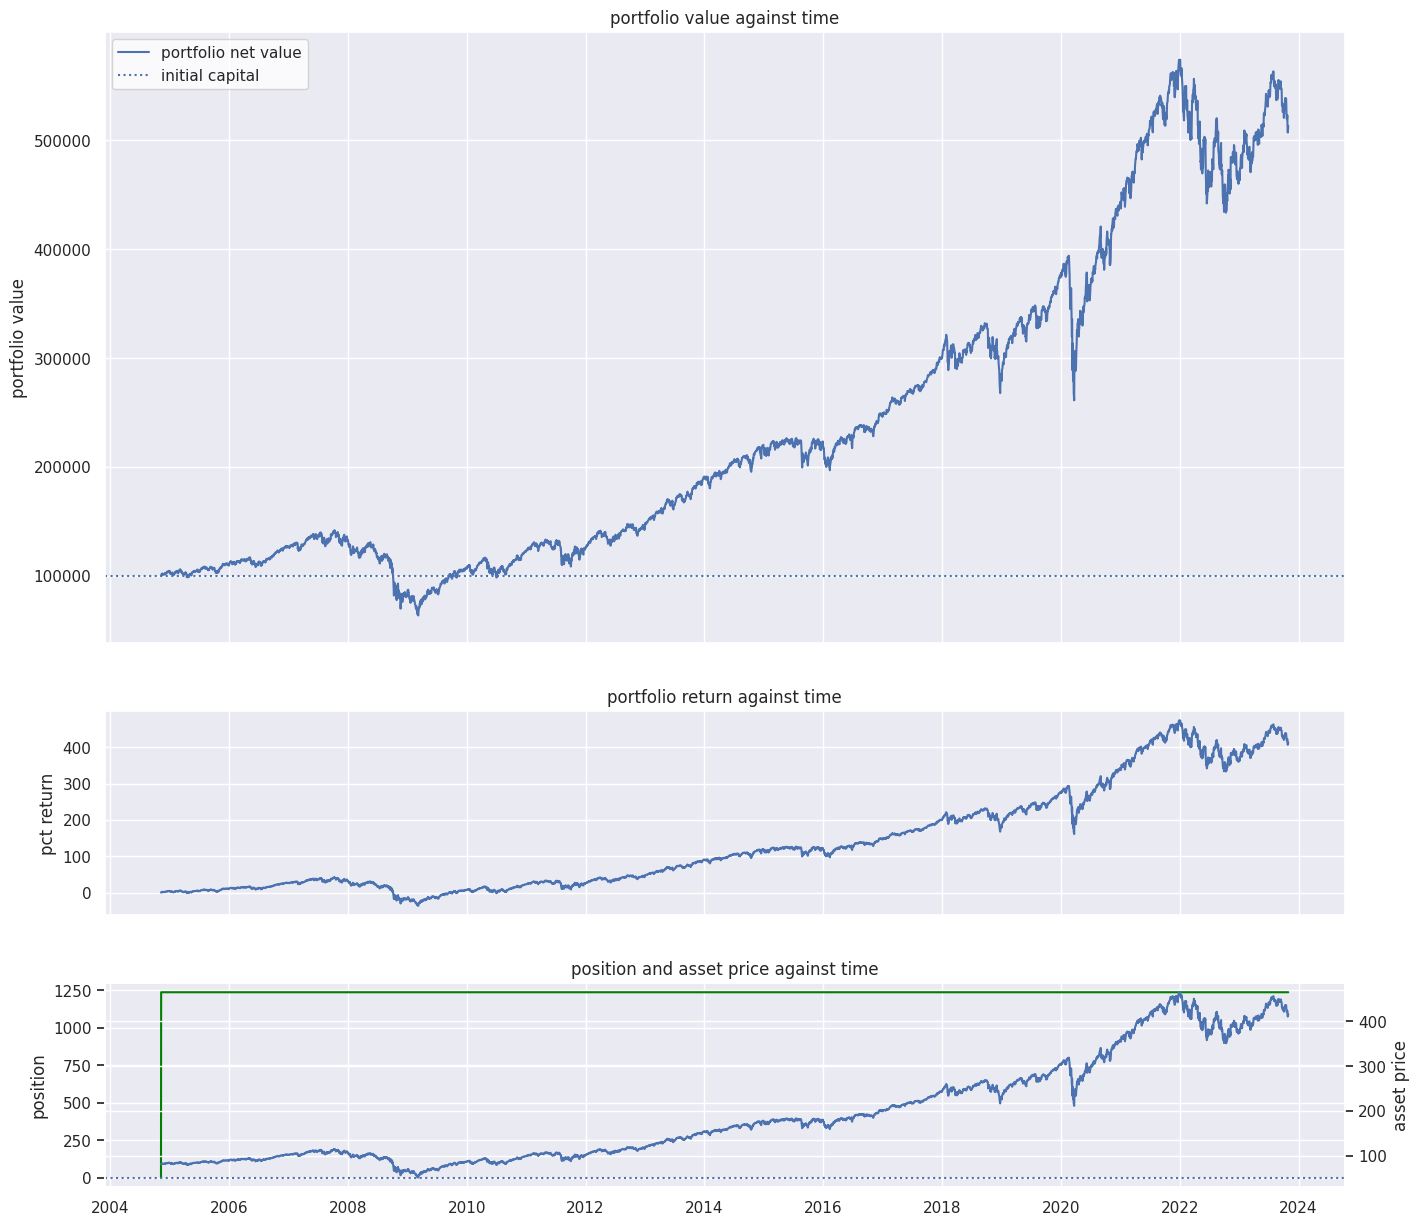

{'value_final': 513277.8834915161, 'ret_portfolio': 4.132778834915161, 'return': 0.09011688712062105, 'volatility': 0.193025253990523, 'sharpe': 0.46686578702828974, 'cagr': 0.08996851022846064}

=== MAX DRAWDOWN ON SORT BY MAX VALUES ===
              return  drawdown  drawdown_max  drawdown_period
date                                                         
2022-10-12  3.335511 -1.406535     -1.406535  0 days 00:00:00
2022-09-30  3.343050 -1.398996     -1.398996  0 days 00:00:00
2022-09-29  3.411260 -1.330786     -1.330786  0 days 00:00:00
2020-03-23  1.611510 -1.328322     -1.328322  0 days 00:00:00
2020-03-20  1.680027 -1.259805     -1.259805  0 days 00:00:00

=== MAX DRAWDOWN ON DRAWDOWN PERIOD ===
              return  drawdown  drawdown_max     drawdown_period
date                                                            
2020-03-11  2.194856 -0.744976     -0.781617  4020 days 00:00:00
2022-09-28  3.505367 -1.236679     -1.328322   919 days 00:00:00
2006-06-09  0.104135 -0.06

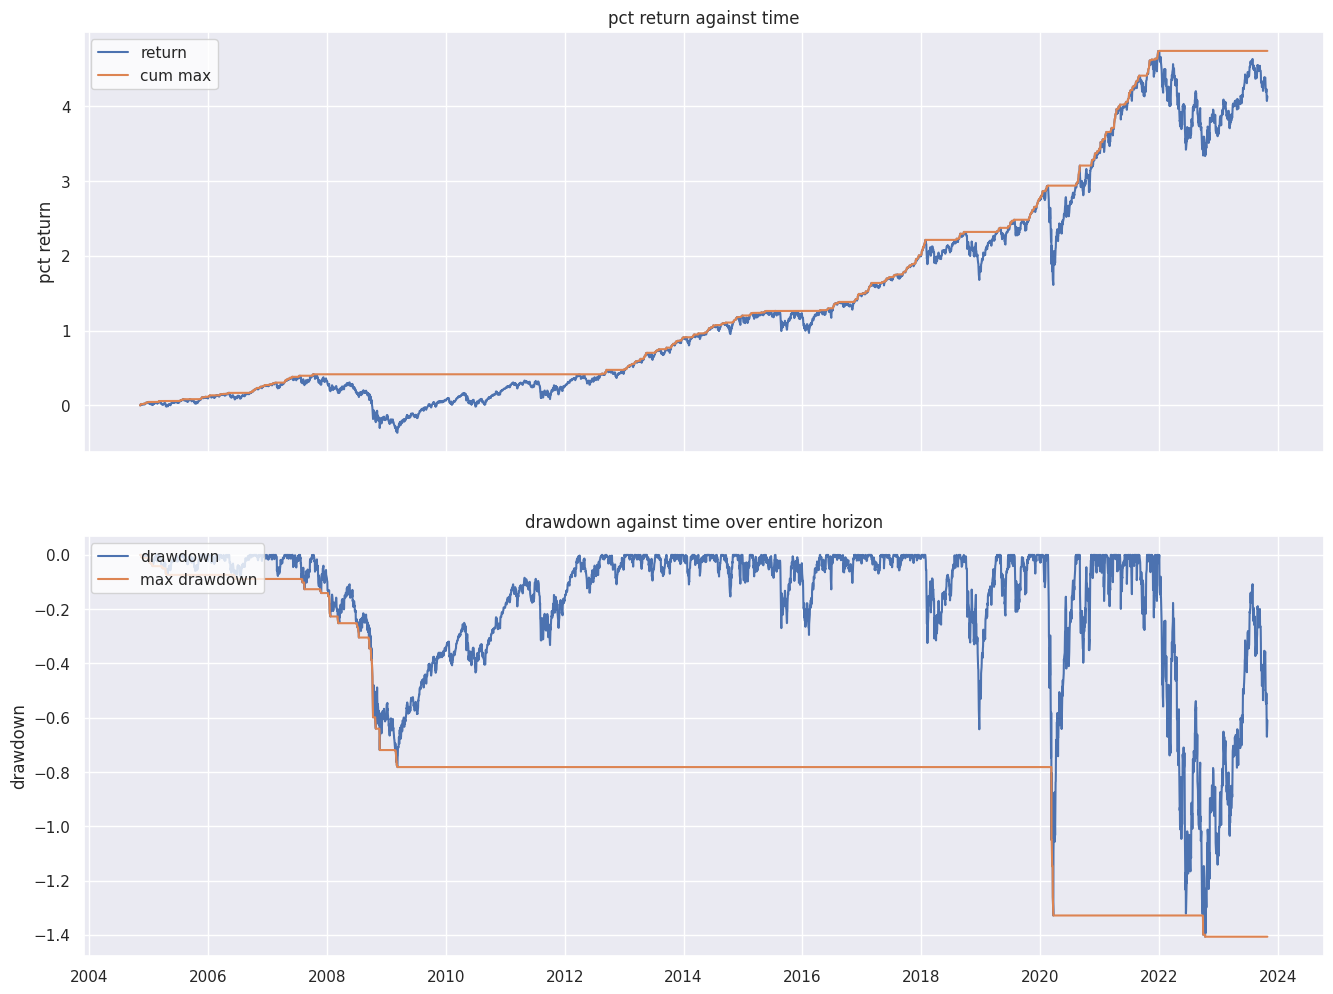

In [ ]:
df_sp500_logit  = df_sp500_price_bkup.copy()

lag_max : int = 5
df_sp500_logit["dir"] = np.where(df_sp500_logit.ret_asset > 0, 1, -1)
for l in range(lag_max):
    df_sp500_logit[f"ret_t-{l+1}"]    = df_sp500_logit.ret_asset.shift(periods = l+1)
    # df_sp500_logit[f"price_t-{l+1}"]  = df_sp500_logit.price.shift(periods = l+1)

df_sp500_logit  = df_sp500_logit.dropna()

from sklearn    import linear_model as lm
LR  = LR  = lm.LogisticRegression(
    solver      = "lbfgs",
    C           = 1e7,
    multi_class = "auto",
    max_iter    = 1000
)

LR.fit(
    df_sp500_logit.iloc[:, -lag_max:],
    np.sign(df_sp500_logit.dir)
)

df_sp500_logit["strategy"]  = LR.predict(df_sp500_logit.iloc[:, -lag_max:])
df_sp500_logit["position"]  = df_sp500_logit.strategy.shift(periods = 1).fillna(0)
df_sp500_logit["trade"]     = df_sp500_logit.position.diff().fillna(0)

df_sp500_logit  = getReturnPerPositionStrategy(df_sp500_logit)
### When long, buy max number of stocks with available cash
df_sp500_logit  = getTradingReturn(df_sp500_logit, capital_initial = 10 **5)

measure_sp500_logit = getSharpeRatio(df_sp500_logit.ret_portfolio_pct)
dict_measure_sp500_logit    = {
    "value_final"   : df_sp500_logit.iloc[-1]["value_total"],
    "ret_portfolio" : df_sp500_logit.iloc[-1]["ret_portfolio"],
    "return"        : measure_sp500_logit[1],
    "volatility"    : measure_sp500_logit[2],
    "sharpe"        : measure_sp500_logit[0],
    "cagr"          : getCagr(df_sp500_logit.ret_portfolio)
}
print(dict_measure_sp500_logit)

df_sp500_logit_dd   = getDrawdownDf(df_sp500_logit.ret_portfolio_pct) #, window = 252)
print("\n=== MAX DRAWDOWN ON SORT BY MAX VALUES ===")
print(df_sp500_logit_dd.drop_duplicates(subset = "drawdown_max", keep = "first").sort_values(by = "drawdown_max", ascending = True).head(5))
print("\n=== MAX DRAWDOWN ON DRAWDOWN PERIOD ===")
print(df_sp500_logit_dd.drop_duplicates(subset = "drawdown_max", keep = "last").sort_values(by = "drawdown_period", ascending = False).head(5))


Machine Learning

We have 39 indicators, and some of them are correlated. So we are supposed to implement the Principle Components Analysis and simplify the following calculations.

We are supposed to use the 20 components to substitute the original indicators.

Although we are only asked to report the in-sample performance of the strategy. But to select the most suitable algorithm. The data is split to training set (80% of the data) and test set (20% of the data). We believe that a suitable algorithm will have a good result both in in-sample and out-of-sample periods. So we are supposed to choose the algorithm that minimize out-of-sample errors and have close in-sample and out-of-sample errors.

According to the criteria above, We choose KNN, Gaussian NB. But we notice that the CART has the lowest in-sample errors. As our goal is to pursue the largest in-sample accumulative return, we will still preserve this algorithm. In practice, CART may not be a good choice due to the problem of over-fitting. But our goal determines that we will not give this algorithm up.

In [ ]:
index_ticker = "SPY"
start = dt.datetime(2004,11,1)
end = dt.datetime(2023,10,31)

SPY = yf.download(index_ticker, start, end)
SPY["log_return"] =\
    np.log(SPY["Adj Close"]/SPY["Adj Close"].shift(1))

stock_ticker = ["MSFT", "IBM", "GOOGL"]

currency_ticker = ["DEXJPUS", "DEXUSUK"]

index_ticker = ["VIXCLS"]


stock_data = pdr.get_data_yahoo(stock_ticker, start, end)
currency_data = pdr.get_data_fred(currency_ticker, start, end)
index_data = pdr.get_data_fred(index_ticker, start, end)

sp500 = pd.DataFrame(index = SPY.index)

sp500["returns"] = SPY["log_return"]

sp500['returns_lag1']=sp500['returns'].shift(1)

sp500['returns_lag5']=sp500['returns'].shift(5)

sp500['returns_lag10']=sp500['returns'].shift(10)

def RSI(df, period):
    outcome = df
    outcome["simple_return"] = outcome["Adj Close"].pct_change()
    col = []
    for i in period:
        col.append(f"RSI_{i}")
        outcome[f"Gain_{i}"] = np.where(outcome["simple_return"] > 0, outcome["simple_return"], 0)
        outcome[f"Loss_{i}"] = np.where(outcome["simple_return"] < 0, outcome["simple_return"], 0)
        outcome[f"RSI_{i}"] = 100 - 100 / (1 + outcome[f"Gain_{i}"].rolling(i).mean() / outcome[f"Loss_{i}"].abs().rolling(i).mean())

    return outcome.loc[:,col]
X1 =\
    RSI(SPY, [10,30,200])

def sto_oscillator(df, period):
    outcome = df
    col_K = []
    col_D = []

    for i in period:
        col_K.append(f"%K_{i}")
        col_D.append(f"%D_{i}")

        outcome[f"High_{i}"] = outcome["Adj Close"].rolling(window = i).max()
        outcome[f"Low_{i}"] = outcome["Adj Close"].rolling(window = i).min()

        outcome[f"%K_{i}"] = (outcome["Adj Close"] - outcome[f"Low_{i}"]) / (outcome[f"High_{i}"] - outcome[f"Low_{i}"])
        outcome[f"%D_{i}"] = outcome[f"%K_{i}"].rolling(window = 3).mean()
    return pd.concat([outcome[col_K], outcome[col_D]], axis = 1)
X2 =\
    sto_oscillator(SPY, [10,30,200])

def ROC(df, period):
    outcome = df
    col = []

    for i in period:
        col.append(f"ROC_{i}")
        outcome[f"ROC_{i}"] = (outcome["Adj Close"] - outcome["Adj Close"].shift(i)) / outcome["Adj Close"].shift(i)
    return outcome[col]
X3 =\
    ROC(SPY, [10,30])

X4 =\
    (pd.concat([SPY.loc[ : , "Adj Close"]
               .rolling(window = i)
               .mean() for i in [21,63,252]
               ],
               axis = 1
              )
     .dropna()
    )

X4.columns = ["SPY_MA21","SPY_MA63","SPY_MA252"]

X5 =\
    (pd.concat([SPY.loc[ : , "Adj Close"]
               .ewm(span = i)
               .mean() for i in [10,30,200]
               ],
               axis = 1
              )
     .dropna()
    )

X5.columns = ["SPY_EMA10","SPY_EMA30","SPY_EMA200"]

X6 =\
    ((stock_data.loc[ : , ("Adj Close", ("MSFT", "IBM", "GOOGL")
                             )
                       ]
        ).pct_change()
    )

X6.columns =\
    (X6
     .columns
     .droplevel()
    )

X6['MSFT_returns_lag1']=X6['MSFT'].shift(1)
X6['IBM_returns_lag1']=X6['IBM'].shift(1)
X6['AAPL_returns_lag1']=X6['GOOGL'].shift(1)

X6['MSFT_returns_lag5']=X6['MSFT'].shift(5)
X6['IBM_returns_lag5']=X6['IBM'].shift(5)
X6['AAPL_returns_lag5']=X6['GOOGL'].shift(5)

X6['MSFT_returns_lag10']=X6['MSFT'].shift(10)
X6['IBM_returns_lag10']=X6['IBM'].shift(10)
X6['AAPL_returns_lag10']=X6['GOOGL'].shift(10)

X7 =\
    ((currency_data).pct_change()
    )
X8 =\
    ((index_data).pct_change()
    )

X8["VIXCLS_lag1"] = X8["VIXCLS"].shift(1)
X8["VIXCLS_lag5"] = X8["VIXCLS"].shift(5)
X8["VIXCLS_lag10"] = X8["VIXCLS"].shift(10)

data =\
(
    pd
    .concat([X1, X2, X3, X4, X5, X6, X7, X8, sp500],
            axis = 1)
    .dropna()
)

data

data['signal']=np.where(data['returns']>0,1,-1)
data['signal'] = data['signal'].shift(-1)
data.dropna(inplace=True)

Y = data["signal"]
X = data.loc[:, data.columns != "signal"]

correlation = X.corr()

plt.figure(figsize=(15,15))
plt.title("Correlation Matrix")

sns.heatmap(correlation,
            vmax = 1,
            square = True,
            annot = True,
            cmap = "viridis")

plt.show()

X.plot(kind = "density",
          subplots = True,
          layout = (7,8),
          sharex = False,
          legend = True,
          figsize = (16, 16)
         )
plt.show()

scaler =\
(
    StandardScaler()
    .fit(X)
)

X_rescale = pd.DataFrame(scaler.fit_transform(X),columns = X.columns, index = X.index)
X_rescale.describe()

from sklearn.decomposition import PCA
pca = PCA()

PrincipalComponent = pca.fit(X_rescale)

NumEigenValues = 30

fig, axes =\
(
    plt
    .subplots(ncols = 2,
              figsize = [16, 6]
             )
)

Series1 =\
(
    pd
    .Series(pca
            .explained_variance_ratio_[ :NumEigenValues]
           )
    .sort_values()
    * 100
)


Series2 =\
(
    pd
    .Series(pca
            .explained_variance_ratio_[ :NumEigenValues]
           )
    .cumsum()
    * 100
)

(
    Series1
    .plot
    .barh(ylim = (0, 29),
          title = "Explained Variance Ratio by Top 10 PCs",
          ax = axes[0]
         )
)

(
    Series2
    .plot(ylim = (0, 100),
          xlim = (0, 29),
          title = "Cumulative Explained Variance by Each PC",
          ax = axes[1]
         )
)

from matplotlib.ticker import MaxNLocator
from sklearn.decomposition import TruncatedSVD

ncomps = 20

svd = TruncatedSVD(n_components=ncomps)

svd_fit = svd.fit(X_rescale)

plt_data = pd.DataFrame(svd_fit.explained_variance_ratio_.cumsum()*100)

plt_data.index = np.arange(1, len(plt_data) + 1)

Y_pred = svd.fit_transform(X_rescale)

X_rescale = pd.DataFrame(Y_pred, columns=["c{}".format(c) for c in range(ncomps)],
                     index = X_rescale.index)

X_rescale.head()


validation_size = 0.20
train_size =\
    int(len(X_rescale)
        *
        (1 - validation_size)
       )

X_train, X_test =\
    (X_rescale[0         :train_size],
     X_rescale[train_size:len(X_rescale)    ]
    )

Y_train, Y_test =\
    (Y[0         :train_size],
     Y[train_size:len(X)    ]
    )


num_folds = 10
seed = 20231116
scoring = "accuracy"

models = []

models.append(("LR", LogisticRegression(n_jobs = -1)))

models.append(("LDA", LinearDiscriminantAnalysis()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("CART", DecisionTreeClassifier()))
models.append(("NB", GaussianNB()))

# Boosting methods
models.append(("AB", AdaBoostClassifier()))
models.append(("GBM", GradientBoostingClassifier()))

# Bagging methods
models.append(("RF", RandomForestClassifier(n_jobs = -1) ))

results = []

names = []

train_results=[]

test_results=[]

for name, model in models:
    kfold = KFold(n_splits = num_folds,
                  random_state = seed,
                  shuffle = True)
    cv_results = cross_val_score(model,
                                 X_train,
                                 Y_train,
                                 cv = kfold,
                                 scoring = scoring)
    results.append(cv_results)
    names.append(name)

    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)

    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)

    msg = "%s: %f (%f)" % (name, train_result, test_result)
    print(msg)



fig = plt.figure(figsize = (16, 8)
                 )

ind = np.arange(len(names)
               )
width = 0.35

fig.suptitle("Comparing the Performance of Various Algorithms on the Training and Testing Datasets")
ax = fig.add_subplot(111)

plt.bar(ind - width/2,
        train_results,
        width = width,
        label = "Errors in Training Set")

plt.bar(ind + width/2,
        test_results,
        width = width,
        label = "Errors in Testing Set")

plt.legend()

ax.set_xticks(ind)
ax.set_xticklabels(names)

plt.ylabel("Mean Squared Error")

plt.show()







### <a id = "s4">=== PART 4: CONCLUSION ===</a>
[contents](#top)

Backtesting for mean-reversion strategy

In [ ]:
backtesting(RSI_Traditional_strategy1, "Traditional RSI Strategy")
backtesting(KDJ_strategy00, "KDJ Strategy")


Backtesting for Machine Learning

In [ ]:
def backtest(model,model_name):
    M= model
    M.fit(X,Y)
    Predicts=pd.Series(M.predict(X))
    Predicts.index = Y.index
    Predicts.name='predicts'

    data2=pd.concat([SPY['Adj Close'],Predicts],axis=1,join='inner')

    data2['return']=np.log(data2['Adj Close']/data2['Adj Close'].shift(1))
    data2['cum_returns']=data2['return'].cumsum().apply(np.exp)
    data2['strategy']=data2['return']*data2['predicts'].shift(1)
    data2['cum_strategy']=data2['strategy'].cumsum().apply(np.exp)
    data2['cum_max']= data2['cum_strategy'].cummax()

    drawdown = data2['cum_max'] - data2['cum_strategy']

    periods =\
    (
        drawdown[drawdown == 0].index[ 1 :   ].to_pydatetime()
        -
        drawdown[drawdown == 0].index[   : -1].to_pydatetime()
    )



    data2['signal']=np.where(data2['return']>0,1,-1)
    data2['signal']=data2['signal'].shift(-1)

    annual_vol = data2['strategy'].std()*np.sqrt(252)
    sharpe_ratio=(data2['strategy'].mean()/data2['strategy'].std())*np.sqrt(252)
    D = (data2.index[-1]-data2.index[0]).days
    CAGR = (((data2['cum_strategy'][-1]) / (data2["cum_strategy"][1])) ** (365.0/D)) - 1


    max_drawdown = drawdown.max()
    max_drawdown_periods = periods.max()
    total_asset=100000.0 * data2['cum_strategy'][-1]

    table=pd.DataFrame({'Sharpe Ratio': sharpe_ratio,
                        'CAGR': CAGR,
                        'Max Drawdown': max_drawdown,
                        'Total Asset': total_asset,
                        'Strategy Return': data2['cum_strategy'][-1],
                        "Annual_vol" : annual_vol,
                        "max_drawdown_periods" :max_drawdown_periods
    },columns=['Sharpe Ratio','CAGR','Max Drawdown','Total Asset','Strategy Return','Annual_vol',"max_drawdown_periods"],index=[model_name])

    data2[['cum_strategy','cum_returns']].plot(figsize=(10,6))

    return data2,table

LDA,LDA_p=backtest(LinearDiscriminantAnalysis(),'LDA')
KNN,KNN_p=backtest(KNeighborsClassifier(),'KNN')
CART,CART_p=backtest(DecisionTreeClassifier(),'CART')
NB,NB_p=backtest(GaussianNB(),'NB')
AB,AB_p=backtest(AdaBoostClassifier(),'AB')
GBM,GBM_p=backtest(GradientBoostingClassifier(),'GBM')
RF,RF_p=backtest(RandomForestClassifier(n_jobs = -1),'RF')
ML_strategy = pd.concat([LDA_p,KNN_p,CART_p,NB_p,AB_p, GBM_p,RF_p])
ML_strategy


<table>
  <tr>
    <th>Strategy Name</th>
    <th>Final Portfolio Value</th>
    <th>Cumulative Return</th>
    <th>Annualized Volatility</th>
    <th>Sharpe Ratio</th>
    <th>CAGR</th>
    <th>Max Drawdown</th>
    <th>Max DD Period</th>
  </tr>
  <tr>
    <td>Long and Hold</td>
    <td>528256.3091583252</td>
    <td>4.282563091583252</td>
    <td>0.19295219289771762</td>
    <td>0.4751024114111877</td>
    <td>0.09152450191619743</td>
    <td>-1.447535</td>
    <td>4020 days</td>
  </tr>
  <tr>
    <td>Traditional RSI</td>
    <td>172534.159164</td>
    <td>1.725342</td>
    <td>0.094225</td>
    <td>0.306444</td>
    <td>0.029127</td>
    <td>0.220545</td>
    <td>3896 days</td>
  </tr>
  <tr>
    <td>Traditional KDJ</td>
    <td>475472.693888</td>
    <td>4.754727</td>
    <td>0.111533</td>
    <td>0.740678</td>
    <td>0.085611</td>
    <td>0.240892</td>
    <td>2525 days</td>
  </tr>
  <tr>
    <td>RSI+MACD</td>
    <td>47235.833103</td>
    <td>0.472358</td>
    <td>0.193855</td>
    <td>-0.205295</td>
    <td>-0.038793</td>
    <td>0.722964</td>
    <td>6548 days</td>
  </tr>
  <tr>
    <td>RSI+Momentum</td>
    <td>911788.214269</td>
    <td>9.117882</td>
    <td>0.158749</td>
    <td>0.739861</td>
    <td>0.123894</td>
    <td>0.247222</td>
    <td>670 days</td>
  </tr>
  <tr>
    <td>KDJ+Mean-Reversion</td>
    <td>972293.838161</td>
    <td>9.722938</td>
    <td>0.133541</td>
    <td>0.902058</td>
    <td>0.127267</td>
    <td>0.339273</td>
    <td>2815 days</td>
  </tr>
  <tr>
    <td>OLS on Price Prediction</td>
    <td>6451149000.0</td>
    <td>64511.486603</td>
    <td>0.192976</td>
    <td>4.676953</td>
    <td>0.902539</td>
    <td>0.100569</td>
    <td>1556 Period</td>
  </tr>
  <tr>
    <td>Logit Regression based on 5d Lag</td>
    <td>513277.9023361206</td>
    <td>4.132779023361206</td>
    <td>0.19302519507627075</td>
    <td>0.46686594046091906</td>
    <td>0.08996851233615688</td>
    <td>-1.406535</td>
    <td>4020 days</td>
  </tr>
  <tr>
    <td>SMA on Volume Prediction</td>
    <td>604197.230935</td>
    <td>6.041972</td>
    <td>0.109261</td>
    <td>0.909996</td>
    <td>0.099427</td>
    <td>0.033454</td>
    <td>46 Period</td>
  </tr>
  <tr>
    <td>SMA</td>
    <td>397877.81</td>
    <td>3.7096</td>
    <td>0.1974</td>
    <td>0.3905289161476579</td>
    <td>0.13703260001185158</td>
    <td>2.057693252843612</td>
    <td>1712 days</td>
  </tr>
  <tr>
    <td>EWM</td>
    <td>193383.67</td>
    <td>3.6815</td>
    <td>0.1975</td>
    <td>0.18645976805150238</td>
    <td>0.13703260001185158</td>
    <td>3.046546231761958</td>
    <td>1918 days</td>
  </tr>
  <tr>
    <td>MACD Long + Short</td>
    <td>76328.73003387451</td>
    <td>-0.23671269966125486</td>
    <td>0.16214538262648595</td>
    <td>-0.08716798594086986</td>
    <td>-0.014112259396324767</td>
    <td>-0.624532</td>
    <td>2988 days</td>
  </tr>
  <tr>
    <td>MACD Long Only</td>
    <td>140955.89031219482</td>
    <td>0.4095589031219482</td>
    <td>0.09823926864122345</td>
    <td>0.18581655957518028</td>
    <td>0.018226096464195596</td>
    <td>-0.344275</td>
    <td>5375 days</td>
  </tr>
  <tr>
    <td>KNN</td>
    <td>1.039782e+11</td>
    <td>1.039782e+06</td>
    <td>0.190999</td>
    <td>4.036080</td>
    <td>1.158021</td>
    <td>27728.777734</td>
    <td>96 days</td>
  </tr>
  <tr>
    <td>GBM</td>
    <td>7.049433e+11</td>
    <td>7.049433e+06</td>
    <td>0.189166</td>
    <td>4.638148</td>
    <td>1.158019</td>
    <td>140193.614784</td>
    <td>98 days</td>
  </tr>
  <tr>
    <td>CART</td>
    <td>3.852783e+20</td>
    <td>3.852783e+15</td>
    <td>0.151700</td>
    <td>13.163076</td>
    <td>6.335249</td>
    <td>0.000000	</td>
    <td>5 days</td>
  </tr>
  
</table>


### <a id = "s5">=== PART 5: SELF CRITIQUES ===</a>
[contents](#top)

BALINA KIRTI KUMAR ON MOMENTUM (SMA + EMA) TECHNIQUES
=====================================================
The trading strategy is based on two different technical indicators: Simple Moving Averages (SMA) and Exponential Weighted Moving (EWM). It tests various combinations of parameters (short and long periods for SMA and span for EWM) to find the best-performing strategies.

Self-Critique of the SMA and EWM trading strategy:
1.	Lack of Hypothesis Testing: Conducted a search over parameter ranges for both SMA and EWM without any hypothesis testing or statistical significance analysis. This could potentially lead to overfitting, where the strategy performs well on historical data but may not generalize to new data. As such, hypothesis testing (e.g., t-tests or p-values) could help determine if the strategy's performance is statistically significant.
2.	Risk Management: Did not include any risk management techniques, such as position sizing or stop-loss orders. These are important for managing the downside risk of a trading strategy.
3.	Out-of-Sample Testing: Only analyses historical data but did not include an out-of-sample testing period. It is crucial to assess how the strategy performs on unseen data to evaluate its robustness.
4.	Transaction Costs and Slippage: Does not consider transaction costs or slippage, which are essential in real-world trading. Incorporating these costs would provide a more accurate representation of strategy performance.
5.	Over-Optimization Risk: Tests multiple parameter combinations, which can lead to over-optimization or curve-fitting. It is important to be cautious about selecting the best-performing parameters based solely on historical data, as they may not perform as well in the future.

In summary, while the code provides a comprehensive analysis of SMA and EWM trading strategies, it lacks some critical elements, such as hypothesis testing, risk management, benchmark comparison, and consideration of transaction costs. To make the strategy more robust and realistic, these aspects should be addressed, and the strategy should be evaluated on out-of-sample data to assess its potential for real-world application.


TAY SAMUEL ON MOMENTUM (MACD) AND LOGIT REGRESSION TECHNIQUES
=============================================================
What I have done is to propose to use the initial capital of 100,000 USD to buy as many shares of the index as we can on Day 1, using generic MACD strategy to generate buy and sell signals. On buy signals, we use all the cash available on hand to buy as many shares we can or use all the cash available to loan as many shares to short sell as we can. Also, I use logit regression using the past 5 days of returns to predict the movement of the next day to generate buy or sell signals.

The aim here is to see if using moving average convergence divergence (MACD) and logistic regression on past 5 days of price log return information.

SELF CRITIQUE

SPY500 is a composite index and would be rebalanced quarterly. This also means that the index would naturally be upward trending, not only capturing the effect of inflation but also reflecting the growth of the economy as well.

Hence, by longing the index, i.e., by using the 100,000 initial capital to by as much shares of the index as we could, we would get a return of 428%.

One major shortcoming of MACD is that a divergence signal produced suggesting a reversal price movement and hence to short sell might be a false signal. This creates an issue for a generally upward trending asset like S&P500, resulting in losses when we short sell with a divergence signal. Hence, the result of a -27.3% cumulative return over the period of 2 decades is not surprising.

By not short selling and dispose of all positions instead of short selling with a divergence signal, we see 41.0% cumulative return - which is a farcry from the cumulative return of not doing anything.

On the logit regression where we use the last 5 days of returns as inputs to predict the direction of the current day price movement, this produce similar result as to long and hold. This again is unsurprising since the index itself is upward trending in nature.

In all, it seems like MACD might not be a good approach to attempt to forecast index movements - but more appropriate for specific asset


HANNAH ON RSI AND KDJ
=====================
What I have done:
Mean Reversion strategies-RSI and KDJ
Finish the traditional RSI and Stochastic Oscillator strategy with parameter tuning. Based on it, adding momentum factor to RSI strategy and mean-reversion factor to Stochastic Oscillator strategy. Also, combine MACD and RSI strategy to test whether combine strategies could have a better performance

Self critiques:
In the past 20 years, there have been too many factors that determine the trend of stock prices in the securities market, so it is difficult to achieve good results by using simple mean-reversion technical indicators as quantitative timing criteria, let alone beat the market.
In traditional RSI and KDJ strategies, even if parameter tuning with overfitting suspicion is used, the performance of the strategy is still not as good as buy and hold SPY. Therefore, I took other measures to try to optimize the strategy.
The first thing that came to mind was to follow the idea of golden crossing and death crossing in the simple moving average strategy, adding momentum factors to the mean-reversion strategy. However, its performance was still unsatisfactory, especially in the KDJ strategy. After continuous trial and error, the trend impact brought by golden crossing and death crossing in the KDJ strategy was changed, and instead, a good result was obtained. The explanation for this is that when the trading signal shows an upward trend, many stock purchases cause overbought, and the upward trend will slow down or even gradually decline. Therefore, the K-line and D-line trading signals are adjusted to become a new reversal factor, strengthening the strength of mean reversion strategy mean regression.
However, the feasibility of doing so in reality is very small because it causes overfitting, and if the strategy is applied to future short-term transactions, it will not yield good results. So, in the following research and learning, still need to find some new ways to adjust and optimize these two mean-reversion strategies.


GUO YI ON MACHINE LEARNING TECHNIQUES
=====================================
Total daily volume as the sole indicator might not be strong enough to predict the price movement, as the volume itself can't define whether it is a bull or bear market. Volume might be a better indicator for intraday trading. Having said that, the strategy actually beat the long and hold SPY, which is quite surprising. In addition, there are too many switching of positions which will adversely impact the strategy due to increasing transaction cost.

This strategy is jaw-dropping with a cumulative return of x64511 comparing to only x5 for long and hold SPY. R2 score for OLS is too low which means exogenous variables having little predictive power on the independent variable. More effort can be spent on increasing the R2 score which can definitely improve the trading strategy. In addition, there are a number of market regime shifts during the time period, by deploying a single regression is not enough, as a single OLS model can't cope with so many market regimes.


GOU XINWEN ON MACHINE LEARNING TECHNIQUES
=========================================
I try the machine learning strategy. At first, I process input features and find 39 related indicators. Then I try to use PCA to reduce the dimensions to 20. Finally, I use machine learing to predict SP500 up and down signal and then the strategy return.

Self critique:
The machine learning method gives us very crazy results. I'm not sure why is the case, but partly it's overfitting. When I only use the machine learning to predict test data and do backtesting in test sample, the result seems to be less insane, however it's still crazy.